In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from collections import Counter
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch. utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.models import vit_b_16
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models, transforms
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import seaborn as sns


Mounted at /content/drive


# Creacion de los datasets

In [ ]:
# carpetas con las imagenes y archivos excel con diagnosticos
folder_paths = [
    '/content/drive/MyDrive/Base11', '/content/drive/MyDrive/Base12', '/content/drive/MyDrive/Base13',
    '/content/drive/MyDrive/Base14', '/content/drive/MyDrive/Base21', '/content/drive/MyDrive/Base22',
    '/content/drive/MyDrive/Base23', '/content/drive/MyDrive/Base24', '/content/drive/MyDrive/Base31',
    '/content/drive/MyDrive/Base32', '/content/drive/MyDrive/Base33', '/content/drive/MyDrive/Base34',
    '/content/drive/MyDrive/IDRID'
]

# funcion para extraer los diagnosticos
def get_diagnostics(folder_paths):
  diagnostics = {}
  for folder in folder_paths:
      excel_files = [f for f in os.listdir(folder) if f.endswith('.xlsx') or f.endswith('.xls')]
      for excel_file in excel_files:
          file_path = os.path.join(folder, excel_file)
          df = pd.read_excel(file_path)
          for _, row in df.iterrows():
              image_name = row['Image name']
              retinopathy_grade = row['Retinopathy grade']
              diagnostics[image_name] = 1 if retinopathy_grade > 0 else 0
  return diagnostics


diagnostics = get_diagnostics(folder_paths)

In [ ]:

input_size = (224, 224)

# preparar las imágenes sin aplicar el CLAHE ni aumentos
data_without_processing = []
for folder in folder_paths:
    for image_name, label in diagnostics.items():
        image_path = os.path.join(folder, image_name)
        if os.path.exists(image_path):
          image = cv2.imread(image_path)
          image_resized = cv2.resize(image, input_size)
          input_tensor = np.expand_dims(image_resized, axis=0)
          data_without_processing.append((input_tensor, label))



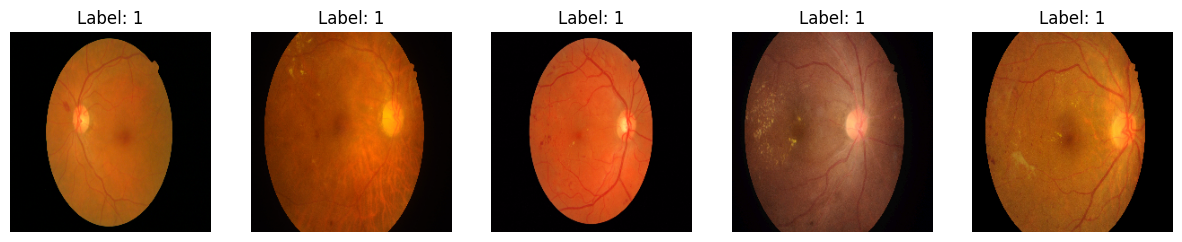

In [ ]:
fundus = "fundus1"
os.makedirs(fundus, exist_ok=True)
# previsualizamos 5 imagenes random
plt.figure(figsize=(15, 10))
for i, (image_tensor, label) in enumerate(random.sample(data_without_processing, 5)):
    image = np.squeeze(image_tensor, axis=0)
    # BGR a RGB
    image_rgb = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, i + 1)
    plt.imshow(image_rgb)
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.savefig(os.path.join(fundus, "grid_with_labels.png"), dpi=300, bbox_inches='tight')
plt.show()

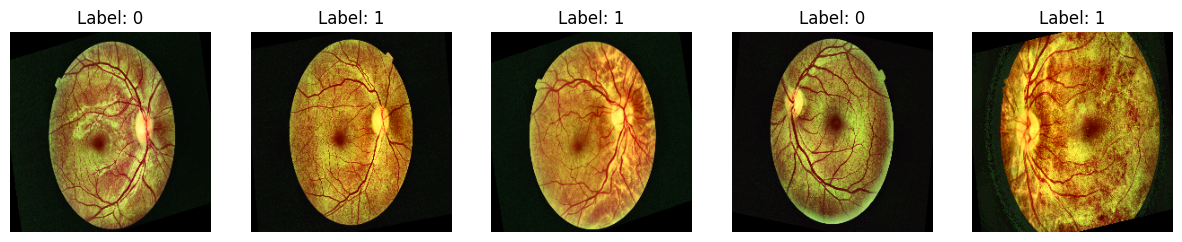

In [ ]:
import cv2
import numpy as np


data = []
for folder in folder_paths:
  for image_name, label in diagnostics.items():
      image_path = os.path.join(folder, image_name)
      if os.path.exists(image_path):
          data.append((image_path, label))

def enhance_green_channel(image, clipLimit=2.0, tileGridSize=(8, 8)):
    # pasamos la imagen a lab (luminosiad, eje rojo-verde y eje azul-amarillo)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # canales lab
    l, a, b = cv2.split(lab)

    # clahe al canal L
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    l_enhanced = clahe.apply(l)

    # sustituimos con el canal l con clahe
    lab_enhanced = cv2.merge((l_enhanced, a, b))

    # convertimos la imagen de nuevo a bgr
    image_enhanced = cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2BGR)

    # canal verde
    g_channel = image_enhanced[:, :, 1]

    # clahe al canal verde
    g_enhanced = clahe.apply(g_channel)

    # sustitumos con el canal verde con claje
    image_enhanced[:, :, 1] = g_enhanced

    return image_enhanced

def augment_image(image):
    # random horizontal flip
    if random.random() > 0.5:
        image = cv2.flip(image, 1)

    # random rotation
    angle = random.uniform(-15, 15)
    M = cv2.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), angle, 1)
    image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

    # random scaling
    scale = random.uniform(0.9, 1.1)
    image = cv2.resize(image, None, fx=scale, fy=scale)

    return image

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found at {image_path}")
    image = enhance_green_channel(image, clipLimit=2.0, tileGridSize=(8, 8))
    image= augment_image(image)
    image = cv2.resize(image, input_size)
    return image


processed_data = []

for image_path, label in data:
    preprocessed_image = preprocess_image(image_path)
    input_tensor = np.expand_dims(preprocessed_image, axis=0) # expandimos a 4 dimensiones
    processed_data.append((input_tensor, label))

fundus2 = "fundus2"
os.makedirs(fundus2, exist_ok=True)
plt.figure(figsize=(15, 10))
for i, (image_tensor, label) in enumerate(random.sample(processed_data,5)):
    image = cv2.resize(image, input_size)
    image = np.squeeze(image_tensor, axis=0)
    # bgr a rgb
    image_rgb = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2RGB)
    plt.subplot(1, 5, i + 1)
    plt.imshow(image_rgb)
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.savefig(os.path.join(fundus2, "proessed.png"), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np


def list_to_numpy(data_list):
    """
    Convertir lista (input_tensor, label) a arrays NumPy.
    """
    X = []
    y = []
    for (tensor, label) in data_list:
        if tensor.shape == (1, 224, 224, 3):
            X.append(tensor[0])  # quitamos dimension batch
        else:
            raise ValueError(f"Unexpected tensor shape: {tensor.shape}")
        y.append(label)

    # X e y son NumPy arrays
    X = np.array(X, dtype=np.float32)  # (N, 224, 224, 3)
    y = np.array(y, dtype=np.float32)  # (N,)
    return X, y

# formas consistenteS?
for i, (tensor, label) in enumerate(processed_data):
    if tensor.shape != (1, 224, 224, 3):
        print(f"Inconsistent shape at index {i}: {tensor.shape}")

try:
    X_processed, y_processed = list_to_numpy(processed_data)
    print(f"Processed data shapes: X={X_processed.shape}, y={y_processed.shape}")
except ValueError as e:
    print(f"Error in list_to_numpy: {e}")

X_unprocessed, y_unprocessed = list_to_numpy(data_without_processing)

X_temp, X_test_proc, y_temp, y_test_proc = train_test_split(
    X_processed,
    y_processed,
    test_size=0.1,
    random_state=2001,
    stratify=y_processed
)

X_train_proc, X_val_proc, y_train_proc, y_val_proc = train_test_split(
    X_temp,
    y_temp,
    test_size=0.2,
    random_state=2001,
    stratify=y_temp
)

# Split para datos no procesados
X_temp2, X_test_unproc, y_temp2, y_test_unproc = train_test_split(
    X_unprocessed,
    y_unprocessed,
    test_size=0.1,
    random_state=2001,
    stratify=y_unprocessed
)

X_train_unproc, X_val_unproc, y_train_unproc, y_val_unproc = train_test_split(
    X_temp2,
    y_temp2,
    test_size=0.2,
    random_state=2001,
    stratify=y_temp2
)

print("Tamaño de train:", X_train_unproc.shape, y_train_unproc.shape)
print("Tamaño de val:  ", X_val_unproc.shape,   y_val_unproc.shape)
print("Tamaño de test: ", X_test_unproc.shape,  y_test_unproc.shape)


# dataset para los datos
class RetinopathyDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]        # 0 o 1

        # reordenar dimensiones
        image_tensor = torch.tensor(image, dtype=torch.float).permute(2, 0, 1)

        if self.transform:
            image_tensor = transforms.ToPILImage()(image_tensor)
            image_tensor = self.transform(image_tensor)

        return image_tensor, label

# definimos transformaciones para estadisticos de imagenet
basic_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])




Processed data shapes: X=(1703, 224, 224, 3), y=(1703,)
Tamaño de train: (1225, 224, 224, 3) (1225,)
Tamaño de val:   (307, 224, 224, 3) (307,)
Tamaño de test:  (171, 224, 224, 3) (171,)


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

X_train, X_test, y_train, y_test= train_test_split(
    X_processed,
    y_processed,
    test_size=0.1,
    random_state=2001,
    stratify=y_processed
)

X_train2, X_val, y_train2, y_val= train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=2001,
    stratify=y_train
)


X_train_unproc, X_test_unproc, y_train_unproc, y_val_unproc= train_test_split(
    X_unprocessed,
    y_unprocessed,
    test_size=0.1,
    random_state=2001,
    stratify=y_unprocessed
)

X_train_unproc_2, X_val_unproc, y_train_unproc_2, y_val_unproc= train_test_split(
    X_train_unproc,
    y_train_unproc,
    test_size=0.2,
    random_state=2001,
    stratify=y_train_unproc
)

# Datasets PROCESSED
train_processed_dataset = RetinopathyDataset(X_train, y_train, transform=basic_transform)
train2_processed_dataset = RetinopathyDataset(X_train2, y_train2, transform=basic_transform)
val_processed_dataset   = RetinopathyDataset(X_val, y_val,   transform=basic_transform)
test_processed_dataset  = RetinopathyDataset(X_test,  y_test,  transform=basic_transform)

# Datasets PROCESSED
train_unprocessed_dataset = RetinopathyDataset(X_train_unproc, y_train_unproc, transform=basic_transform)
train2_unprocessed_dataset = RetinopathyDataset(X_train_unproc_2, y_train_unproc_2, transform=basic_transform)
val_unprocessed_dataset   = RetinopathyDataset(X_val_unproc, y_val_unproc,   transform=basic_transform)
test_unprocessed_dataset  = RetinopathyDataset(X_test_unproc,  y_test_unproc,  transform=basic_transform)





## GRID SEARCH CNN

=== Grid Search with Cross-Validation - PROCESSED DATA ===
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 1
Epoch 1/5, Train Loss: 2.9189, Val Loss: 0.7741, Val Acc: 0.4984
Epoch 2/5, Train Loss: 0.7528, Val Loss: 0.6666, Val Acc: 0.5928
Epoch 3/5, Train Loss: 0.6880, Val Loss: 0.6374, Val Acc: 0.5668
Epoch 4/5, Train Loss: 0.6606, Val Loss: 0.6354, Val Acc: 0.5537
Epoch 5/5, Train Loss: 0.6478, Val Loss: 0.6465, Val Acc: 0.5765
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 2
Epoch 1/5, Train Loss: 2.8458, Val Loss: 0.7745, Val Acc: 0.5505
Epoch 2/5, Train Loss: 0.8131, Val Loss: 0.6860, Val Acc: 0.5765
Epoch 3/5, Train Loss: 0.7072, Val Loss: 0.6531, Val Acc: 0.5668
Epoch 4/5, Train Loss: 0.7002, Val Loss: 0.6829, Val Acc: 0.5765
Epoch 5/5, Train Loss: 0.6510, Val Loss: 0.7397, Val Acc: 0.5928
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 3
Epoch 

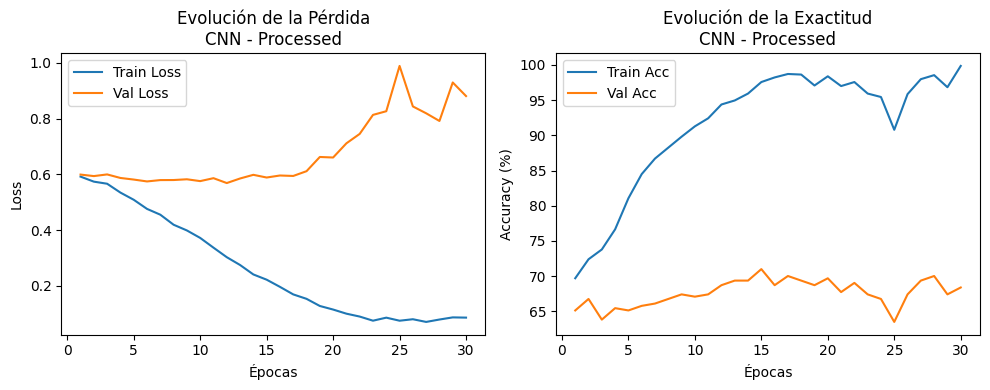


=== Final Training with Best Parameters - UNPROCESSED ===
Epoch 1/30, Train Loss: 0.5988, Train Acc: 0.7029, Val Loss: 0.5973, Val Acc: 0.6743
Epoch 2/30, Train Loss: 0.5812, Train Acc: 0.7224, Val Loss: 0.5916, Val Acc: 0.6906
Epoch 3/30, Train Loss: 0.5746, Train Acc: 0.7592, Val Loss: 0.5914, Val Acc: 0.6645
Epoch 4/30, Train Loss: 0.5456, Train Acc: 0.7682, Val Loss: 0.5821, Val Acc: 0.6873
Epoch 5/30, Train Loss: 0.5291, Train Acc: 0.7853, Val Loss: 0.5741, Val Acc: 0.6906
Epoch 6/30, Train Loss: 0.4946, Train Acc: 0.8000, Val Loss: 0.5653, Val Acc: 0.7036
Epoch 7/30, Train Loss: 0.4792, Train Acc: 0.8229, Val Loss: 0.5680, Val Acc: 0.7003
Epoch 8/30, Train Loss: 0.4428, Train Acc: 0.8424, Val Loss: 0.5665, Val Acc: 0.7199
Epoch 9/30, Train Loss: 0.4106, Train Acc: 0.8792, Val Loss: 0.5571, Val Acc: 0.7231
Epoch 10/30, Train Loss: 0.3641, Train Acc: 0.8743, Val Loss: 0.5843, Val Acc: 0.6840
Epoch 11/30, Train Loss: 0.3353, Train Acc: 0.9176, Val Loss: 0.5615, Val Acc: 0.7231
Epoc

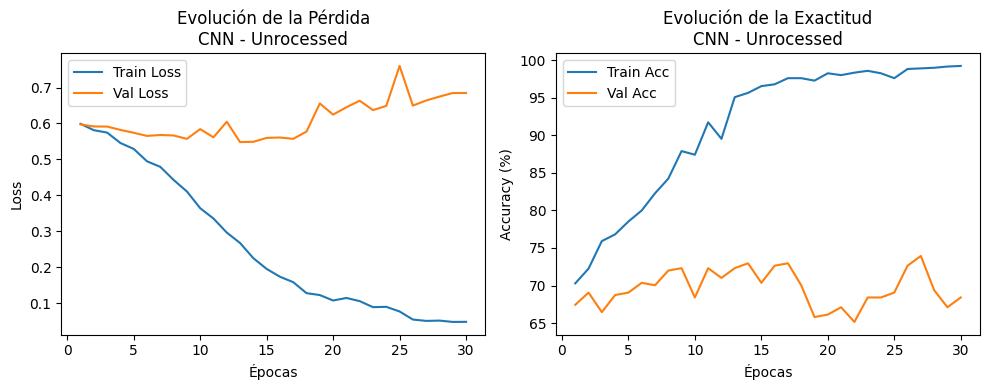


=== Evaluation: Processed Data ===

=== Resultados en Test [Custom CNN - Processed] ===
Test Loss: 1.0075, Test Accuracy: 70.76%


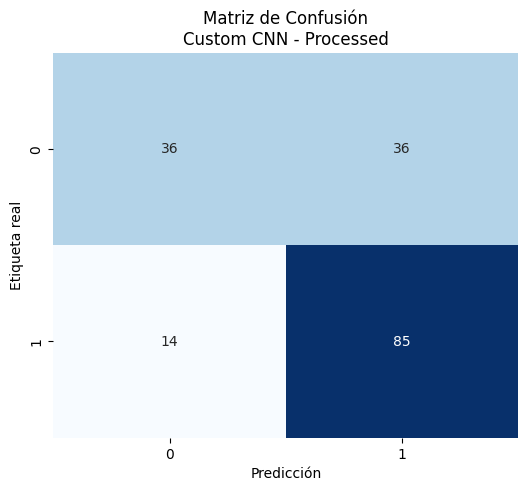


Reporte de Clasificación (Custom CNN - Processed):
              precision    recall  f1-score   support

           0     0.7200    0.5000    0.5902        72
           1     0.7025    0.8586    0.7727        99

    accuracy                         0.7076       171
   macro avg     0.7112    0.6793    0.6814       171
weighted avg     0.7099    0.7076    0.6959       171



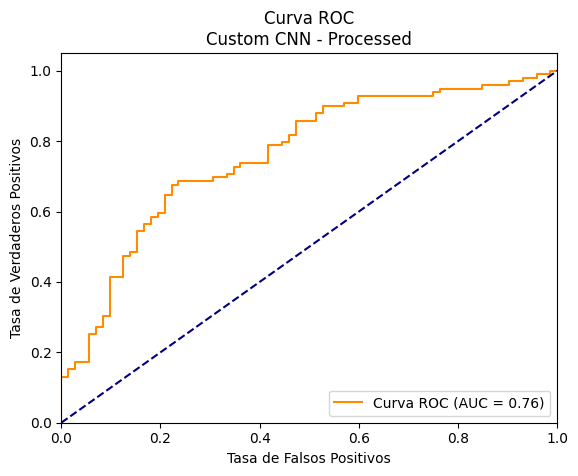


=== Evaluation: Unprocessed Data ===

=== Resultados en Test [Custom CNN - Unprocessed] ===
Test Loss: 0.9150, Test Accuracy: 64.33%


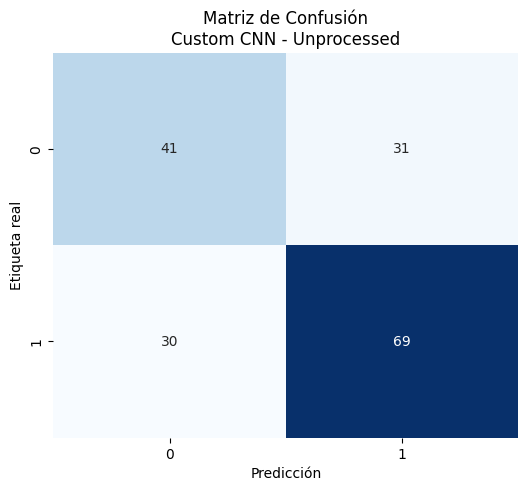


Reporte de Clasificación (Custom CNN - Unprocessed):
              precision    recall  f1-score   support

           0     0.5775    0.5694    0.5734        72
           1     0.6900    0.6970    0.6935        99

    accuracy                         0.6433       171
   macro avg     0.6337    0.6332    0.6334       171
weighted avg     0.6426    0.6433    0.6429       171



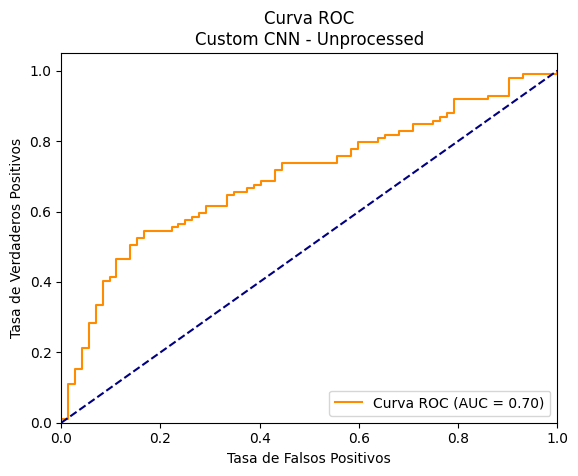

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
from sklearn.model_selection import ParameterGrid, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns



# -------------------------------------------------------------------------------
# 1. DEFINICION MODELO CNN
# -------------------------------------------------------------------------------
class customCNN(nn.Module):
    def __init__(self, num_classes=2, dropout=0.5):
        super(customCNN, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# -------------------------------------------------------------------------------
# 2. FUNCIONES DE ENTRENAMIENTO Y VALIDACIÓN
# -------------------------------------------------------------------------------
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.long().to(device)
        optimizer.zero_grad() # limpia los gradientes acumulados de la iteración anterior para evitar que interfieran en el cálculo actual
        outputs = model(images)
        loss = criterion(outputs, labels) #mide qué tan lejos están las predicciones del modelo de las etiquetas reales
        loss.backward() # calcula los gradientes de los parámetros del modelo con respecto a la pérdida
        optimizer.step() # ajusta los pesos del modelo utilizando los gradientes calculados
        running_loss += loss.item() * images.size(0) #multiplica la pérdida por el tamaño del lote para acumular el total de la época
    return running_loss / len(train_loader.dataset) #pérdida acumulada se divide por el número total de datos en el conjunto de entrenamiento para obtener la pérdida promedio


def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.long().to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    return val_loss / len(val_loader.dataset), accuracy


# -------------------------------------------------------------------------------
# Otra funcion de entrenamiento que guarda losses/accuracy por epoch
# -------------------------------------------------------------------------------
def train_cnn(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    """
    Trains 'model' for 'epochs' epochs and validates each epoch.
    Returns the lists of train losses, val losses, train accuracy, val accuracy.
    """
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs):
        # Train
        train_loss = train_model(model, train_loader, criterion, optimizer, device)

        # train_accuracy
        model.eval()
        all_preds_train = []
        all_labels_train = []
        with torch.no_grad():
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_preds_train.extend(preds.cpu().numpy())
                all_labels_train.extend(labels.cpu().numpy())
        train_accuracy = accuracy_score(all_labels_train, all_preds_train)

        # Validation
        val_loss, val_accuracy = validate_model(model, val_loader, criterion, device)

        #  metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_accuracy * 100.0)
        val_accs.append(val_accuracy * 100.0)

        print(f"Epoch {epoch + 1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    return train_losses, val_losses, train_accs, val_accs


# -------------------------------------------------------------------------------
# 6. Evaluation con todas las metricas y gráficos
# -------------------------------------------------------------------------------
def evaluate_cnn(model, test_loader, criterion, device, model_name="customCNN", data_type="Procesados"):
    """
    Evalúa 'model' en 'test_loader'
    """
    save_dir = "plots"
    os.makedirs(save_dir, exist_ok=True)

    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.long().to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)

            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Para curva ROC
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_probs.extend(probs.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader.dataset)
    avg_test_acc = 100.0 * correct_test / total_test

    print(f"\n=== Resultados en Test [{model_name} - {data_type}] ===")
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.2f}%")

    # matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Matriz de Confusión\n{model_name} - {data_type}")
    plt.xlabel("Predicción")
    plt.ylabel("Etiqueta real")
    filename_cm = f"confusion_matrix_{model_name}_{data_type}.png"
    plt.savefig(os.path.join(save_dir, filename_cm), dpi=300, bbox_inches='tight')
    plt.show()

    # reporte de clasificación
    print(f"\nReporte de Clasificación ({model_name} - {data_type}):")
    print(classification_report(all_labels, all_preds, digits=4))

    # Curva ROC
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             label=f'Curva ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title(f'Curva ROC\n{model_name} - {data_type}')
    plt.legend(loc="lower right")
    filename_roc = f"roc_{model_name}_{data_type}.png"
    plt.savefig(os.path.join(save_dir, filename_roc), dpi=300, bbox_inches='tight')
    plt.show()

    return avg_test_loss, avg_test_acc


# -------------------------------------------------------------------------------
# 7.  Plot Training Evolution
# -------------------------------------------------------------------------------
def plot_training_evolution(
    train_losses,
    val_losses,
    train_accs,
    val_accs,
    model_name="customCNN",
    data_type="Procesados"
):
    save_dir = "plots"
    os.makedirs(save_dir, exist_ok=True)

    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 4))

    # Gráfico de Pérdida
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.title(f'Evolución de la Pérdida\n{model_name} - {data_type}')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()

    # Gráfico de Exactitud
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, label='Train Acc')
    plt.plot(epochs_range, val_accs, label='Val Acc')
    plt.title(f'Evolución de la Exactitud\n{model_name} - {data_type}')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()

    filename = f"training_evolution_{model_name}_{data_type}.png"
    plt.savefig(os.path.join(save_dir, filename), dpi=300, bbox_inches='tight')
    plt.show()


# -------------------------------------------------------------------------------
# 8. Grid Search with Cross-Validation
# -------------------------------------------------------------------------------
def grid_search_cnn(dataset, device, param_grid, n_splits=5, n_epochs=5):
    criterion = nn.CrossEntropyLoss()
    param_combinations = list(ParameterGrid(param_grid))
    best_val_acc = 0.0
    best_config = None
    best_model_state = None

    # labels for StratifiedKFold
    labels = np.array([label for _, label in dataset])

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2001)

    for params in param_combinations:
        val_accuracies = []
        for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
            print(f"Parameter Set: {params}, Fold: {fold+1}")

            # subsets and dataloaders
            train_subset = Subset(dataset, train_idx)
            val_subset = Subset(dataset, val_idx)
            train_loader = DataLoader(train_subset, batch_size=params['batch_size'], shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=params['batch_size'], shuffle=False)

            # inicializamos model and optimizer
            model = customCNN(num_classes=2, dropout=params['dropout']).to(device)
            optimizer = optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

            # Training loop
            for epoch in range(n_epochs):
                train_loss = train_model(model, train_loader, criterion, optimizer, device)
                val_loss, val_acc = validate_model(model, val_loader, criterion, device)
                print(f"Epoch {epoch+1}/{n_epochs}, "
                      f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

            val_accuracies.append(val_acc)

        avg_val_acc = np.mean(val_accuracies)
        print(f"Average Validation Accuracy for Params {params}: {avg_val_acc:.4f}\n")

        if avg_val_acc > best_val_acc:
            best_val_acc = avg_val_acc
            best_config = params
            best_model_state = model.state_dict()

    return best_config, best_val_acc, best_model_state


# -------------------------------------------------------------------------------
# 9.Ejecución
# -------------------------------------------------------------------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    param_grid = {
        'lr': [1e-3, 1e-4, 1e-5],
        'dropout': [0.3, 0.5, 0.7],
        'weight_decay': [1e-3, 1e-5],
        'batch_size': [16, 32]
    }

    # -------------------------------
    # 9.1 Grid Search: Processed Data
    # -------------------------------
    print("=== Grid Search with Cross-Validation - PROCESSED DATA ===")
    best_config, best_val_acc, best_model_state = grid_search_cnn(
        train_processed_dataset, device, param_grid, n_splits=5, n_epochs=5
    )
    print(f"Best Config: {best_config}")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")

    # -------------------------------
    # 9.2 Grid Search: Unprocessed Data
    # -------------------------------
    print("=== Grid Search with Cross-Validation - UNPROCESSED DATA ===")
    best_config_un, best_val_acc_un, best_model_state_un = grid_search_cnn(
        train_unprocessed_dataset, device, param_grid, n_splits=5, n_epochs=5
    )
    print(f"Best Config: {best_config_un}")
    print(f"Best Validation Accuracy: {best_val_acc_un:.4f}")

    # inicializamos el mejor modelo models
    best_model = customCNN(num_classes=2, dropout=best_config['dropout']).to(device)
    best_model.load_state_dict(best_model_state)

    best_model_un = customCNN(num_classes=2, dropout=best_config_un['dropout']).to(device)
    best_model_un.load_state_dict(best_model_state_un)
    # -----------------------------------------------------
    # 9.4 Preparamos los sets procesados y no procesado
    # -----------------------------------------------------
    test_loader = DataLoader(test_processed_dataset, batch_size=best_config['batch_size'], shuffle=False)

    test_loader_un = DataLoader(test_unprocessed_dataset, batch_size=best_config_un['batch_size'], shuffle=False)

    train_loader2 = DataLoader(train2_processed_dataset, batch_size=best_config['batch_size'], shuffle=False)

    train_loader_un2 = DataLoader(train2_unprocessed_dataset, batch_size=best_config_un['batch_size'], shuffle=False)

    val_loader = DataLoader(val_processed_dataset, batch_size=best_config['batch_size'], shuffle=False)

    val_loader_un = DataLoader(val_unprocessed_dataset, batch_size=best_config_un['batch_size'], shuffle=False)



    # -----------------------------------------------------
    # 9.5 evualuamos los modelos y entrenamos con mas epocas
    # -----------------------------------------------------
    criterion = nn.CrossEntropyLoss()

    test_loss, test_acc = validate_model(best_model, test_loader, criterion, device)
    print(f"Processed Test - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

    test_loss_un, test_acc_un = validate_model(best_model_un, test_loader_un, criterion, device)
    print(f"Unprocessed Test - Loss: {test_loss_un:.4f}, Accuracy: {test_acc_un:.4f}")

    print("\n=== Final Training with Best Parameters - PROCESSED ===")

    optimizer = optim.AdamW(best_model.parameters(), lr=best_config['lr'], weight_decay=best_config['weight_decay'])

    # mas epochs
    train_losses, val_losses, train_accs, val_accs = train_cnn(
        model=best_model,
        train_loader=train_loader2,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        epochs=30
    )


    plot_training_evolution(
        train_losses=train_losses,
        val_losses=val_losses,
        train_accs=train_accs,
        val_accs=val_accs,
        model_name="CNN",
        data_type="Processed"
    )

    print("\n=== Final Training with Best Parameters - UNPROCESSED ===")

    optimizer = optim.AdamW(best_model_un.parameters(), lr=best_config_un['lr'], weight_decay=best_config_un['weight_decay'])



    train_losses, val_losses, train_accs, val_accs = train_cnn(
        model=best_model_un,
        train_loader=train_loader_un2,
        val_loader=val_loader_un,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        epochs=30
    )

    plot_training_evolution(
        train_losses=train_losses,
        val_losses=val_losses,
        train_accs=train_accs,
        val_accs=val_accs,
        model_name="CNN",
        data_type="Unrocessed"
    )



    # -----------------------------------------------------
    # 9.8 Final Evaluation
    # -----------------------------------------------------
    print("\n=== Evaluation: Processed Data ===")
    evaluate_cnn(best_model, test_loader, nn.CrossEntropyLoss(), device, "Custom CNN", "Processed")

    print("\n=== Evaluation: Unprocessed Data ===")
    evaluate_cnn(best_model_un, test_loader_un, nn.CrossEntropyLoss(), device, "Custom CNN", "Unprocessed")

# VGG16 Grid Search

=== Grid Search with Cross-Validation - PROCESSED DATA ===
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 1.9735, Val Loss: 0.7690, Val Acc: 0.5342
Epoch 2/5, Train Loss: 0.5747, Val Loss: 0.6621, Val Acc: 0.6189
Epoch 3/5, Train Loss: 0.5528, Val Loss: 0.7496, Val Acc: 0.6352
Epoch 4/5, Train Loss: 0.4712, Val Loss: 0.6997, Val Acc: 0.6645
Epoch 5/5, Train Loss: 0.3718, Val Loss: 0.7596, Val Acc: 0.6482
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 1.4274, Val Loss: 0.6495, Val Acc: 0.6189
Epoch 2/5, Train Loss: 0.5950, Val Loss: 0.5782, Val Acc: 0.6743
Epoch 3/5, Train Loss: 0.5127, Val Loss: 0.6194, Val Acc: 0.6482
Epoch 4/5, Train Loss: 0.4565, Val Loss: 0.6979, Val Acc: 0.6873
Epoch 5/5, Train Loss: 0.4077, Val Loss: 0.6338, Val Acc: 0.6743
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 1.8852, Val Loss: 0.5885, Val Acc: 0.6536
Epoch 2/5, Train Loss: 0.5730, Val Loss: 0.5325, Val Acc: 0.7320
Epoch 3/5, Train Loss: 0.4898, Val Loss: 0.5647, Val Acc: 0.7222
Epoch 4/5, Train Loss: 0.4100, Val Loss: 0.6219, Val Acc: 0.6993
Epoch 5/5, Train Loss: 0.3611, Val Loss: 0.7439, Val Acc: 0.6928
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 1.5551, Val Loss: 0.6124, Val Acc: 0.5980
Epoch 2/5, Train Loss: 0.5825, Val Loss: 0.6344, Val Acc: 0.6438
Epoch 3/5, Train Loss: 0.5035, Val Loss: 0.6058, Val Acc: 0.6732
Epoch 4/5, Train Loss: 0.4333, Val Loss: 0.9600, Val Acc: 0.6405
Epoch 5/5, Train Loss: 0.4195, Val Loss: 0.6775, Val Acc: 0.6667
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.0324, Val Loss: 0.5811, Val Acc: 0.6895
Epoch 2/5, Train Loss: 0.5789, Val Loss: 0.7310, Val Acc: 0.5882
Epoch 3/5, Train Loss: 0.5332, Val Loss: 0.7864, Val Acc: 0.6373
Epoch 4/5, Train Loss: 0.4337, Val Loss: 0.7879, Val Acc: 0.7026
Epoch 5/5, Train Loss: 0.4178, Val Loss: 0.7651, Val Acc: 0.6797
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.001}: 0.6723

Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.4564, Val Loss: 0.5873, Val Acc: 0.6450
Epoch 2/5, Train Loss: 0.5575, Val Loss: 0.6036, Val Acc: 0.6645
Epoch 3/5, Train Loss: 0.5169, Val Loss: 0.6018, Val Acc: 0.7134
Epoch 4/5, Train Loss: 0.4014, Val Loss: 0.6343, Val Acc: 0.6775
Epoch 5/5, Train Loss: 0.3762, Val Loss: 0.7836, Val Acc: 0.6938
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 1.4710, Val Loss: 0.5961, Val Acc: 0.6840
Epoch 2/5, Train Loss: 0.5831, Val Loss: 0.5459, Val Acc: 0.7003
Epoch 3/5, Train Loss: 0.4932, Val Loss: 0.7128, Val Acc: 0.6873
Epoch 4/5, Train Loss: 0.4724, Val Loss: 0.5916, Val Acc: 0.6840
Epoch 5/5, Train Loss: 0.4309, Val Loss: 0.8379, Val Acc: 0.7264
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.9292, Val Loss: 0.5666, Val Acc: 0.7026
Epoch 2/5, Train Loss: 0.5791, Val Loss: 0.5992, Val Acc: 0.6307
Epoch 3/5, Train Loss: 0.5161, Val Loss: 0.5680, Val Acc: 0.6863
Epoch 4/5, Train Loss: 0.4281, Val Loss: 0.6250, Val Acc: 0.7124
Epoch 5/5, Train Loss: 0.3796, Val Loss: 0.6896, Val Acc: 0.6863
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.7530, Val Loss: 0.5954, Val Acc: 0.6405
Epoch 2/5, Train Loss: 0.5550, Val Loss: 0.5951, Val Acc: 0.6438
Epoch 3/5, Train Loss: 0.4974, Val Loss: 0.7249, Val Acc: 0.6438
Epoch 4/5, Train Loss: 0.4314, Val Loss: 0.9304, Val Acc: 0.6373
Epoch 5/5, Train Loss: 0.3819, Val Loss: 0.6279, Val Acc: 0.6732
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.7849, Val Loss: 0.6197, Val Acc: 0.6078
Epoch 2/5, Train Loss: 0.5698, Val Loss: 0.5913, Val Acc: 0.6797
Epoch 3/5, Train Loss: 0.5146, Val Loss: 0.7021, Val Acc: 0.6863
Epoch 4/5, Train Loss: 0.4507, Val Loss: 0.5974, Val Acc: 0.7059
Epoch 5/5, Train Loss: 0.4183, Val Loss: 0.6793, Val Acc: 0.6536
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 1e-05}: 0.6867

Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6331, Val Loss: 0.5970, Val Acc: 0.6482
Epoch 2/5, Train Loss: 0.5143, Val Loss: 0.5692, Val Acc: 0.6906
Epoch 3/5, Train Loss: 0.4396, Val Loss: 0.6123, Val Acc: 0.6417
Epoch 4/5, Train Loss: 0.3807, Val Loss: 0.5673, Val Acc: 0.6840
Epoch 5/5, Train Loss: 0.2995, Val Loss: 0.5778, Val Acc: 0.7199
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6241, Val Loss: 0.5735, Val Acc: 0.7003
Epoch 2/5, Train Loss: 0.5247, Val Loss: 0.5402, Val Acc: 0.7264
Epoch 3/5, Train Loss: 0.4435, Val Loss: 0.5206, Val Acc: 0.7459
Epoch 4/5, Train Loss: 0.3721, Val Loss: 0.5448, Val Acc: 0.7166
Epoch 5/5, Train Loss: 0.3043, Val Loss: 0.6161, Val Acc: 0.7036
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6383, Val Loss: 0.5736, Val Acc: 0.6797
Epoch 2/5, Train Loss: 0.5240, Val Loss: 0.5375, Val Acc: 0.7124
Epoch 3/5, Train Loss: 0.4550, Val Loss: 0.5244, Val Acc: 0.7059
Epoch 4/5, Train Loss: 0.3661, Val Loss: 0.5642, Val Acc: 0.7190
Epoch 5/5, Train Loss: 0.3017, Val Loss: 0.5682, Val Acc: 0.7092
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6224, Val Loss: 0.5828, Val Acc: 0.6667
Epoch 2/5, Train Loss: 0.5142, Val Loss: 0.5656, Val Acc: 0.6797
Epoch 3/5, Train Loss: 0.4302, Val Loss: 0.5871, Val Acc: 0.6830
Epoch 4/5, Train Loss: 0.3700, Val Loss: 0.6009, Val Acc: 0.7059
Epoch 5/5, Train Loss: 0.2790, Val Loss: 0.6100, Val Acc: 0.6928
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6289, Val Loss: 0.5895, Val Acc: 0.6405
Epoch 2/5, Train Loss: 0.5180, Val Loss: 0.5798, Val Acc: 0.6797
Epoch 3/5, Train Loss: 0.4346, Val Loss: 0.5745, Val Acc: 0.6732
Epoch 4/5, Train Loss: 0.3782, Val Loss: 0.5806, Val Acc: 0.7059
Epoch 5/5, Train Loss: 0.2930, Val Loss: 0.6170, Val Acc: 0.6928
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}: 0.7036

Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6342, Val Loss: 0.5758, Val Acc: 0.7068
Epoch 2/5, Train Loss: 0.5344, Val Loss: 0.5715, Val Acc: 0.6840
Epoch 3/5, Train Loss: 0.4534, Val Loss: 0.5559, Val Acc: 0.7036
Epoch 4/5, Train Loss: 0.3735, Val Loss: 0.5904, Val Acc: 0.7134
Epoch 5/5, Train Loss: 0.2985, Val Loss: 0.5797, Val Acc: 0.7134
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6384, Val Loss: 0.5844, Val Acc: 0.6873
Epoch 2/5, Train Loss: 0.5217, Val Loss: 0.5623, Val Acc: 0.7003
Epoch 3/5, Train Loss: 0.4417, Val Loss: 0.5423, Val Acc: 0.7134
Epoch 4/5, Train Loss: 0.3699, Val Loss: 0.5422, Val Acc: 0.7329
Epoch 5/5, Train Loss: 0.2874, Val Loss: 0.6266, Val Acc: 0.7068
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6284, Val Loss: 0.5627, Val Acc: 0.6830
Epoch 2/5, Train Loss: 0.5220, Val Loss: 0.5427, Val Acc: 0.7190
Epoch 3/5, Train Loss: 0.4443, Val Loss: 0.5417, Val Acc: 0.7255
Epoch 4/5, Train Loss: 0.3777, Val Loss: 0.5253, Val Acc: 0.7255
Epoch 5/5, Train Loss: 0.2812, Val Loss: 0.5853, Val Acc: 0.7222
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6230, Val Loss: 0.5839, Val Acc: 0.6667
Epoch 2/5, Train Loss: 0.5220, Val Loss: 0.5720, Val Acc: 0.6863
Epoch 3/5, Train Loss: 0.4491, Val Loss: 0.6761, Val Acc: 0.6438
Epoch 4/5, Train Loss: 0.3625, Val Loss: 0.6301, Val Acc: 0.6536
Epoch 5/5, Train Loss: 0.3073, Val Loss: 0.5977, Val Acc: 0.7059
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6305, Val Loss: 0.5928, Val Acc: 0.6503
Epoch 2/5, Train Loss: 0.5152, Val Loss: 0.5723, Val Acc: 0.6830
Epoch 3/5, Train Loss: 0.4473, Val Loss: 0.5633, Val Acc: 0.6993
Epoch 4/5, Train Loss: 0.3722, Val Loss: 0.5642, Val Acc: 0.7092
Epoch 5/5, Train Loss: 0.3104, Val Loss: 0.5773, Val Acc: 0.7092
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}: 0.7115

Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 4.5502, Val Loss: 0.6049, Val Acc: 0.6612
Epoch 2/5, Train Loss: 0.6427, Val Loss: 0.5741, Val Acc: 0.6808
Epoch 3/5, Train Loss: 0.6288, Val Loss: 0.7719, Val Acc: 0.6482
Epoch 4/5, Train Loss: 0.5900, Val Loss: 0.5831, Val Acc: 0.6808
Epoch 5/5, Train Loss: 0.5493, Val Loss: 0.5749, Val Acc: 0.6775
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 1.7734, Val Loss: 0.6238, Val Acc: 0.6612
Epoch 2/5, Train Loss: 0.7050, Val Loss: 0.6154, Val Acc: 0.6580
Epoch 3/5, Train Loss: 0.6798, Val Loss: 0.6429, Val Acc: 0.6384
Epoch 4/5, Train Loss: 0.6540, Val Loss: 0.6585, Val Acc: 0.6678
Epoch 5/5, Train Loss: 0.5923, Val Loss: 0.5946, Val Acc: 0.6678
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.9500, Val Loss: 0.7231, Val Acc: 0.6046
Epoch 2/5, Train Loss: 0.6981, Val Loss: 0.7071, Val Acc: 0.6536
Epoch 3/5, Train Loss: 0.6442, Val Loss: 0.6776, Val Acc: 0.6471
Epoch 4/5, Train Loss: 0.6297, Val Loss: 0.5966, Val Acc: 0.7026
Epoch 5/5, Train Loss: 0.5768, Val Loss: 0.7780, Val Acc: 0.6601
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.6128, Val Loss: 0.5960, Val Acc: 0.6797
Epoch 2/5, Train Loss: 0.6575, Val Loss: 1.0791, Val Acc: 0.5523
Epoch 3/5, Train Loss: 0.6412, Val Loss: 0.6091, Val Acc: 0.6471
Epoch 4/5, Train Loss: 0.5284, Val Loss: 0.8443, Val Acc: 0.6144
Epoch 5/5, Train Loss: 0.5445, Val Loss: 0.6538, Val Acc: 0.6569
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.3215, Val Loss: 0.5928, Val Acc: 0.6732
Epoch 2/5, Train Loss: 0.6572, Val Loss: 0.7093, Val Acc: 0.5980
Epoch 3/5, Train Loss: 0.6398, Val Loss: 0.7009, Val Acc: 0.5948
Epoch 4/5, Train Loss: 0.6030, Val Loss: 0.6114, Val Acc: 0.6830
Epoch 5/5, Train Loss: 0.5969, Val Loss: 0.6101, Val Acc: 0.6993
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 0.001}: 0.6723

Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.6600, Val Loss: 0.6172, Val Acc: 0.6547
Epoch 2/5, Train Loss: 0.6774, Val Loss: 0.5819, Val Acc: 0.6873
Epoch 3/5, Train Loss: 0.6619, Val Loss: 0.5922, Val Acc: 0.6547
Epoch 4/5, Train Loss: 0.6034, Val Loss: 0.6250, Val Acc: 0.6547
Epoch 5/5, Train Loss: 0.5180, Val Loss: 0.6244, Val Acc: 0.6482
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.8518, Val Loss: 0.7988, Val Acc: 0.5505
Epoch 2/5, Train Loss: 0.6742, Val Loss: 0.6091, Val Acc: 0.6026
Epoch 3/5, Train Loss: 0.5996, Val Loss: 0.6046, Val Acc: 0.6547
Epoch 4/5, Train Loss: 0.5968, Val Loss: 0.6700, Val Acc: 0.6352
Epoch 5/5, Train Loss: 0.6148, Val Loss: 0.5809, Val Acc: 0.7036
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.2205, Val Loss: 0.5771, Val Acc: 0.6928
Epoch 2/5, Train Loss: 0.6440, Val Loss: 0.6491, Val Acc: 0.6373
Epoch 3/5, Train Loss: 0.6387, Val Loss: 0.5879, Val Acc: 0.6732
Epoch 4/5, Train Loss: 0.6523, Val Loss: 0.5564, Val Acc: 0.7157
Epoch 5/5, Train Loss: 0.6023, Val Loss: 0.6844, Val Acc: 0.6078
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 3.3252, Val Loss: 0.6751, Val Acc: 0.6176
Epoch 2/5, Train Loss: 0.6496, Val Loss: 0.6241, Val Acc: 0.6438
Epoch 3/5, Train Loss: 0.6048, Val Loss: 0.6789, Val Acc: 0.6144
Epoch 4/5, Train Loss: 0.5938, Val Loss: 0.6747, Val Acc: 0.6503
Epoch 5/5, Train Loss: 0.5818, Val Loss: 0.5966, Val Acc: 0.6895
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.0979, Val Loss: 0.6544, Val Acc: 0.6209
Epoch 2/5, Train Loss: 0.6265, Val Loss: 1.0364, Val Acc: 0.5131
Epoch 3/5, Train Loss: 0.6557, Val Loss: 0.7306, Val Acc: 0.6667
Epoch 4/5, Train Loss: 0.6021, Val Loss: 0.6018, Val Acc: 0.6667
Epoch 5/5, Train Loss: 0.6056, Val Loss: 0.6651, Val Acc: 0.7092
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 1e-05}: 0.6717

Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6412, Val Loss: 0.5873, Val Acc: 0.6580
Epoch 2/5, Train Loss: 0.5569, Val Loss: 0.5618, Val Acc: 0.6906
Epoch 3/5, Train Loss: 0.5164, Val Loss: 0.5597, Val Acc: 0.6775
Epoch 4/5, Train Loss: 0.4604, Val Loss: 0.5510, Val Acc: 0.6938
Epoch 5/5, Train Loss: 0.4146, Val Loss: 0.6133, Val Acc: 0.6450
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6461, Val Loss: 0.5809, Val Acc: 0.6873
Epoch 2/5, Train Loss: 0.5630, Val Loss: 0.5881, Val Acc: 0.6840
Epoch 3/5, Train Loss: 0.5088, Val Loss: 0.5328, Val Acc: 0.7068
Epoch 4/5, Train Loss: 0.4701, Val Loss: 0.5460, Val Acc: 0.7134
Epoch 5/5, Train Loss: 0.4165, Val Loss: 0.5250, Val Acc: 0.7329
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6511, Val Loss: 0.5791, Val Acc: 0.6699
Epoch 2/5, Train Loss: 0.5652, Val Loss: 0.5465, Val Acc: 0.7092
Epoch 3/5, Train Loss: 0.5111, Val Loss: 0.5255, Val Acc: 0.7484
Epoch 4/5, Train Loss: 0.4640, Val Loss: 0.5463, Val Acc: 0.6961
Epoch 5/5, Train Loss: 0.4147, Val Loss: 0.5816, Val Acc: 0.7092
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6394, Val Loss: 0.6053, Val Acc: 0.6503
Epoch 2/5, Train Loss: 0.5554, Val Loss: 0.5849, Val Acc: 0.6928
Epoch 3/5, Train Loss: 0.5113, Val Loss: 0.5596, Val Acc: 0.6765
Epoch 4/5, Train Loss: 0.4542, Val Loss: 0.5703, Val Acc: 0.6863
Epoch 5/5, Train Loss: 0.4206, Val Loss: 0.5641, Val Acc: 0.7124
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6396, Val Loss: 0.5996, Val Acc: 0.6634
Epoch 2/5, Train Loss: 0.5568, Val Loss: 0.5773, Val Acc: 0.6863
Epoch 3/5, Train Loss: 0.5130, Val Loss: 0.5708, Val Acc: 0.6863
Epoch 4/5, Train Loss: 0.4585, Val Loss: 0.5728, Val Acc: 0.6961
Epoch 5/5, Train Loss: 0.4176, Val Loss: 0.5779, Val Acc: 0.7026
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}: 0.7004

Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6403, Val Loss: 0.5849, Val Acc: 0.6743
Epoch 2/5, Train Loss: 0.5590, Val Loss: 0.5637, Val Acc: 0.6808
Epoch 3/5, Train Loss: 0.5018, Val Loss: 0.5707, Val Acc: 0.7003
Epoch 4/5, Train Loss: 0.4665, Val Loss: 0.5414, Val Acc: 0.7199
Epoch 5/5, Train Loss: 0.4229, Val Loss: 0.5748, Val Acc: 0.6678
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6491, Val Loss: 0.5873, Val Acc: 0.6906
Epoch 2/5, Train Loss: 0.5595, Val Loss: 0.5681, Val Acc: 0.7036
Epoch 3/5, Train Loss: 0.5083, Val Loss: 0.5950, Val Acc: 0.6971
Epoch 4/5, Train Loss: 0.4582, Val Loss: 0.5370, Val Acc: 0.7166
Epoch 5/5, Train Loss: 0.4237, Val Loss: 0.5469, Val Acc: 0.7134
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6539, Val Loss: 0.5954, Val Acc: 0.6405
Epoch 2/5, Train Loss: 0.5588, Val Loss: 0.5494, Val Acc: 0.7222
Epoch 3/5, Train Loss: 0.5267, Val Loss: 0.5332, Val Acc: 0.7190
Epoch 4/5, Train Loss: 0.4744, Val Loss: 0.5955, Val Acc: 0.6634
Epoch 5/5, Train Loss: 0.4146, Val Loss: 0.5491, Val Acc: 0.6830
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6330, Val Loss: 0.6239, Val Acc: 0.6242
Epoch 2/5, Train Loss: 0.5673, Val Loss: 0.5797, Val Acc: 0.6732
Epoch 3/5, Train Loss: 0.5081, Val Loss: 0.5781, Val Acc: 0.6895
Epoch 4/5, Train Loss: 0.4503, Val Loss: 0.5668, Val Acc: 0.6961
Epoch 5/5, Train Loss: 0.4039, Val Loss: 0.5763, Val Acc: 0.7124
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6471, Val Loss: 0.6013, Val Acc: 0.6503
Epoch 2/5, Train Loss: 0.5586, Val Loss: 0.5868, Val Acc: 0.6699
Epoch 3/5, Train Loss: 0.5115, Val Loss: 0.5694, Val Acc: 0.7026
Epoch 4/5, Train Loss: 0.4601, Val Loss: 0.5762, Val Acc: 0.6961
Epoch 5/5, Train Loss: 0.4183, Val Loss: 0.5963, Val Acc: 0.6895
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}: 0.6932

Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 6.3142, Val Loss: 1.6026, Val Acc: 0.6059
Epoch 2/5, Train Loss: 1.2939, Val Loss: 1.2409, Val Acc: 0.5505
Epoch 3/5, Train Loss: 0.9065, Val Loss: 0.6982, Val Acc: 0.6352
Epoch 4/5, Train Loss: 0.9188, Val Loss: 0.6678, Val Acc: 0.6156
Epoch 5/5, Train Loss: 0.9937, Val Loss: 0.6447, Val Acc: 0.6482
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 7.2691, Val Loss: 0.7896, Val Acc: 0.6645
Epoch 2/5, Train Loss: 1.0462, Val Loss: 0.5795, Val Acc: 0.6938
Epoch 3/5, Train Loss: 1.0797, Val Loss: 0.7387, Val Acc: 0.6417
Epoch 4/5, Train Loss: 1.0549, Val Loss: 0.6502, Val Acc: 0.6515
Epoch 5/5, Train Loss: 0.8657, Val Loss: 0.6544, Val Acc: 0.6743
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 6.3444, Val Loss: 0.6772, Val Acc: 0.7026
Epoch 2/5, Train Loss: 1.2680, Val Loss: 0.9675, Val Acc: 0.5948
Epoch 3/5, Train Loss: 1.1007, Val Loss: 0.5696, Val Acc: 0.6797
Epoch 4/5, Train Loss: 0.9339, Val Loss: 0.6108, Val Acc: 0.6503
Epoch 5/5, Train Loss: 0.9190, Val Loss: 0.6572, Val Acc: 0.6634
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 7.6312, Val Loss: 1.1631, Val Acc: 0.5882
Epoch 2/5, Train Loss: 1.3223, Val Loss: 0.8688, Val Acc: 0.6275
Epoch 3/5, Train Loss: 0.8935, Val Loss: 0.6344, Val Acc: 0.6471
Epoch 4/5, Train Loss: 0.8766, Val Loss: 0.6434, Val Acc: 0.6111
Epoch 5/5, Train Loss: 0.8195, Val Loss: 0.6087, Val Acc: 0.6373
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 8.1478, Val Loss: 0.9600, Val Acc: 0.6667
Epoch 2/5, Train Loss: 1.5530, Val Loss: 0.6989, Val Acc: 0.6471
Epoch 3/5, Train Loss: 0.9830, Val Loss: 0.6757, Val Acc: 0.6634
Epoch 4/5, Train Loss: 0.7809, Val Loss: 0.6867, Val Acc: 0.6634
Epoch 5/5, Train Loss: 0.7772, Val Loss: 0.7338, Val Acc: 0.6307
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 0.001}: 0.6508

Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 7.3436, Val Loss: 1.2883, Val Acc: 0.6156
Epoch 2/5, Train Loss: 1.3172, Val Loss: 0.8352, Val Acc: 0.6352
Epoch 3/5, Train Loss: 0.9127, Val Loss: 0.6522, Val Acc: 0.6645
Epoch 4/5, Train Loss: 0.8589, Val Loss: 0.6357, Val Acc: 0.6384
Epoch 5/5, Train Loss: 0.7697, Val Loss: 0.6812, Val Acc: 0.6450
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 6.4271, Val Loss: 1.4176, Val Acc: 0.5928
Epoch 2/5, Train Loss: 1.3434, Val Loss: 0.7294, Val Acc: 0.6384
Epoch 3/5, Train Loss: 0.9942, Val Loss: 0.8072, Val Acc: 0.6384
Epoch 4/5, Train Loss: 1.0300, Val Loss: 0.6418, Val Acc: 0.6678
Epoch 5/5, Train Loss: 1.1570, Val Loss: 0.6419, Val Acc: 0.6287
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 5.5622, Val Loss: 0.8119, Val Acc: 0.5882
Epoch 2/5, Train Loss: 1.0170, Val Loss: 0.7738, Val Acc: 0.6176
Epoch 3/5, Train Loss: 0.9135, Val Loss: 0.6280, Val Acc: 0.6503
Epoch 4/5, Train Loss: 0.8675, Val Loss: 0.5977, Val Acc: 0.6667
Epoch 5/5, Train Loss: 1.0790, Val Loss: 0.5855, Val Acc: 0.6536
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 6.8054, Val Loss: 0.7666, Val Acc: 0.5621
Epoch 2/5, Train Loss: 0.8192, Val Loss: 0.6940, Val Acc: 0.5980
Epoch 3/5, Train Loss: 0.8609, Val Loss: 0.6844, Val Acc: 0.6438
Epoch 4/5, Train Loss: 0.8755, Val Loss: 0.6280, Val Acc: 0.6373
Epoch 5/5, Train Loss: 1.0106, Val Loss: 0.6278, Val Acc: 0.6144
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 10.7049, Val Loss: 3.0289, Val Acc: 0.6275
Epoch 2/5, Train Loss: 2.9762, Val Loss: 1.9291, Val Acc: 0.6209
Epoch 3/5, Train Loss: 1.2249, Val Loss: 0.6746, Val Acc: 0.6569
Epoch 4/5, Train Loss: 0.8250, Val Loss: 0.6019, Val Acc: 0.6830
Epoch 5/5, Train Loss: 0.7556, Val Loss: 0.6557, Val Acc: 0.6732
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 1e-05}: 0.6430

Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6769, Val Loss: 0.6098, Val Acc: 0.6808
Epoch 2/5, Train Loss: 0.6239, Val Loss: 0.5831, Val Acc: 0.7036
Epoch 3/5, Train Loss: 0.5866, Val Loss: 0.5827, Val Acc: 0.6612
Epoch 4/5, Train Loss: 0.5540, Val Loss: 0.5734, Val Acc: 0.6808
Epoch 5/5, Train Loss: 0.5372, Val Loss: 0.5599, Val Acc: 0.6840
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6787, Val Loss: 0.6030, Val Acc: 0.6873
Epoch 2/5, Train Loss: 0.6202, Val Loss: 0.5811, Val Acc: 0.6840
Epoch 3/5, Train Loss: 0.5806, Val Loss: 0.5760, Val Acc: 0.6873
Epoch 4/5, Train Loss: 0.5685, Val Loss: 0.5622, Val Acc: 0.7166
Epoch 5/5, Train Loss: 0.5447, Val Loss: 0.5762, Val Acc: 0.7166
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6975, Val Loss: 0.6157, Val Acc: 0.6340
Epoch 2/5, Train Loss: 0.6240, Val Loss: 0.5811, Val Acc: 0.6503
Epoch 3/5, Train Loss: 0.5902, Val Loss: 0.5568, Val Acc: 0.7092
Epoch 4/5, Train Loss: 0.5657, Val Loss: 0.5456, Val Acc: 0.7124
Epoch 5/5, Train Loss: 0.5379, Val Loss: 0.5390, Val Acc: 0.7320
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6677, Val Loss: 0.6273, Val Acc: 0.6242
Epoch 2/5, Train Loss: 0.5972, Val Loss: 0.6022, Val Acc: 0.6438
Epoch 3/5, Train Loss: 0.6111, Val Loss: 0.6002, Val Acc: 0.6438
Epoch 4/5, Train Loss: 0.5542, Val Loss: 0.5826, Val Acc: 0.6699
Epoch 5/5, Train Loss: 0.5240, Val Loss: 0.5808, Val Acc: 0.6667
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6799, Val Loss: 0.6146, Val Acc: 0.6340
Epoch 2/5, Train Loss: 0.6002, Val Loss: 0.5847, Val Acc: 0.6797
Epoch 3/5, Train Loss: 0.5856, Val Loss: 0.5874, Val Acc: 0.6830
Epoch 4/5, Train Loss: 0.5383, Val Loss: 0.5767, Val Acc: 0.6961
Epoch 5/5, Train Loss: 0.5461, Val Loss: 0.5753, Val Acc: 0.6863
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}: 0.6971

Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6875, Val Loss: 0.6320, Val Acc: 0.5896
Epoch 2/5, Train Loss: 0.6359, Val Loss: 0.5806, Val Acc: 0.6808
Epoch 3/5, Train Loss: 0.5923, Val Loss: 0.5634, Val Acc: 0.7036
Epoch 4/5, Train Loss: 0.5846, Val Loss: 0.5578, Val Acc: 0.7068
Epoch 5/5, Train Loss: 0.5422, Val Loss: 0.5540, Val Acc: 0.7134
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6872, Val Loss: 0.6395, Val Acc: 0.5831
Epoch 2/5, Train Loss: 0.6206, Val Loss: 0.5797, Val Acc: 0.6840
Epoch 3/5, Train Loss: 0.5845, Val Loss: 0.5684, Val Acc: 0.7199
Epoch 4/5, Train Loss: 0.5655, Val Loss: 0.5483, Val Acc: 0.7296
Epoch 5/5, Train Loss: 0.5500, Val Loss: 0.5487, Val Acc: 0.7199
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6827, Val Loss: 0.6159, Val Acc: 0.5980
Epoch 2/5, Train Loss: 0.6323, Val Loss: 0.5855, Val Acc: 0.6601
Epoch 3/5, Train Loss: 0.5902, Val Loss: 0.5530, Val Acc: 0.6895
Epoch 4/5, Train Loss: 0.5682, Val Loss: 0.5552, Val Acc: 0.6830
Epoch 5/5, Train Loss: 0.5372, Val Loss: 0.5667, Val Acc: 0.6503
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6723, Val Loss: 0.6577, Val Acc: 0.5817
Epoch 2/5, Train Loss: 0.6131, Val Loss: 0.5993, Val Acc: 0.6601
Epoch 3/5, Train Loss: 0.5767, Val Loss: 0.5921, Val Acc: 0.6307
Epoch 4/5, Train Loss: 0.5567, Val Loss: 0.5751, Val Acc: 0.6667
Epoch 5/5, Train Loss: 0.5407, Val Loss: 0.5820, Val Acc: 0.6732
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6832, Val Loss: 0.6263, Val Acc: 0.5948
Epoch 2/5, Train Loss: 0.6098, Val Loss: 0.5895, Val Acc: 0.6699
Epoch 3/5, Train Loss: 0.5880, Val Loss: 0.5867, Val Acc: 0.6601
Epoch 4/5, Train Loss: 0.5497, Val Loss: 0.5780, Val Acc: 0.6895
Epoch 5/5, Train Loss: 0.5365, Val Loss: 0.5729, Val Acc: 0.6895
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}: 0.6893

Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 3.4297, Val Loss: 0.5950, Val Acc: 0.6156
Epoch 2/5, Train Loss: 0.5652, Val Loss: 0.5707, Val Acc: 0.6710
Epoch 3/5, Train Loss: 0.5050, Val Loss: 0.6045, Val Acc: 0.7199
Epoch 4/5, Train Loss: 0.4414, Val Loss: 0.6616, Val Acc: 0.6450
Epoch 5/5, Train Loss: 0.3472, Val Loss: 1.0211, Val Acc: 0.6254
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.5008, Val Loss: 0.5738, Val Acc: 0.6906
Epoch 2/5, Train Loss: 0.5717, Val Loss: 0.5516, Val Acc: 0.6906
Epoch 3/5, Train Loss: 0.5286, Val Loss: 0.5650, Val Acc: 0.6645
Epoch 4/5, Train Loss: 0.4326, Val Loss: 0.6978, Val Acc: 0.6971
Epoch 5/5, Train Loss: 0.3713, Val Loss: 0.5968, Val Acc: 0.7362
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 3.5395, Val Loss: 0.5919, Val Acc: 0.6373
Epoch 2/5, Train Loss: 0.5633, Val Loss: 0.6136, Val Acc: 0.6438
Epoch 3/5, Train Loss: 0.4937, Val Loss: 0.5271, Val Acc: 0.7386
Epoch 4/5, Train Loss: 0.4202, Val Loss: 0.7274, Val Acc: 0.6373
Epoch 5/5, Train Loss: 0.3355, Val Loss: 0.6644, Val Acc: 0.7288
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.7340, Val Loss: 0.6335, Val Acc: 0.6275
Epoch 2/5, Train Loss: 0.5710, Val Loss: 0.6372, Val Acc: 0.6405
Epoch 3/5, Train Loss: 0.4863, Val Loss: 0.6377, Val Acc: 0.6765
Epoch 4/5, Train Loss: 0.4214, Val Loss: 0.6941, Val Acc: 0.6569
Epoch 5/5, Train Loss: 0.3720, Val Loss: 0.7070, Val Acc: 0.6667
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.7146, Val Loss: 0.6661, Val Acc: 0.6013
Epoch 2/5, Train Loss: 0.5545, Val Loss: 0.6267, Val Acc: 0.6732
Epoch 3/5, Train Loss: 0.4704, Val Loss: 0.5876, Val Acc: 0.6765
Epoch 4/5, Train Loss: 0.3891, Val Loss: 0.6471, Val Acc: 0.6699
Epoch 5/5, Train Loss: 0.3839, Val Loss: 0.6754, Val Acc: 0.7320
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.001}: 0.6978

Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 3.4479, Val Loss: 0.5996, Val Acc: 0.6775
Epoch 2/5, Train Loss: 0.5731, Val Loss: 0.5906, Val Acc: 0.6319
Epoch 3/5, Train Loss: 0.4781, Val Loss: 0.7912, Val Acc: 0.6124
Epoch 4/5, Train Loss: 0.4265, Val Loss: 0.6898, Val Acc: 0.7003
Epoch 5/5, Train Loss: 0.3536, Val Loss: 0.6954, Val Acc: 0.6384
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.5282, Val Loss: 0.6014, Val Acc: 0.6547
Epoch 2/5, Train Loss: 0.5537, Val Loss: 0.8533, Val Acc: 0.5831
Epoch 3/5, Train Loss: 0.5251, Val Loss: 0.5253, Val Acc: 0.7101
Epoch 4/5, Train Loss: 0.4097, Val Loss: 0.5558, Val Acc: 0.7036
Epoch 5/5, Train Loss: 0.3323, Val Loss: 0.6972, Val Acc: 0.6743
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 3.3240, Val Loss: 0.6094, Val Acc: 0.6307
Epoch 2/5, Train Loss: 0.5554, Val Loss: 0.6074, Val Acc: 0.6699
Epoch 3/5, Train Loss: 0.4597, Val Loss: 0.5481, Val Acc: 0.7157
Epoch 4/5, Train Loss: 0.3915, Val Loss: 0.5868, Val Acc: 0.7059
Epoch 5/5, Train Loss: 0.3430, Val Loss: 0.7260, Val Acc: 0.6536
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 3.6833, Val Loss: 0.6236, Val Acc: 0.6242
Epoch 2/5, Train Loss: 0.5815, Val Loss: 0.6083, Val Acc: 0.6601
Epoch 3/5, Train Loss: 0.4999, Val Loss: 0.6526, Val Acc: 0.6144
Epoch 4/5, Train Loss: 0.4416, Val Loss: 0.7484, Val Acc: 0.6699
Epoch 5/5, Train Loss: 0.3326, Val Loss: 0.7242, Val Acc: 0.6993
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 3.2143, Val Loss: 0.6447, Val Acc: 0.5980
Epoch 2/5, Train Loss: 0.5793, Val Loss: 0.5670, Val Acc: 0.6830
Epoch 3/5, Train Loss: 0.4911, Val Loss: 0.5662, Val Acc: 0.7059
Epoch 4/5, Train Loss: 0.4353, Val Loss: 0.6760, Val Acc: 0.6993
Epoch 5/5, Train Loss: 0.3848, Val Loss: 1.0347, Val Acc: 0.5948
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 1e-05}: 0.6521

Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6384, Val Loss: 0.5856, Val Acc: 0.6938
Epoch 2/5, Train Loss: 0.5314, Val Loss: 0.5598, Val Acc: 0.6808
Epoch 3/5, Train Loss: 0.4698, Val Loss: 0.5648, Val Acc: 0.6580
Epoch 4/5, Train Loss: 0.4058, Val Loss: 0.5722, Val Acc: 0.7036
Epoch 5/5, Train Loss: 0.3618, Val Loss: 0.6035, Val Acc: 0.6612
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6450, Val Loss: 0.5864, Val Acc: 0.6840
Epoch 2/5, Train Loss: 0.5363, Val Loss: 0.5597, Val Acc: 0.7296
Epoch 3/5, Train Loss: 0.4802, Val Loss: 0.5375, Val Acc: 0.7231
Epoch 4/5, Train Loss: 0.4219, Val Loss: 0.5301, Val Acc: 0.7329
Epoch 5/5, Train Loss: 0.3588, Val Loss: 0.6456, Val Acc: 0.6710
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6287, Val Loss: 0.5657, Val Acc: 0.7059
Epoch 2/5, Train Loss: 0.5418, Val Loss: 0.5415, Val Acc: 0.7320
Epoch 3/5, Train Loss: 0.4788, Val Loss: 0.5349, Val Acc: 0.7124
Epoch 4/5, Train Loss: 0.4153, Val Loss: 0.5187, Val Acc: 0.7386
Epoch 5/5, Train Loss: 0.3673, Val Loss: 0.5303, Val Acc: 0.7353
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6365, Val Loss: 0.6076, Val Acc: 0.6601
Epoch 2/5, Train Loss: 0.5241, Val Loss: 0.5881, Val Acc: 0.6601
Epoch 3/5, Train Loss: 0.4588, Val Loss: 0.5729, Val Acc: 0.6765
Epoch 4/5, Train Loss: 0.3969, Val Loss: 0.5712, Val Acc: 0.7059
Epoch 5/5, Train Loss: 0.3338, Val Loss: 0.6112, Val Acc: 0.6797
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6344, Val Loss: 0.5993, Val Acc: 0.6438
Epoch 2/5, Train Loss: 0.5239, Val Loss: 0.5840, Val Acc: 0.6732
Epoch 3/5, Train Loss: 0.4744, Val Loss: 0.6051, Val Acc: 0.6797
Epoch 4/5, Train Loss: 0.4134, Val Loss: 0.5580, Val Acc: 0.6961
Epoch 5/5, Train Loss: 0.3438, Val Loss: 0.5753, Val Acc: 0.6863
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}: 0.6867

Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6350, Val Loss: 0.5856, Val Acc: 0.6840
Epoch 2/5, Train Loss: 0.5508, Val Loss: 0.5798, Val Acc: 0.6775
Epoch 3/5, Train Loss: 0.4707, Val Loss: 0.5570, Val Acc: 0.7101
Epoch 4/5, Train Loss: 0.4113, Val Loss: 0.5564, Val Acc: 0.6873
Epoch 5/5, Train Loss: 0.3621, Val Loss: 0.5482, Val Acc: 0.7134
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6345, Val Loss: 0.5814, Val Acc: 0.6938
Epoch 2/5, Train Loss: 0.5428, Val Loss: 0.5485, Val Acc: 0.7264
Epoch 3/5, Train Loss: 0.4761, Val Loss: 0.5295, Val Acc: 0.7329
Epoch 4/5, Train Loss: 0.4209, Val Loss: 0.5462, Val Acc: 0.7264
Epoch 5/5, Train Loss: 0.3476, Val Loss: 0.5289, Val Acc: 0.7199
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6432, Val Loss: 0.5737, Val Acc: 0.7026
Epoch 2/5, Train Loss: 0.5373, Val Loss: 0.5530, Val Acc: 0.6993
Epoch 3/5, Train Loss: 0.4858, Val Loss: 0.5413, Val Acc: 0.6895
Epoch 4/5, Train Loss: 0.4236, Val Loss: 0.6021, Val Acc: 0.6503
Epoch 5/5, Train Loss: 0.3579, Val Loss: 0.5240, Val Acc: 0.7288
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6307, Val Loss: 0.6119, Val Acc: 0.6275
Epoch 2/5, Train Loss: 0.5270, Val Loss: 0.5785, Val Acc: 0.6699
Epoch 3/5, Train Loss: 0.4615, Val Loss: 0.5707, Val Acc: 0.6928
Epoch 4/5, Train Loss: 0.3996, Val Loss: 0.6249, Val Acc: 0.6601
Epoch 5/5, Train Loss: 0.3313, Val Loss: 0.5893, Val Acc: 0.7124
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6400, Val Loss: 0.6119, Val Acc: 0.6601
Epoch 2/5, Train Loss: 0.5352, Val Loss: 0.5932, Val Acc: 0.6797
Epoch 3/5, Train Loss: 0.4731, Val Loss: 0.5655, Val Acc: 0.6928
Epoch 4/5, Train Loss: 0.4124, Val Loss: 0.6048, Val Acc: 0.6895
Epoch 5/5, Train Loss: 0.3571, Val Loss: 0.5926, Val Acc: 0.6765
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}: 0.7102

Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 3.3522, Val Loss: 0.6088, Val Acc: 0.6254
Epoch 2/5, Train Loss: 0.5993, Val Loss: 0.6100, Val Acc: 0.6971
Epoch 3/5, Train Loss: 0.5464, Val Loss: 0.7239, Val Acc: 0.6612
Epoch 4/5, Train Loss: 0.5161, Val Loss: 0.5880, Val Acc: 0.6938
Epoch 5/5, Train Loss: 0.4333, Val Loss: 0.7344, Val Acc: 0.6743
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.2852, Val Loss: 0.6326, Val Acc: 0.6319
Epoch 2/5, Train Loss: 0.5957, Val Loss: 0.6465, Val Acc: 0.6124
Epoch 3/5, Train Loss: 0.5688, Val Loss: 0.6235, Val Acc: 0.6482
Epoch 4/5, Train Loss: 0.5450, Val Loss: 0.5620, Val Acc: 0.6710
Epoch 5/5, Train Loss: 0.4404, Val Loss: 0.6107, Val Acc: 0.7166
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 4.1441, Val Loss: 0.5817, Val Acc: 0.6569
Epoch 2/5, Train Loss: 0.6007, Val Loss: 0.5707, Val Acc: 0.6928
Epoch 3/5, Train Loss: 0.5807, Val Loss: 0.5454, Val Acc: 0.6699
Epoch 4/5, Train Loss: 0.4647, Val Loss: 0.5643, Val Acc: 0.7320
Epoch 5/5, Train Loss: 0.4612, Val Loss: 0.5438, Val Acc: 0.7124
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 3.5892, Val Loss: 0.6183, Val Acc: 0.6340
Epoch 2/5, Train Loss: 0.5976, Val Loss: 0.6454, Val Acc: 0.6144
Epoch 3/5, Train Loss: 0.5551, Val Loss: 0.6594, Val Acc: 0.6471
Epoch 4/5, Train Loss: 0.5195, Val Loss: 0.5891, Val Acc: 0.6797
Epoch 5/5, Train Loss: 0.4439, Val Loss: 0.7537, Val Acc: 0.5850
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 3.8154, Val Loss: 0.6244, Val Acc: 0.5980
Epoch 2/5, Train Loss: 0.5763, Val Loss: 0.6151, Val Acc: 0.6275
Epoch 3/5, Train Loss: 0.5358, Val Loss: 0.5954, Val Acc: 0.6961
Epoch 4/5, Train Loss: 0.5085, Val Loss: 0.6718, Val Acc: 0.6993
Epoch 5/5, Train Loss: 0.4606, Val Loss: 0.6435, Val Acc: 0.6961
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 0.001}: 0.6769

Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 3.2201, Val Loss: 0.6525, Val Acc: 0.6319
Epoch 2/5, Train Loss: 0.6024, Val Loss: 0.5803, Val Acc: 0.6775
Epoch 3/5, Train Loss: 0.5647, Val Loss: 0.5785, Val Acc: 0.6547
Epoch 4/5, Train Loss: 0.5201, Val Loss: 0.6620, Val Acc: 0.6189
Epoch 5/5, Train Loss: 0.4539, Val Loss: 0.6487, Val Acc: 0.6645
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.1182, Val Loss: 0.5917, Val Acc: 0.6450
Epoch 2/5, Train Loss: 0.6133, Val Loss: 0.5748, Val Acc: 0.6840
Epoch 3/5, Train Loss: 0.5674, Val Loss: 0.5766, Val Acc: 0.6645
Epoch 4/5, Train Loss: 0.5478, Val Loss: 0.6586, Val Acc: 0.6645
Epoch 5/5, Train Loss: 0.4913, Val Loss: 0.6725, Val Acc: 0.6384
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 4.5003, Val Loss: 0.5976, Val Acc: 0.5980
Epoch 2/5, Train Loss: 0.6210, Val Loss: 0.5698, Val Acc: 0.6569
Epoch 3/5, Train Loss: 0.5722, Val Loss: 0.5336, Val Acc: 0.6928
Epoch 4/5, Train Loss: 0.5221, Val Loss: 0.5452, Val Acc: 0.6928
Epoch 5/5, Train Loss: 0.4605, Val Loss: 0.5786, Val Acc: 0.6471
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 4.4527, Val Loss: 0.6803, Val Acc: 0.5980
Epoch 2/5, Train Loss: 0.5902, Val Loss: 0.6119, Val Acc: 0.6209
Epoch 3/5, Train Loss: 0.5349, Val Loss: 0.6474, Val Acc: 0.6340
Epoch 4/5, Train Loss: 0.4860, Val Loss: 0.6998, Val Acc: 0.6307
Epoch 5/5, Train Loss: 0.4708, Val Loss: 0.5956, Val Acc: 0.6732
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 4.8776, Val Loss: 0.6206, Val Acc: 0.6503
Epoch 2/5, Train Loss: 0.5935, Val Loss: 0.6046, Val Acc: 0.6634
Epoch 3/5, Train Loss: 0.5422, Val Loss: 0.7072, Val Acc: 0.6667
Epoch 4/5, Train Loss: 0.4929, Val Loss: 0.5852, Val Acc: 0.6765
Epoch 5/5, Train Loss: 0.4692, Val Loss: 0.6023, Val Acc: 0.6993
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 1e-05}: 0.6645

Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6444, Val Loss: 0.6023, Val Acc: 0.6547
Epoch 2/5, Train Loss: 0.5700, Val Loss: 0.5766, Val Acc: 0.6840
Epoch 3/5, Train Loss: 0.5261, Val Loss: 0.5598, Val Acc: 0.7003
Epoch 4/5, Train Loss: 0.4711, Val Loss: 0.5588, Val Acc: 0.7036
Epoch 5/5, Train Loss: 0.4461, Val Loss: 0.5657, Val Acc: 0.7134
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6607, Val Loss: 0.6001, Val Acc: 0.6775
Epoch 2/5, Train Loss: 0.5682, Val Loss: 0.5850, Val Acc: 0.6645
Epoch 3/5, Train Loss: 0.5371, Val Loss: 0.5502, Val Acc: 0.7036
Epoch 4/5, Train Loss: 0.4934, Val Loss: 0.5343, Val Acc: 0.7231
Epoch 5/5, Train Loss: 0.4494, Val Loss: 0.5276, Val Acc: 0.7199
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6597, Val Loss: 0.5920, Val Acc: 0.6732
Epoch 2/5, Train Loss: 0.5717, Val Loss: 0.5582, Val Acc: 0.7190
Epoch 3/5, Train Loss: 0.5344, Val Loss: 0.5415, Val Acc: 0.7222
Epoch 4/5, Train Loss: 0.4902, Val Loss: 0.5319, Val Acc: 0.7157
Epoch 5/5, Train Loss: 0.4371, Val Loss: 0.5425, Val Acc: 0.7418
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6454, Val Loss: 0.6182, Val Acc: 0.6438
Epoch 2/5, Train Loss: 0.5610, Val Loss: 0.5881, Val Acc: 0.6699
Epoch 3/5, Train Loss: 0.5174, Val Loss: 0.5786, Val Acc: 0.6732
Epoch 4/5, Train Loss: 0.4827, Val Loss: 0.5876, Val Acc: 0.6961
Epoch 5/5, Train Loss: 0.4378, Val Loss: 0.6308, Val Acc: 0.6569
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6468, Val Loss: 0.6058, Val Acc: 0.6471
Epoch 2/5, Train Loss: 0.5630, Val Loss: 0.5897, Val Acc: 0.6732
Epoch 3/5, Train Loss: 0.5189, Val Loss: 0.5745, Val Acc: 0.6699
Epoch 4/5, Train Loss: 0.4778, Val Loss: 0.5707, Val Acc: 0.6863
Epoch 5/5, Train Loss: 0.4446, Val Loss: 0.5816, Val Acc: 0.6961
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}: 0.7056

Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6464, Val Loss: 0.5986, Val Acc: 0.6743
Epoch 2/5, Train Loss: 0.5693, Val Loss: 0.5848, Val Acc: 0.6482
Epoch 3/5, Train Loss: 0.5202, Val Loss: 0.5546, Val Acc: 0.7134
Epoch 4/5, Train Loss: 0.4761, Val Loss: 0.5601, Val Acc: 0.6971
Epoch 5/5, Train Loss: 0.4276, Val Loss: 0.5466, Val Acc: 0.7101
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6499, Val Loss: 0.5940, Val Acc: 0.6840
Epoch 2/5, Train Loss: 0.5647, Val Loss: 0.6151, Val Acc: 0.6482
Epoch 3/5, Train Loss: 0.5283, Val Loss: 0.5546, Val Acc: 0.7134
Epoch 4/5, Train Loss: 0.4803, Val Loss: 0.5438, Val Acc: 0.7134
Epoch 5/5, Train Loss: 0.4505, Val Loss: 0.5275, Val Acc: 0.7362
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6532, Val Loss: 0.5961, Val Acc: 0.6601
Epoch 2/5, Train Loss: 0.5720, Val Loss: 0.5600, Val Acc: 0.7222
Epoch 3/5, Train Loss: 0.5225, Val Loss: 0.5457, Val Acc: 0.7124
Epoch 4/5, Train Loss: 0.4910, Val Loss: 0.5627, Val Acc: 0.6797
Epoch 5/5, Train Loss: 0.4628, Val Loss: 0.5317, Val Acc: 0.7255
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6558, Val Loss: 0.6219, Val Acc: 0.6373
Epoch 2/5, Train Loss: 0.5703, Val Loss: 0.5845, Val Acc: 0.6667
Epoch 3/5, Train Loss: 0.5244, Val Loss: 0.5744, Val Acc: 0.6895
Epoch 4/5, Train Loss: 0.4853, Val Loss: 0.5786, Val Acc: 0.6471
Epoch 5/5, Train Loss: 0.4470, Val Loss: 0.5677, Val Acc: 0.7026
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6447, Val Loss: 0.6068, Val Acc: 0.6373
Epoch 2/5, Train Loss: 0.5846, Val Loss: 0.5815, Val Acc: 0.6634
Epoch 3/5, Train Loss: 0.5220, Val Loss: 0.6173, Val Acc: 0.6307
Epoch 4/5, Train Loss: 0.4759, Val Loss: 0.5629, Val Acc: 0.7026
Epoch 5/5, Train Loss: 0.4442, Val Loss: 0.5766, Val Acc: 0.6797
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}: 0.7108

Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 7.9603, Val Loss: 0.6144, Val Acc: 0.6287
Epoch 2/5, Train Loss: 0.6821, Val Loss: 0.6842, Val Acc: 0.5961
Epoch 3/5, Train Loss: 0.6488, Val Loss: 0.5790, Val Acc: 0.6612
Epoch 4/5, Train Loss: 0.6561, Val Loss: 0.6101, Val Acc: 0.7003
Epoch 5/5, Train Loss: 0.6098, Val Loss: 0.5711, Val Acc: 0.6775
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 5.0372, Val Loss: 0.6128, Val Acc: 0.6450
Epoch 2/5, Train Loss: 0.7453, Val Loss: 0.6384, Val Acc: 0.6124
Epoch 3/5, Train Loss: 0.6762, Val Loss: 0.5676, Val Acc: 0.6710
Epoch 4/5, Train Loss: 0.7025, Val Loss: 0.5476, Val Acc: 0.6906
Epoch 5/5, Train Loss: 0.6476, Val Loss: 0.5722, Val Acc: 0.6710
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 3.9197, Val Loss: 0.6556, Val Acc: 0.6373
Epoch 2/5, Train Loss: 0.7640, Val Loss: 0.6499, Val Acc: 0.6667
Epoch 3/5, Train Loss: 0.7174, Val Loss: 0.6344, Val Acc: 0.6405
Epoch 4/5, Train Loss: 0.7304, Val Loss: 0.5842, Val Acc: 0.6830
Epoch 5/5, Train Loss: 0.6930, Val Loss: 0.5387, Val Acc: 0.7255
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 5.1265, Val Loss: 0.8469, Val Acc: 0.6078
Epoch 2/5, Train Loss: 0.9936, Val Loss: 0.6722, Val Acc: 0.6046
Epoch 3/5, Train Loss: 0.7718, Val Loss: 0.7812, Val Acc: 0.6471
Epoch 4/5, Train Loss: 0.6782, Val Loss: 0.7943, Val Acc: 0.6503
Epoch 5/5, Train Loss: 0.6617, Val Loss: 0.6513, Val Acc: 0.6503
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 5.2512, Val Loss: 0.7064, Val Acc: 0.5556
Epoch 2/5, Train Loss: 0.7156, Val Loss: 0.5810, Val Acc: 0.6993
Epoch 3/5, Train Loss: 0.6453, Val Loss: 0.6098, Val Acc: 0.6275
Epoch 4/5, Train Loss: 0.6335, Val Loss: 0.5916, Val Acc: 0.6928
Epoch 5/5, Train Loss: 0.6683, Val Loss: 0.6003, Val Acc: 0.6732
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 0.001}: 0.6795

Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 4.6326, Val Loss: 0.7615, Val Acc: 0.5765
Epoch 2/5, Train Loss: 0.7236, Val Loss: 0.5999, Val Acc: 0.6808
Epoch 3/5, Train Loss: 0.7116, Val Loss: 0.5721, Val Acc: 0.6840
Epoch 4/5, Train Loss: 0.6515, Val Loss: 0.5982, Val Acc: 0.6352
Epoch 5/5, Train Loss: 0.7148, Val Loss: 0.5905, Val Acc: 0.7101
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 4.9588, Val Loss: 0.6201, Val Acc: 0.6254
Epoch 2/5, Train Loss: 0.7306, Val Loss: 0.5881, Val Acc: 0.6352
Epoch 3/5, Train Loss: 0.6725, Val Loss: 0.6018, Val Acc: 0.6482
Epoch 4/5, Train Loss: 0.6820, Val Loss: 0.5578, Val Acc: 0.6971
Epoch 5/5, Train Loss: 0.6676, Val Loss: 0.5821, Val Acc: 0.6319
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 4.4829, Val Loss: 0.6069, Val Acc: 0.6536
Epoch 2/5, Train Loss: 0.6729, Val Loss: 0.5817, Val Acc: 0.6797
Epoch 3/5, Train Loss: 0.7101, Val Loss: 0.5883, Val Acc: 0.6895
Epoch 4/5, Train Loss: 0.7103, Val Loss: 0.5836, Val Acc: 0.6503
Epoch 5/5, Train Loss: 0.6634, Val Loss: 0.6439, Val Acc: 0.6307
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 4.2683, Val Loss: 0.6170, Val Acc: 0.6340
Epoch 2/5, Train Loss: 0.7687, Val Loss: 0.6348, Val Acc: 0.6275
Epoch 3/5, Train Loss: 0.7179, Val Loss: 0.6454, Val Acc: 0.5817
Epoch 4/5, Train Loss: 0.7070, Val Loss: 0.6526, Val Acc: 0.6176
Epoch 5/5, Train Loss: 0.7908, Val Loss: 0.7012, Val Acc: 0.6013
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 4.6793, Val Loss: 0.6294, Val Acc: 0.6634
Epoch 2/5, Train Loss: 0.8850, Val Loss: 0.6049, Val Acc: 0.6078
Epoch 3/5, Train Loss: 0.7541, Val Loss: 0.6591, Val Acc: 0.6046
Epoch 4/5, Train Loss: 0.7014, Val Loss: 0.6367, Val Acc: 0.6863
Epoch 5/5, Train Loss: 0.6856, Val Loss: 0.7959, Val Acc: 0.6209
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 1e-05}: 0.6390

Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6799, Val Loss: 0.6225, Val Acc: 0.6482
Epoch 2/5, Train Loss: 0.6163, Val Loss: 0.5940, Val Acc: 0.6873
Epoch 3/5, Train Loss: 0.5825, Val Loss: 0.5786, Val Acc: 0.6840
Epoch 4/5, Train Loss: 0.5814, Val Loss: 0.5690, Val Acc: 0.7003
Epoch 5/5, Train Loss: 0.5483, Val Loss: 0.5617, Val Acc: 0.6840
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6857, Val Loss: 0.6178, Val Acc: 0.6124
Epoch 2/5, Train Loss: 0.6363, Val Loss: 0.5952, Val Acc: 0.6840
Epoch 3/5, Train Loss: 0.6012, Val Loss: 0.5776, Val Acc: 0.7036
Epoch 4/5, Train Loss: 0.5828, Val Loss: 0.5627, Val Acc: 0.7101
Epoch 5/5, Train Loss: 0.5389, Val Loss: 0.5692, Val Acc: 0.6971
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6778, Val Loss: 0.6295, Val Acc: 0.6111
Epoch 2/5, Train Loss: 0.6307, Val Loss: 0.5908, Val Acc: 0.6601
Epoch 3/5, Train Loss: 0.5980, Val Loss: 0.5657, Val Acc: 0.7026
Epoch 4/5, Train Loss: 0.5657, Val Loss: 0.5527, Val Acc: 0.7124
Epoch 5/5, Train Loss: 0.5549, Val Loss: 0.5465, Val Acc: 0.7059
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6831, Val Loss: 0.6376, Val Acc: 0.6209
Epoch 2/5, Train Loss: 0.6355, Val Loss: 0.6154, Val Acc: 0.6242
Epoch 3/5, Train Loss: 0.5859, Val Loss: 0.6032, Val Acc: 0.6373
Epoch 4/5, Train Loss: 0.5647, Val Loss: 0.5873, Val Acc: 0.6667
Epoch 5/5, Train Loss: 0.5448, Val Loss: 0.5813, Val Acc: 0.6536
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6926, Val Loss: 0.6283, Val Acc: 0.6144
Epoch 2/5, Train Loss: 0.6212, Val Loss: 0.6153, Val Acc: 0.6176
Epoch 3/5, Train Loss: 0.5927, Val Loss: 0.5887, Val Acc: 0.6634
Epoch 4/5, Train Loss: 0.5741, Val Loss: 0.5855, Val Acc: 0.6797
Epoch 5/5, Train Loss: 0.5318, Val Loss: 0.5876, Val Acc: 0.6863
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}: 0.6854

Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6821, Val Loss: 0.6208, Val Acc: 0.6580
Epoch 2/5, Train Loss: 0.6278, Val Loss: 0.5975, Val Acc: 0.6906
Epoch 3/5, Train Loss: 0.5954, Val Loss: 0.5800, Val Acc: 0.6938
Epoch 4/5, Train Loss: 0.5769, Val Loss: 0.5683, Val Acc: 0.7036
Epoch 5/5, Train Loss: 0.5435, Val Loss: 0.5730, Val Acc: 0.6938
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6808, Val Loss: 0.6323, Val Acc: 0.6319
Epoch 2/5, Train Loss: 0.6294, Val Loss: 0.5912, Val Acc: 0.6808
Epoch 3/5, Train Loss: 0.5948, Val Loss: 0.5728, Val Acc: 0.6840
Epoch 4/5, Train Loss: 0.5763, Val Loss: 0.5680, Val Acc: 0.6938
Epoch 5/5, Train Loss: 0.5502, Val Loss: 0.5601, Val Acc: 0.6873
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6781, Val Loss: 0.6225, Val Acc: 0.6503
Epoch 2/5, Train Loss: 0.6260, Val Loss: 0.5897, Val Acc: 0.6634
Epoch 3/5, Train Loss: 0.5992, Val Loss: 0.5696, Val Acc: 0.7092
Epoch 4/5, Train Loss: 0.5801, Val Loss: 0.5607, Val Acc: 0.7092
Epoch 5/5, Train Loss: 0.5356, Val Loss: 0.5448, Val Acc: 0.7222
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6874, Val Loss: 0.6447, Val Acc: 0.6209
Epoch 2/5, Train Loss: 0.6273, Val Loss: 0.6193, Val Acc: 0.6373
Epoch 3/5, Train Loss: 0.5921, Val Loss: 0.6132, Val Acc: 0.6242
Epoch 4/5, Train Loss: 0.5719, Val Loss: 0.5897, Val Acc: 0.6536
Epoch 5/5, Train Loss: 0.5542, Val Loss: 0.5845, Val Acc: 0.6634
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6932, Val Loss: 0.6206, Val Acc: 0.6340
Epoch 2/5, Train Loss: 0.6346, Val Loss: 0.6107, Val Acc: 0.5882
Epoch 3/5, Train Loss: 0.5941, Val Loss: 0.6037, Val Acc: 0.6307
Epoch 4/5, Train Loss: 0.5595, Val Loss: 0.5842, Val Acc: 0.6928
Epoch 5/5, Train Loss: 0.5381, Val Loss: 0.5748, Val Acc: 0.6928
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}: 0.6919

Best Config: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}
Best Validation Accuracy: 0.7115
=== Grid Search with Cross-Validation - UNPROCESSED DATA ===
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 3.4026, Val Loss: 0.6226, Val Acc: 0.6319
Epoch 2/5, Train Loss: 0.6193, Val Loss: 0.6060, Val Acc: 0.6156
Epoch 3/5, Train Loss: 0.5617, Val Loss: 0.5671, Val Acc: 0.7068
Epoch 4/5, Train Loss: 0.5391, Val Loss: 0.7230, Val Acc: 0.6450
Epoch 5/5, Train Loss: 0.4995, Val Loss: 0.6488, Val Acc: 0.7166
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.7941, Val Loss: 0.5656, Val Acc: 0.7134
Epoch 2/5, Train Loss: 0.6271, Val Loss: 0.8509, Val Acc: 0.5928
Epoch 3/5, Train Loss: 0.6074, Val Loss: 0.5471, Val Acc: 0.7003
Epoch 4/5, Train Loss: 0.5211, Val Loss: 0.5469, Val Acc: 0.7329
Epoch 5/5, Train Loss: 0.6269, Val Loss: 0.5898, Val Acc: 0.6906
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.1440, Val Loss: 0.6357, Val Acc: 0.5882
Epoch 2/5, Train Loss: 0.6096, Val Loss: 0.5766, Val Acc: 0.6797
Epoch 3/5, Train Loss: 0.5565, Val Loss: 0.8340, Val Acc: 0.5980
Epoch 4/5, Train Loss: 0.5425, Val Loss: 0.6352, Val Acc: 0.6961
Epoch 5/5, Train Loss: 0.4610, Val Loss: 0.7498, Val Acc: 0.6765
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.3247, Val Loss: 0.6390, Val Acc: 0.6111
Epoch 2/5, Train Loss: 0.5998, Val Loss: 0.6304, Val Acc: 0.6569
Epoch 3/5, Train Loss: 0.5528, Val Loss: 0.6694, Val Acc: 0.6536
Epoch 4/5, Train Loss: 0.5138, Val Loss: 0.7087, Val Acc: 0.6471
Epoch 5/5, Train Loss: 0.4705, Val Loss: 0.6386, Val Acc: 0.6928
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.4999, Val Loss: 0.6813, Val Acc: 0.6209
Epoch 2/5, Train Loss: 0.5985, Val Loss: 0.6167, Val Acc: 0.6275
Epoch 3/5, Train Loss: 0.5755, Val Loss: 0.6385, Val Acc: 0.6601
Epoch 4/5, Train Loss: 0.5358, Val Loss: 0.6580, Val Acc: 0.6765
Epoch 5/5, Train Loss: 0.4913, Val Loss: 0.6518, Val Acc: 0.6993
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.001}: 0.6952

Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 3.2158, Val Loss: 0.5960, Val Acc: 0.7036
Epoch 2/5, Train Loss: 0.6148, Val Loss: 0.6100, Val Acc: 0.6482
Epoch 3/5, Train Loss: 0.5995, Val Loss: 0.5596, Val Acc: 0.7036
Epoch 4/5, Train Loss: 0.4814, Val Loss: 0.5934, Val Acc: 0.6938
Epoch 5/5, Train Loss: 0.4610, Val Loss: 0.5515, Val Acc: 0.7199
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 3.0672, Val Loss: 0.6755, Val Acc: 0.6645
Epoch 2/5, Train Loss: 0.6249, Val Loss: 0.5931, Val Acc: 0.6482
Epoch 3/5, Train Loss: 0.6095, Val Loss: 0.5661, Val Acc: 0.6221
Epoch 4/5, Train Loss: 0.5343, Val Loss: 0.8344, Val Acc: 0.5863
Epoch 5/5, Train Loss: 0.4991, Val Loss: 0.6503, Val Acc: 0.7199
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.3932, Val Loss: 0.6413, Val Acc: 0.6503
Epoch 2/5, Train Loss: 0.6197, Val Loss: 0.6211, Val Acc: 0.6242
Epoch 3/5, Train Loss: 0.6166, Val Loss: 0.5914, Val Acc: 0.6569
Epoch 4/5, Train Loss: 0.5129, Val Loss: 0.6073, Val Acc: 0.6732
Epoch 5/5, Train Loss: 0.4647, Val Loss: 0.7740, Val Acc: 0.6471
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 1.8787, Val Loss: 0.5766, Val Acc: 0.6895
Epoch 2/5, Train Loss: 0.6087, Val Loss: 0.6577, Val Acc: 0.6046
Epoch 3/5, Train Loss: 0.5708, Val Loss: 0.6052, Val Acc: 0.6275
Epoch 4/5, Train Loss: 0.4727, Val Loss: 0.6509, Val Acc: 0.6765
Epoch 5/5, Train Loss: 0.4669, Val Loss: 0.5865, Val Acc: 0.7190
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.6080, Val Loss: 0.6041, Val Acc: 0.6275
Epoch 2/5, Train Loss: 0.6246, Val Loss: 0.6146, Val Acc: 0.6307
Epoch 3/5, Train Loss: 0.5533, Val Loss: 0.5693, Val Acc: 0.7059
Epoch 4/5, Train Loss: 0.5365, Val Loss: 0.5818, Val Acc: 0.6863
Epoch 5/5, Train Loss: 0.4980, Val Loss: 0.5613, Val Acc: 0.7124
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 1e-05}: 0.7036

Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6360, Val Loss: 0.5936, Val Acc: 0.6417
Epoch 2/5, Train Loss: 0.5374, Val Loss: 0.6017, Val Acc: 0.6547
Epoch 3/5, Train Loss: 0.4957, Val Loss: 0.6034, Val Acc: 0.6645
Epoch 4/5, Train Loss: 0.4534, Val Loss: 0.5538, Val Acc: 0.7166
Epoch 5/5, Train Loss: 0.3838, Val Loss: 0.5715, Val Acc: 0.7199
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6479, Val Loss: 0.5800, Val Acc: 0.7296
Epoch 2/5, Train Loss: 0.5423, Val Loss: 0.5287, Val Acc: 0.7720
Epoch 3/5, Train Loss: 0.5014, Val Loss: 0.5146, Val Acc: 0.7427
Epoch 4/5, Train Loss: 0.4344, Val Loss: 0.5085, Val Acc: 0.7655
Epoch 5/5, Train Loss: 0.3894, Val Loss: 0.5613, Val Acc: 0.7362
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6317, Val Loss: 0.6017, Val Acc: 0.6471
Epoch 2/5, Train Loss: 0.5402, Val Loss: 0.5621, Val Acc: 0.6863
Epoch 3/5, Train Loss: 0.4973, Val Loss: 0.5509, Val Acc: 0.7157
Epoch 4/5, Train Loss: 0.4543, Val Loss: 0.6042, Val Acc: 0.6732
Epoch 5/5, Train Loss: 0.4020, Val Loss: 0.6934, Val Acc: 0.6471
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6398, Val Loss: 0.5919, Val Acc: 0.6863
Epoch 2/5, Train Loss: 0.5515, Val Loss: 0.5560, Val Acc: 0.7059
Epoch 3/5, Train Loss: 0.4730, Val Loss: 0.5616, Val Acc: 0.6830
Epoch 4/5, Train Loss: 0.4300, Val Loss: 0.5706, Val Acc: 0.7092
Epoch 5/5, Train Loss: 0.3616, Val Loss: 0.6169, Val Acc: 0.6961
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6508, Val Loss: 0.5993, Val Acc: 0.6797
Epoch 2/5, Train Loss: 0.5457, Val Loss: 0.5965, Val Acc: 0.6601
Epoch 3/5, Train Loss: 0.5025, Val Loss: 0.7274, Val Acc: 0.6144
Epoch 4/5, Train Loss: 0.4552, Val Loss: 0.5597, Val Acc: 0.6993
Epoch 5/5, Train Loss: 0.4085, Val Loss: 0.5985, Val Acc: 0.6863
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}: 0.6971

Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6519, Val Loss: 0.5797, Val Acc: 0.7068
Epoch 2/5, Train Loss: 0.5525, Val Loss: 0.5743, Val Acc: 0.7003
Epoch 3/5, Train Loss: 0.4870, Val Loss: 0.5580, Val Acc: 0.7134
Epoch 4/5, Train Loss: 0.4402, Val Loss: 0.5648, Val Acc: 0.7134
Epoch 5/5, Train Loss: 0.3924, Val Loss: 0.5648, Val Acc: 0.7362
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6431, Val Loss: 0.5758, Val Acc: 0.6450
Epoch 2/5, Train Loss: 0.5362, Val Loss: 0.5425, Val Acc: 0.7264
Epoch 3/5, Train Loss: 0.5089, Val Loss: 0.5430, Val Acc: 0.6971
Epoch 4/5, Train Loss: 0.4471, Val Loss: 0.5236, Val Acc: 0.7394
Epoch 5/5, Train Loss: 0.3804, Val Loss: 0.5367, Val Acc: 0.7427
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6346, Val Loss: 0.5738, Val Acc: 0.7059
Epoch 2/5, Train Loss: 0.5520, Val Loss: 0.5900, Val Acc: 0.6601
Epoch 3/5, Train Loss: 0.4869, Val Loss: 0.5285, Val Acc: 0.7222
Epoch 4/5, Train Loss: 0.4258, Val Loss: 0.5629, Val Acc: 0.7124
Epoch 5/5, Train Loss: 0.3982, Val Loss: 0.5398, Val Acc: 0.7516
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6351, Val Loss: 0.5780, Val Acc: 0.6961
Epoch 2/5, Train Loss: 0.5373, Val Loss: 0.5708, Val Acc: 0.6928
Epoch 3/5, Train Loss: 0.4804, Val Loss: 0.6692, Val Acc: 0.6307
Epoch 4/5, Train Loss: 0.4173, Val Loss: 0.5823, Val Acc: 0.6993
Epoch 5/5, Train Loss: 0.3634, Val Loss: 0.6276, Val Acc: 0.6895
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6274, Val Loss: 0.5882, Val Acc: 0.6961
Epoch 2/5, Train Loss: 0.5482, Val Loss: 0.5679, Val Acc: 0.6699
Epoch 3/5, Train Loss: 0.4822, Val Loss: 0.6140, Val Acc: 0.6928
Epoch 4/5, Train Loss: 0.4416, Val Loss: 0.6183, Val Acc: 0.6961
Epoch 5/5, Train Loss: 0.3998, Val Loss: 0.5613, Val Acc: 0.7157
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}: 0.7271

Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.5445, Val Loss: 0.6434, Val Acc: 0.5928
Epoch 2/5, Train Loss: 0.6881, Val Loss: 0.8928, Val Acc: 0.5342
Epoch 3/5, Train Loss: 0.7349, Val Loss: 0.5785, Val Acc: 0.7101
Epoch 4/5, Train Loss: 0.7009, Val Loss: 0.6326, Val Acc: 0.6254
Epoch 5/5, Train Loss: 0.6324, Val Loss: 0.6604, Val Acc: 0.6645
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 4.5021, Val Loss: 0.6354, Val Acc: 0.5961
Epoch 2/5, Train Loss: 0.7032, Val Loss: 0.6340, Val Acc: 0.7003
Epoch 3/5, Train Loss: 0.6840, Val Loss: 0.5930, Val Acc: 0.6808
Epoch 4/5, Train Loss: 0.6173, Val Loss: 0.6732, Val Acc: 0.6254
Epoch 5/5, Train Loss: 0.6577, Val Loss: 0.5848, Val Acc: 0.7362
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.6550, Val Loss: 0.6763, Val Acc: 0.6242
Epoch 2/5, Train Loss: 0.6976, Val Loss: 0.5924, Val Acc: 0.6601
Epoch 3/5, Train Loss: 0.7670, Val Loss: 0.6664, Val Acc: 0.6732
Epoch 4/5, Train Loss: 0.7046, Val Loss: 0.7800, Val Acc: 0.5980
Epoch 5/5, Train Loss: 0.7607, Val Loss: 0.7922, Val Acc: 0.6209
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 3.2064, Val Loss: 0.7072, Val Acc: 0.5784
Epoch 2/5, Train Loss: 0.6939, Val Loss: 0.7502, Val Acc: 0.5882
Epoch 3/5, Train Loss: 0.6774, Val Loss: 0.7997, Val Acc: 0.6340
Epoch 4/5, Train Loss: 0.7181, Val Loss: 0.6478, Val Acc: 0.6601
Epoch 5/5, Train Loss: 0.6541, Val Loss: 0.6703, Val Acc: 0.6699
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 3.8685, Val Loss: 0.6664, Val Acc: 0.5948
Epoch 2/5, Train Loss: 0.6645, Val Loss: 0.6075, Val Acc: 0.6013
Epoch 3/5, Train Loss: 0.6330, Val Loss: 0.6338, Val Acc: 0.6176
Epoch 4/5, Train Loss: 0.6719, Val Loss: 0.6229, Val Acc: 0.6895
Epoch 5/5, Train Loss: 0.6878, Val Loss: 0.7300, Val Acc: 0.6438
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 0.001}: 0.6671

Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.5738, Val Loss: 0.6081, Val Acc: 0.6547
Epoch 2/5, Train Loss: 0.7308, Val Loss: 0.5978, Val Acc: 0.6156
Epoch 3/5, Train Loss: 0.6879, Val Loss: 0.5966, Val Acc: 0.6547
Epoch 4/5, Train Loss: 0.6898, Val Loss: 0.6330, Val Acc: 0.6808
Epoch 5/5, Train Loss: 0.6735, Val Loss: 0.7048, Val Acc: 0.6189
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 4.2675, Val Loss: 0.6255, Val Acc: 0.6156
Epoch 2/5, Train Loss: 0.7455, Val Loss: 0.7084, Val Acc: 0.6287
Epoch 3/5, Train Loss: 0.7478, Val Loss: 0.7084, Val Acc: 0.6156
Epoch 4/5, Train Loss: 0.7262, Val Loss: 0.5714, Val Acc: 0.7036
Epoch 5/5, Train Loss: 0.6475, Val Loss: 0.7126, Val Acc: 0.5993
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.4817, Val Loss: 0.6509, Val Acc: 0.5850
Epoch 2/5, Train Loss: 0.6987, Val Loss: 0.8078, Val Acc: 0.6078
Epoch 3/5, Train Loss: 0.7084, Val Loss: 0.5988, Val Acc: 0.6634
Epoch 4/5, Train Loss: 0.6498, Val Loss: 0.6070, Val Acc: 0.6275
Epoch 5/5, Train Loss: 0.6415, Val Loss: 0.6654, Val Acc: 0.6275
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.9240, Val Loss: 0.7231, Val Acc: 0.5359
Epoch 2/5, Train Loss: 0.7358, Val Loss: 0.7721, Val Acc: 0.6275
Epoch 3/5, Train Loss: 0.7081, Val Loss: 0.6203, Val Acc: 0.6471
Epoch 4/5, Train Loss: 0.7235, Val Loss: 0.7200, Val Acc: 0.6144
Epoch 5/5, Train Loss: 0.6764, Val Loss: 0.5962, Val Acc: 0.6830
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 4.4085, Val Loss: 0.7228, Val Acc: 0.5980
Epoch 2/5, Train Loss: 0.7159, Val Loss: 0.7501, Val Acc: 0.6373
Epoch 3/5, Train Loss: 0.7064, Val Loss: 0.6577, Val Acc: 0.6176
Epoch 4/5, Train Loss: 0.6292, Val Loss: 0.5803, Val Acc: 0.7026
Epoch 5/5, Train Loss: 0.6755, Val Loss: 0.8151, Val Acc: 0.6569
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 1e-05}: 0.6371

Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6615, Val Loss: 0.6015, Val Acc: 0.6612
Epoch 2/5, Train Loss: 0.5792, Val Loss: 0.5810, Val Acc: 0.6775
Epoch 3/5, Train Loss: 0.5575, Val Loss: 0.5631, Val Acc: 0.7036
Epoch 4/5, Train Loss: 0.5029, Val Loss: 0.5610, Val Acc: 0.7199
Epoch 5/5, Train Loss: 0.4806, Val Loss: 0.5592, Val Acc: 0.7199
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6663, Val Loss: 0.6125, Val Acc: 0.6091
Epoch 2/5, Train Loss: 0.5871, Val Loss: 0.5404, Val Acc: 0.7427
Epoch 3/5, Train Loss: 0.5638, Val Loss: 0.5377, Val Acc: 0.7264
Epoch 4/5, Train Loss: 0.5214, Val Loss: 0.5149, Val Acc: 0.7427
Epoch 5/5, Train Loss: 0.4928, Val Loss: 0.5164, Val Acc: 0.7492
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6640, Val Loss: 0.5914, Val Acc: 0.6895
Epoch 2/5, Train Loss: 0.5826, Val Loss: 0.5701, Val Acc: 0.6699
Epoch 3/5, Train Loss: 0.5375, Val Loss: 0.5636, Val Acc: 0.6830
Epoch 4/5, Train Loss: 0.5177, Val Loss: 0.5619, Val Acc: 0.6961
Epoch 5/5, Train Loss: 0.4794, Val Loss: 0.5412, Val Acc: 0.7092
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6505, Val Loss: 0.5861, Val Acc: 0.7026
Epoch 2/5, Train Loss: 0.5777, Val Loss: 0.5992, Val Acc: 0.6667
Epoch 3/5, Train Loss: 0.5407, Val Loss: 0.5847, Val Acc: 0.6765
Epoch 4/5, Train Loss: 0.4994, Val Loss: 0.5713, Val Acc: 0.7092
Epoch 5/5, Train Loss: 0.4725, Val Loss: 0.5643, Val Acc: 0.7190
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6478, Val Loss: 0.6108, Val Acc: 0.6144
Epoch 2/5, Train Loss: 0.5855, Val Loss: 0.6798, Val Acc: 0.6046
Epoch 3/5, Train Loss: 0.5468, Val Loss: 0.6590, Val Acc: 0.6373
Epoch 4/5, Train Loss: 0.5030, Val Loss: 0.5428, Val Acc: 0.6961
Epoch 5/5, Train Loss: 0.4745, Val Loss: 0.5671, Val Acc: 0.7092
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}: 0.7213

Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6641, Val Loss: 0.5963, Val Acc: 0.6906
Epoch 2/5, Train Loss: 0.5787, Val Loss: 0.5746, Val Acc: 0.6906
Epoch 3/5, Train Loss: 0.5460, Val Loss: 0.5743, Val Acc: 0.7199
Epoch 4/5, Train Loss: 0.5206, Val Loss: 0.5808, Val Acc: 0.6873
Epoch 5/5, Train Loss: 0.4622, Val Loss: 0.5547, Val Acc: 0.7134
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6557, Val Loss: 0.6049, Val Acc: 0.6254
Epoch 2/5, Train Loss: 0.6172, Val Loss: 0.5468, Val Acc: 0.7362
Epoch 3/5, Train Loss: 0.5547, Val Loss: 0.5231, Val Acc: 0.7687
Epoch 4/5, Train Loss: 0.5208, Val Loss: 0.5217, Val Acc: 0.7492
Epoch 5/5, Train Loss: 0.4784, Val Loss: 0.5656, Val Acc: 0.6906
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6674, Val Loss: 0.6175, Val Acc: 0.6438
Epoch 2/5, Train Loss: 0.5804, Val Loss: 0.5651, Val Acc: 0.6993
Epoch 3/5, Train Loss: 0.5291, Val Loss: 0.5671, Val Acc: 0.7026
Epoch 4/5, Train Loss: 0.5201, Val Loss: 0.5749, Val Acc: 0.6895
Epoch 5/5, Train Loss: 0.4691, Val Loss: 0.5421, Val Acc: 0.7059
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6578, Val Loss: 0.6222, Val Acc: 0.6078
Epoch 2/5, Train Loss: 0.5776, Val Loss: 0.5818, Val Acc: 0.6699
Epoch 3/5, Train Loss: 0.5238, Val Loss: 0.5623, Val Acc: 0.7157
Epoch 4/5, Train Loss: 0.4831, Val Loss: 0.5761, Val Acc: 0.7190
Epoch 5/5, Train Loss: 0.4691, Val Loss: 0.5782, Val Acc: 0.6961
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6585, Val Loss: 0.6125, Val Acc: 0.6667
Epoch 2/5, Train Loss: 0.5800, Val Loss: 0.5791, Val Acc: 0.6634
Epoch 3/5, Train Loss: 0.5462, Val Loss: 0.5706, Val Acc: 0.6536
Epoch 4/5, Train Loss: 0.5163, Val Loss: 0.5502, Val Acc: 0.7059
Epoch 5/5, Train Loss: 0.4684, Val Loss: 0.5654, Val Acc: 0.6961
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}: 0.7004

Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 10.8097, Val Loss: 1.3584, Val Acc: 0.6059
Epoch 2/5, Train Loss: 1.7950, Val Loss: 0.6927, Val Acc: 0.6840
Epoch 3/5, Train Loss: 1.0809, Val Loss: 1.0807, Val Acc: 0.6221
Epoch 4/5, Train Loss: 1.2392, Val Loss: 0.9994, Val Acc: 0.5798
Epoch 5/5, Train Loss: 1.0572, Val Loss: 0.6930, Val Acc: 0.6515
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 8.3672, Val Loss: 3.9577, Val Acc: 0.5831
Epoch 2/5, Train Loss: 1.6510, Val Loss: 0.7912, Val Acc: 0.6254
Epoch 3/5, Train Loss: 1.0085, Val Loss: 0.7492, Val Acc: 0.6026
Epoch 4/5, Train Loss: 1.0572, Val Loss: 0.8064, Val Acc: 0.5700
Epoch 5/5, Train Loss: 1.3010, Val Loss: 0.6855, Val Acc: 0.6743
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 8.1622, Val Loss: 2.0782, Val Acc: 0.5948
Epoch 2/5, Train Loss: 1.6988, Val Loss: 0.7062, Val Acc: 0.6895
Epoch 3/5, Train Loss: 1.1822, Val Loss: 0.9436, Val Acc: 0.5948
Epoch 4/5, Train Loss: 0.9889, Val Loss: 0.6582, Val Acc: 0.5980
Epoch 5/5, Train Loss: 1.0676, Val Loss: 0.9332, Val Acc: 0.5980
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 10.4029, Val Loss: 2.3449, Val Acc: 0.5621
Epoch 2/5, Train Loss: 3.0857, Val Loss: 1.2532, Val Acc: 0.6013
Epoch 3/5, Train Loss: 1.3212, Val Loss: 0.9301, Val Acc: 0.5817
Epoch 4/5, Train Loss: 1.2303, Val Loss: 0.8678, Val Acc: 0.5817
Epoch 5/5, Train Loss: 1.0541, Val Loss: 0.6444, Val Acc: 0.6503
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 11.2040, Val Loss: 1.7024, Val Acc: 0.5850
Epoch 2/5, Train Loss: 1.2624, Val Loss: 0.6752, Val Acc: 0.6634
Epoch 3/5, Train Loss: 1.0469, Val Loss: 0.7340, Val Acc: 0.6307
Epoch 4/5, Train Loss: 0.9881, Val Loss: 0.8864, Val Acc: 0.6209
Epoch 5/5, Train Loss: 0.8617, Val Loss: 0.6294, Val Acc: 0.6405
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 0.001}: 0.6429

Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 10.2798, Val Loss: 1.1349, Val Acc: 0.6384
Epoch 2/5, Train Loss: 1.9530, Val Loss: 1.0957, Val Acc: 0.5896
Epoch 3/5, Train Loss: 1.1873, Val Loss: 0.7839, Val Acc: 0.7101
Epoch 4/5, Train Loss: 1.0140, Val Loss: 0.9353, Val Acc: 0.5505
Epoch 5/5, Train Loss: 1.0302, Val Loss: 0.9589, Val Acc: 0.6612
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 9.4152, Val Loss: 1.0303, Val Acc: 0.6873
Epoch 2/5, Train Loss: 2.0840, Val Loss: 1.0913, Val Acc: 0.6059
Epoch 3/5, Train Loss: 1.2942, Val Loss: 0.8846, Val Acc: 0.6189
Epoch 4/5, Train Loss: 1.1182, Val Loss: 1.0725, Val Acc: 0.6515
Epoch 5/5, Train Loss: 1.1754, Val Loss: 0.8025, Val Acc: 0.6384
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 9.9774, Val Loss: 1.4066, Val Acc: 0.6601
Epoch 2/5, Train Loss: 2.3012, Val Loss: 0.9935, Val Acc: 0.6176
Epoch 3/5, Train Loss: 1.1185, Val Loss: 1.0448, Val Acc: 0.6340
Epoch 4/5, Train Loss: 1.2010, Val Loss: 0.7135, Val Acc: 0.6340
Epoch 5/5, Train Loss: 1.1350, Val Loss: 0.7788, Val Acc: 0.5915
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 17.6594, Val Loss: 5.8854, Val Acc: 0.5850
Epoch 2/5, Train Loss: 3.0897, Val Loss: 1.0085, Val Acc: 0.6765
Epoch 3/5, Train Loss: 1.4826, Val Loss: 0.8327, Val Acc: 0.6993
Epoch 4/5, Train Loss: 1.1195, Val Loss: 0.6772, Val Acc: 0.6634
Epoch 5/5, Train Loss: 0.9807, Val Loss: 0.6519, Val Acc: 0.6895
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 8.7307, Val Loss: 1.4057, Val Acc: 0.5850
Epoch 2/5, Train Loss: 1.9755, Val Loss: 0.6718, Val Acc: 0.6471
Epoch 3/5, Train Loss: 1.2633, Val Loss: 1.2114, Val Acc: 0.6209
Epoch 4/5, Train Loss: 0.9735, Val Loss: 0.8429, Val Acc: 0.6340
Epoch 5/5, Train Loss: 0.8782, Val Loss: 1.1263, Val Acc: 0.6144
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 1e-05}: 0.6390

Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7063, Val Loss: 0.6391, Val Acc: 0.6189
Epoch 2/5, Train Loss: 0.6603, Val Loss: 0.5909, Val Acc: 0.7036
Epoch 3/5, Train Loss: 0.6158, Val Loss: 0.5806, Val Acc: 0.7003
Epoch 4/5, Train Loss: 0.5881, Val Loss: 0.5714, Val Acc: 0.6906
Epoch 5/5, Train Loss: 0.5850, Val Loss: 0.5810, Val Acc: 0.6906
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6979, Val Loss: 0.6143, Val Acc: 0.6254
Epoch 2/5, Train Loss: 0.6476, Val Loss: 0.5781, Val Acc: 0.7003
Epoch 3/5, Train Loss: 0.6474, Val Loss: 0.5602, Val Acc: 0.7296
Epoch 4/5, Train Loss: 0.6065, Val Loss: 0.5494, Val Acc: 0.7427
Epoch 5/5, Train Loss: 0.6044, Val Loss: 0.5503, Val Acc: 0.7329
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6858, Val Loss: 0.6144, Val Acc: 0.6503
Epoch 2/5, Train Loss: 0.6582, Val Loss: 0.5882, Val Acc: 0.6732
Epoch 3/5, Train Loss: 0.6221, Val Loss: 0.5950, Val Acc: 0.6634
Epoch 4/5, Train Loss: 0.6208, Val Loss: 0.6022, Val Acc: 0.6536
Epoch 5/5, Train Loss: 0.5882, Val Loss: 0.5619, Val Acc: 0.7026
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7102, Val Loss: 0.6067, Val Acc: 0.6667
Epoch 2/5, Train Loss: 0.6255, Val Loss: 0.5883, Val Acc: 0.7124
Epoch 3/5, Train Loss: 0.6209, Val Loss: 0.6137, Val Acc: 0.6405
Epoch 4/5, Train Loss: 0.6023, Val Loss: 0.5839, Val Acc: 0.6732
Epoch 5/5, Train Loss: 0.5816, Val Loss: 0.5656, Val Acc: 0.7255
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6817, Val Loss: 0.6358, Val Acc: 0.6111
Epoch 2/5, Train Loss: 0.6547, Val Loss: 0.6064, Val Acc: 0.6569
Epoch 3/5, Train Loss: 0.6314, Val Loss: 0.6018, Val Acc: 0.6569
Epoch 4/5, Train Loss: 0.5991, Val Loss: 0.5793, Val Acc: 0.6732
Epoch 5/5, Train Loss: 0.6197, Val Loss: 0.5705, Val Acc: 0.6797
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}: 0.7063

Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6946, Val Loss: 0.6164, Val Acc: 0.6645
Epoch 2/5, Train Loss: 0.6627, Val Loss: 0.6008, Val Acc: 0.6906
Epoch 3/5, Train Loss: 0.6406, Val Loss: 0.6012, Val Acc: 0.6612
Epoch 4/5, Train Loss: 0.6059, Val Loss: 0.5660, Val Acc: 0.7068
Epoch 5/5, Train Loss: 0.5910, Val Loss: 0.5722, Val Acc: 0.7101
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6853, Val Loss: 0.6102, Val Acc: 0.6840
Epoch 2/5, Train Loss: 0.6673, Val Loss: 0.5854, Val Acc: 0.6873
Epoch 3/5, Train Loss: 0.6197, Val Loss: 0.5496, Val Acc: 0.7590
Epoch 4/5, Train Loss: 0.6013, Val Loss: 0.5456, Val Acc: 0.7427
Epoch 5/5, Train Loss: 0.5858, Val Loss: 0.5459, Val Acc: 0.6938
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7018, Val Loss: 0.6298, Val Acc: 0.6242
Epoch 2/5, Train Loss: 0.6511, Val Loss: 0.5971, Val Acc: 0.6601
Epoch 3/5, Train Loss: 0.6117, Val Loss: 0.5798, Val Acc: 0.7026
Epoch 4/5, Train Loss: 0.6031, Val Loss: 0.5673, Val Acc: 0.6961
Epoch 5/5, Train Loss: 0.5802, Val Loss: 0.5855, Val Acc: 0.6634
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7076, Val Loss: 0.6082, Val Acc: 0.6797
Epoch 2/5, Train Loss: 0.6325, Val Loss: 0.5906, Val Acc: 0.6830
Epoch 3/5, Train Loss: 0.6186, Val Loss: 0.5746, Val Acc: 0.7255
Epoch 4/5, Train Loss: 0.6140, Val Loss: 0.5626, Val Acc: 0.7124
Epoch 5/5, Train Loss: 0.5841, Val Loss: 0.5864, Val Acc: 0.6895
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6924, Val Loss: 0.6406, Val Acc: 0.6176
Epoch 2/5, Train Loss: 0.6574, Val Loss: 0.6198, Val Acc: 0.6111
Epoch 3/5, Train Loss: 0.6190, Val Loss: 0.5877, Val Acc: 0.6667
Epoch 4/5, Train Loss: 0.5986, Val Loss: 0.5816, Val Acc: 0.6699
Epoch 5/5, Train Loss: 0.5968, Val Loss: 0.5670, Val Acc: 0.6961
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}: 0.6906

Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 3.0101, Val Loss: 0.6420, Val Acc: 0.5993
Epoch 2/5, Train Loss: 0.6062, Val Loss: 0.6029, Val Acc: 0.6710
Epoch 3/5, Train Loss: 0.5649, Val Loss: 0.5923, Val Acc: 0.7134
Epoch 4/5, Train Loss: 0.5065, Val Loss: 0.5894, Val Acc: 0.7101
Epoch 5/5, Train Loss: 0.4647, Val Loss: 0.6715, Val Acc: 0.6124
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 5.6315, Val Loss: 0.6234, Val Acc: 0.6221
Epoch 2/5, Train Loss: 0.6047, Val Loss: 0.6708, Val Acc: 0.6124
Epoch 3/5, Train Loss: 0.5833, Val Loss: 0.5634, Val Acc: 0.7264
Epoch 4/5, Train Loss: 0.5439, Val Loss: 0.7549, Val Acc: 0.5863
Epoch 5/5, Train Loss: 0.5052, Val Loss: 0.6249, Val Acc: 0.6840
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 3.2602, Val Loss: 0.6268, Val Acc: 0.6111
Epoch 2/5, Train Loss: 0.6093, Val Loss: 0.5785, Val Acc: 0.6667
Epoch 3/5, Train Loss: 0.5289, Val Loss: 0.6522, Val Acc: 0.6895
Epoch 4/5, Train Loss: 0.5213, Val Loss: 0.5826, Val Acc: 0.6830
Epoch 5/5, Train Loss: 0.4700, Val Loss: 0.6785, Val Acc: 0.6863
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 5.3804, Val Loss: 0.6200, Val Acc: 0.6111
Epoch 2/5, Train Loss: 0.5899, Val Loss: 0.6401, Val Acc: 0.6046
Epoch 3/5, Train Loss: 0.5111, Val Loss: 0.7128, Val Acc: 0.6176
Epoch 4/5, Train Loss: 0.4985, Val Loss: 0.6901, Val Acc: 0.6144
Epoch 5/5, Train Loss: 0.4406, Val Loss: 0.6832, Val Acc: 0.7124
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 3.6246, Val Loss: 0.6131, Val Acc: 0.6438
Epoch 2/5, Train Loss: 0.5648, Val Loss: 0.5751, Val Acc: 0.6667
Epoch 3/5, Train Loss: 0.5349, Val Loss: 0.6140, Val Acc: 0.6699
Epoch 4/5, Train Loss: 0.4957, Val Loss: 0.5664, Val Acc: 0.6765
Epoch 5/5, Train Loss: 0.4077, Val Loss: 0.6671, Val Acc: 0.6863
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 0.001}: 0.6763

Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 5.3833, Val Loss: 0.6114, Val Acc: 0.6515
Epoch 2/5, Train Loss: 0.6378, Val Loss: 0.6191, Val Acc: 0.6612
Epoch 3/5, Train Loss: 0.5393, Val Loss: 0.5689, Val Acc: 0.6906
Epoch 4/5, Train Loss: 0.4859, Val Loss: 0.6347, Val Acc: 0.6906
Epoch 5/5, Train Loss: 0.4311, Val Loss: 0.7815, Val Acc: 0.7068
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 3.6632, Val Loss: 0.6188, Val Acc: 0.6384
Epoch 2/5, Train Loss: 0.5980, Val Loss: 0.5823, Val Acc: 0.7166
Epoch 3/5, Train Loss: 0.5413, Val Loss: 0.5329, Val Acc: 0.7590
Epoch 4/5, Train Loss: 0.4821, Val Loss: 0.6131, Val Acc: 0.7394
Epoch 5/5, Train Loss: 0.4500, Val Loss: 0.5730, Val Acc: 0.7427
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 3.2522, Val Loss: 0.6390, Val Acc: 0.5948
Epoch 2/5, Train Loss: 0.6089, Val Loss: 0.5909, Val Acc: 0.6601
Epoch 3/5, Train Loss: 0.5671, Val Loss: 0.6263, Val Acc: 0.6928
Epoch 4/5, Train Loss: 0.4994, Val Loss: 0.6138, Val Acc: 0.6569
Epoch 5/5, Train Loss: 0.4107, Val Loss: 0.5991, Val Acc: 0.7059
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.7642, Val Loss: 0.6237, Val Acc: 0.6634
Epoch 2/5, Train Loss: 0.6004, Val Loss: 0.6291, Val Acc: 0.6895
Epoch 3/5, Train Loss: 0.5418, Val Loss: 0.6237, Val Acc: 0.6830
Epoch 4/5, Train Loss: 0.4931, Val Loss: 0.5915, Val Acc: 0.7092
Epoch 5/5, Train Loss: 0.4394, Val Loss: 0.7245, Val Acc: 0.6667
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 3.7951, Val Loss: 0.7160, Val Acc: 0.6307
Epoch 2/5, Train Loss: 0.5877, Val Loss: 0.5966, Val Acc: 0.6569
Epoch 3/5, Train Loss: 0.5035, Val Loss: 0.6591, Val Acc: 0.6895
Epoch 4/5, Train Loss: 0.4994, Val Loss: 0.6159, Val Acc: 0.6667
Epoch 5/5, Train Loss: 0.4739, Val Loss: 0.5532, Val Acc: 0.7124
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 1e-05}: 0.7069

Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6364, Val Loss: 0.5981, Val Acc: 0.6743
Epoch 2/5, Train Loss: 0.5474, Val Loss: 0.5721, Val Acc: 0.6938
Epoch 3/5, Train Loss: 0.4914, Val Loss: 0.5609, Val Acc: 0.7166
Epoch 4/5, Train Loss: 0.4538, Val Loss: 0.5616, Val Acc: 0.7036
Epoch 5/5, Train Loss: 0.4278, Val Loss: 0.5678, Val Acc: 0.7068
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6458, Val Loss: 0.5776, Val Acc: 0.7296
Epoch 2/5, Train Loss: 0.5639, Val Loss: 0.5565, Val Acc: 0.6906
Epoch 3/5, Train Loss: 0.5147, Val Loss: 0.5579, Val Acc: 0.6678
Epoch 4/5, Train Loss: 0.4714, Val Loss: 0.5331, Val Acc: 0.7427
Epoch 5/5, Train Loss: 0.4167, Val Loss: 0.5044, Val Acc: 0.7850
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6464, Val Loss: 0.5993, Val Acc: 0.6569
Epoch 2/5, Train Loss: 0.5467, Val Loss: 0.5978, Val Acc: 0.6471
Epoch 3/5, Train Loss: 0.5114, Val Loss: 0.5626, Val Acc: 0.6993
Epoch 4/5, Train Loss: 0.4493, Val Loss: 0.5427, Val Acc: 0.7092
Epoch 5/5, Train Loss: 0.4148, Val Loss: 0.5454, Val Acc: 0.7124
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6430, Val Loss: 0.5940, Val Acc: 0.7320
Epoch 2/5, Train Loss: 0.5557, Val Loss: 0.6456, Val Acc: 0.6046
Epoch 3/5, Train Loss: 0.5088, Val Loss: 0.5895, Val Acc: 0.6797
Epoch 4/5, Train Loss: 0.4734, Val Loss: 0.5618, Val Acc: 0.7157
Epoch 5/5, Train Loss: 0.4094, Val Loss: 0.5624, Val Acc: 0.7157
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6588, Val Loss: 0.6114, Val Acc: 0.6144
Epoch 2/5, Train Loss: 0.5718, Val Loss: 0.5850, Val Acc: 0.6732
Epoch 3/5, Train Loss: 0.5075, Val Loss: 0.5725, Val Acc: 0.6503
Epoch 4/5, Train Loss: 0.4536, Val Loss: 0.5627, Val Acc: 0.6993
Epoch 5/5, Train Loss: 0.4138, Val Loss: 0.5490, Val Acc: 0.7092
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}: 0.7258

Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6419, Val Loss: 0.6021, Val Acc: 0.6612
Epoch 2/5, Train Loss: 0.5511, Val Loss: 0.5865, Val Acc: 0.6938
Epoch 3/5, Train Loss: 0.5044, Val Loss: 0.5667, Val Acc: 0.7362
Epoch 4/5, Train Loss: 0.4658, Val Loss: 0.5448, Val Acc: 0.7427
Epoch 5/5, Train Loss: 0.4109, Val Loss: 0.5633, Val Acc: 0.6971
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6547, Val Loss: 0.5999, Val Acc: 0.6971
Epoch 2/5, Train Loss: 0.5617, Val Loss: 0.5461, Val Acc: 0.7492
Epoch 3/5, Train Loss: 0.5112, Val Loss: 0.5366, Val Acc: 0.7394
Epoch 4/5, Train Loss: 0.4644, Val Loss: 0.5155, Val Acc: 0.7524
Epoch 5/5, Train Loss: 0.4210, Val Loss: 0.5004, Val Acc: 0.7785
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6539, Val Loss: 0.5983, Val Acc: 0.6471
Epoch 2/5, Train Loss: 0.5588, Val Loss: 0.5826, Val Acc: 0.6928
Epoch 3/5, Train Loss: 0.5173, Val Loss: 0.5465, Val Acc: 0.7124
Epoch 4/5, Train Loss: 0.4506, Val Loss: 0.5967, Val Acc: 0.6699
Epoch 5/5, Train Loss: 0.4357, Val Loss: 0.6732, Val Acc: 0.6438
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6321, Val Loss: 0.5864, Val Acc: 0.7222
Epoch 2/5, Train Loss: 0.5580, Val Loss: 0.5794, Val Acc: 0.6993
Epoch 3/5, Train Loss: 0.4891, Val Loss: 0.5655, Val Acc: 0.7222
Epoch 4/5, Train Loss: 0.4557, Val Loss: 0.6224, Val Acc: 0.6634
Epoch 5/5, Train Loss: 0.4016, Val Loss: 0.6673, Val Acc: 0.6242
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6345, Val Loss: 0.6520, Val Acc: 0.6209
Epoch 2/5, Train Loss: 0.5556, Val Loss: 0.5889, Val Acc: 0.6634
Epoch 3/5, Train Loss: 0.5216, Val Loss: 0.5687, Val Acc: 0.6797
Epoch 4/5, Train Loss: 0.4600, Val Loss: 0.5671, Val Acc: 0.6928
Epoch 5/5, Train Loss: 0.4227, Val Loss: 0.5603, Val Acc: 0.7026
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}: 0.6892

Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 4.4256, Val Loss: 0.6363, Val Acc: 0.6612
Epoch 2/5, Train Loss: 0.6557, Val Loss: 0.5934, Val Acc: 0.6384
Epoch 3/5, Train Loss: 0.5763, Val Loss: 0.6541, Val Acc: 0.6254
Epoch 4/5, Train Loss: 0.5653, Val Loss: 0.5946, Val Acc: 0.6938
Epoch 5/5, Train Loss: 0.5552, Val Loss: 0.5788, Val Acc: 0.6971
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 6.7784, Val Loss: 0.6266, Val Acc: 0.6156
Epoch 2/5, Train Loss: 0.6292, Val Loss: 0.5546, Val Acc: 0.7524
Epoch 3/5, Train Loss: 0.5966, Val Loss: 0.6018, Val Acc: 0.6645
Epoch 4/5, Train Loss: 0.5930, Val Loss: 0.5995, Val Acc: 0.6873
Epoch 5/5, Train Loss: 0.5689, Val Loss: 0.6704, Val Acc: 0.6450
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 3.2791, Val Loss: 0.6675, Val Acc: 0.5915
Epoch 2/5, Train Loss: 0.6204, Val Loss: 0.6072, Val Acc: 0.6438
Epoch 3/5, Train Loss: 0.5706, Val Loss: 0.5848, Val Acc: 0.6895
Epoch 4/5, Train Loss: 0.5491, Val Loss: 0.6656, Val Acc: 0.6732
Epoch 5/5, Train Loss: 0.5383, Val Loss: 0.6409, Val Acc: 0.7157
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 3.1151, Val Loss: 0.7334, Val Acc: 0.6176
Epoch 2/5, Train Loss: 0.6348, Val Loss: 0.6125, Val Acc: 0.6471
Epoch 3/5, Train Loss: 0.5703, Val Loss: 0.7375, Val Acc: 0.6863
Epoch 4/5, Train Loss: 0.6005, Val Loss: 0.5540, Val Acc: 0.6830
Epoch 5/5, Train Loss: 0.5300, Val Loss: 0.5995, Val Acc: 0.6438
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 5.3376, Val Loss: 0.6368, Val Acc: 0.5980
Epoch 2/5, Train Loss: 0.6490, Val Loss: 0.7647, Val Acc: 0.6013
Epoch 3/5, Train Loss: 0.5974, Val Loss: 0.6543, Val Acc: 0.6209
Epoch 4/5, Train Loss: 0.5686, Val Loss: 0.5728, Val Acc: 0.7190
Epoch 5/5, Train Loss: 0.5395, Val Loss: 0.6730, Val Acc: 0.6765
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 0.001}: 0.6756

Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 5.2022, Val Loss: 0.7235, Val Acc: 0.5309
Epoch 2/5, Train Loss: 0.6617, Val Loss: 0.5899, Val Acc: 0.6450
Epoch 3/5, Train Loss: 0.5824, Val Loss: 0.6391, Val Acc: 0.6384
Epoch 4/5, Train Loss: 0.5453, Val Loss: 0.6082, Val Acc: 0.6710
Epoch 5/5, Train Loss: 0.5895, Val Loss: 0.5913, Val Acc: 0.6840
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 3.1956, Val Loss: 0.6040, Val Acc: 0.6189
Epoch 2/5, Train Loss: 0.6523, Val Loss: 0.5717, Val Acc: 0.7296
Epoch 3/5, Train Loss: 0.5965, Val Loss: 0.5419, Val Acc: 0.7459
Epoch 4/5, Train Loss: 0.6280, Val Loss: 0.5520, Val Acc: 0.7036
Epoch 5/5, Train Loss: 0.5998, Val Loss: 0.7204, Val Acc: 0.6221
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 5.2812, Val Loss: 0.6197, Val Acc: 0.6111
Epoch 2/5, Train Loss: 0.6412, Val Loss: 0.5845, Val Acc: 0.6797
Epoch 3/5, Train Loss: 0.5926, Val Loss: 0.6347, Val Acc: 0.6078
Epoch 4/5, Train Loss: 0.5350, Val Loss: 0.5863, Val Acc: 0.6699
Epoch 5/5, Train Loss: 0.5195, Val Loss: 0.5619, Val Acc: 0.7418
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 3.6886, Val Loss: 0.6454, Val Acc: 0.5654
Epoch 2/5, Train Loss: 0.6582, Val Loss: 0.6238, Val Acc: 0.6438
Epoch 3/5, Train Loss: 0.6225, Val Loss: 0.6568, Val Acc: 0.6732
Epoch 4/5, Train Loss: 0.5479, Val Loss: 0.6644, Val Acc: 0.6503
Epoch 5/5, Train Loss: 0.5412, Val Loss: 0.5630, Val Acc: 0.7484
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 2.9707, Val Loss: 0.6710, Val Acc: 0.5948
Epoch 2/5, Train Loss: 0.6137, Val Loss: 0.7168, Val Acc: 0.6111
Epoch 3/5, Train Loss: 0.6027, Val Loss: 0.5640, Val Acc: 0.6601
Epoch 4/5, Train Loss: 0.5655, Val Loss: 0.6272, Val Acc: 0.6471
Epoch 5/5, Train Loss: 0.5537, Val Loss: 0.6130, Val Acc: 0.6634
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.5, 'lr': 0.001, 'weight_decay': 1e-05}: 0.6920

Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6516, Val Loss: 0.6212, Val Acc: 0.6287
Epoch 2/5, Train Loss: 0.5912, Val Loss: 0.5914, Val Acc: 0.6547
Epoch 3/5, Train Loss: 0.5424, Val Loss: 0.5641, Val Acc: 0.7036
Epoch 4/5, Train Loss: 0.5057, Val Loss: 0.5600, Val Acc: 0.7134
Epoch 5/5, Train Loss: 0.4824, Val Loss: 0.5466, Val Acc: 0.7296
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6686, Val Loss: 0.5924, Val Acc: 0.6873
Epoch 2/5, Train Loss: 0.5868, Val Loss: 0.5513, Val Acc: 0.7362
Epoch 3/5, Train Loss: 0.5553, Val Loss: 0.5446, Val Acc: 0.7003
Epoch 4/5, Train Loss: 0.5270, Val Loss: 0.5711, Val Acc: 0.6743
Epoch 5/5, Train Loss: 0.4923, Val Loss: 0.5207, Val Acc: 0.7459
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6583, Val Loss: 0.6064, Val Acc: 0.6569
Epoch 2/5, Train Loss: 0.5826, Val Loss: 0.5858, Val Acc: 0.6634
Epoch 3/5, Train Loss: 0.5466, Val Loss: 0.5570, Val Acc: 0.7124
Epoch 4/5, Train Loss: 0.5158, Val Loss: 0.5653, Val Acc: 0.7026
Epoch 5/5, Train Loss: 0.5064, Val Loss: 0.5322, Val Acc: 0.7288
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6756, Val Loss: 0.6166, Val Acc: 0.5980
Epoch 2/5, Train Loss: 0.5897, Val Loss: 0.5798, Val Acc: 0.6961
Epoch 3/5, Train Loss: 0.5442, Val Loss: 0.5830, Val Acc: 0.6797
Epoch 4/5, Train Loss: 0.5145, Val Loss: 0.5545, Val Acc: 0.7190
Epoch 5/5, Train Loss: 0.4739, Val Loss: 0.6858, Val Acc: 0.6373
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6401, Val Loss: 0.6188, Val Acc: 0.6471
Epoch 2/5, Train Loss: 0.5900, Val Loss: 0.5889, Val Acc: 0.6503
Epoch 3/5, Train Loss: 0.5592, Val Loss: 0.5644, Val Acc: 0.6667
Epoch 4/5, Train Loss: 0.5157, Val Loss: 0.5640, Val Acc: 0.6797
Epoch 5/5, Train Loss: 0.4932, Val Loss: 0.5629, Val Acc: 0.6895
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}: 0.7062

Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6592, Val Loss: 0.6187, Val Acc: 0.6612
Epoch 2/5, Train Loss: 0.5895, Val Loss: 0.5802, Val Acc: 0.6775
Epoch 3/5, Train Loss: 0.5580, Val Loss: 0.5726, Val Acc: 0.6938
Epoch 4/5, Train Loss: 0.5114, Val Loss: 0.5574, Val Acc: 0.7329
Epoch 5/5, Train Loss: 0.4852, Val Loss: 0.6240, Val Acc: 0.6840
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6660, Val Loss: 0.6010, Val Acc: 0.6645
Epoch 2/5, Train Loss: 0.5861, Val Loss: 0.5537, Val Acc: 0.7524
Epoch 3/5, Train Loss: 0.5710, Val Loss: 0.5515, Val Acc: 0.7134
Epoch 4/5, Train Loss: 0.5346, Val Loss: 0.5347, Val Acc: 0.7199
Epoch 5/5, Train Loss: 0.4954, Val Loss: 0.5086, Val Acc: 0.7687
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6597, Val Loss: 0.6023, Val Acc: 0.6699
Epoch 2/5, Train Loss: 0.5901, Val Loss: 0.5880, Val Acc: 0.6634
Epoch 3/5, Train Loss: 0.5518, Val Loss: 0.5888, Val Acc: 0.6765
Epoch 4/5, Train Loss: 0.5119, Val Loss: 0.5556, Val Acc: 0.6961
Epoch 5/5, Train Loss: 0.4934, Val Loss: 0.5597, Val Acc: 0.7059
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6543, Val Loss: 0.6029, Val Acc: 0.6634
Epoch 2/5, Train Loss: 0.5777, Val Loss: 0.6349, Val Acc: 0.6275
Epoch 3/5, Train Loss: 0.5511, Val Loss: 0.5778, Val Acc: 0.7059
Epoch 4/5, Train Loss: 0.5152, Val Loss: 0.5672, Val Acc: 0.7059
Epoch 5/5, Train Loss: 0.4661, Val Loss: 0.5705, Val Acc: 0.6993
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6525, Val Loss: 0.6286, Val Acc: 0.6373
Epoch 2/5, Train Loss: 0.5887, Val Loss: 0.5976, Val Acc: 0.6667
Epoch 3/5, Train Loss: 0.5384, Val Loss: 0.5751, Val Acc: 0.7059
Epoch 4/5, Train Loss: 0.5163, Val Loss: 0.5743, Val Acc: 0.6765
Epoch 5/5, Train Loss: 0.5056, Val Loss: 0.6041, Val Acc: 0.6797
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}: 0.7075

Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 7.8477, Val Loss: 1.5041, Val Acc: 0.6678
Epoch 2/5, Train Loss: 2.5525, Val Loss: 1.1502, Val Acc: 0.6384
Epoch 3/5, Train Loss: 1.1440, Val Loss: 0.6907, Val Acc: 0.6840
Epoch 4/5, Train Loss: 0.8051, Val Loss: 0.7140, Val Acc: 0.6417
Epoch 5/5, Train Loss: 0.7027, Val Loss: 0.6389, Val Acc: 0.6938
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 5.3185, Val Loss: 0.6915, Val Acc: 0.6189
Epoch 2/5, Train Loss: 0.8802, Val Loss: 0.6260, Val Acc: 0.6059
Epoch 3/5, Train Loss: 0.7806, Val Loss: 0.5843, Val Acc: 0.6645
Epoch 4/5, Train Loss: 0.7762, Val Loss: 0.6229, Val Acc: 0.6059
Epoch 5/5, Train Loss: 0.8007, Val Loss: 0.8173, Val Acc: 0.5798
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 6.0685, Val Loss: 0.6411, Val Acc: 0.5915
Epoch 2/5, Train Loss: 0.8470, Val Loss: 0.6748, Val Acc: 0.5915
Epoch 3/5, Train Loss: 0.7690, Val Loss: 0.6040, Val Acc: 0.6536
Epoch 4/5, Train Loss: 0.7572, Val Loss: 0.6895, Val Acc: 0.5948
Epoch 5/5, Train Loss: 0.7062, Val Loss: 0.6075, Val Acc: 0.6471
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 5.7965, Val Loss: 0.6328, Val Acc: 0.6275
Epoch 2/5, Train Loss: 0.8217, Val Loss: 0.6548, Val Acc: 0.6503
Epoch 3/5, Train Loss: 0.7491, Val Loss: 0.6205, Val Acc: 0.6471
Epoch 4/5, Train Loss: 0.7954, Val Loss: 0.6274, Val Acc: 0.6307
Epoch 5/5, Train Loss: 0.7251, Val Loss: 0.6824, Val Acc: 0.6242
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 6.4271, Val Loss: 1.3965, Val Acc: 0.6144
Epoch 2/5, Train Loss: 1.3224, Val Loss: 0.7121, Val Acc: 0.6275
Epoch 3/5, Train Loss: 0.7741, Val Loss: 0.6206, Val Acc: 0.6601
Epoch 4/5, Train Loss: 0.8154, Val Loss: 0.8565, Val Acc: 0.6144
Epoch 5/5, Train Loss: 0.8085, Val Loss: 0.6042, Val Acc: 0.6634
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 0.001}: 0.6417

Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 6.9568, Val Loss: 0.7202, Val Acc: 0.5798
Epoch 2/5, Train Loss: 0.7597, Val Loss: 0.6128, Val Acc: 0.6254
Epoch 3/5, Train Loss: 0.7234, Val Loss: 0.6332, Val Acc: 0.6840
Epoch 4/5, Train Loss: 0.6983, Val Loss: 0.6167, Val Acc: 0.6840
Epoch 5/5, Train Loss: 0.7400, Val Loss: 0.6607, Val Acc: 0.6352
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 8.3613, Val Loss: 2.2013, Val Acc: 0.5863
Epoch 2/5, Train Loss: 1.9580, Val Loss: 0.8376, Val Acc: 0.6352
Epoch 3/5, Train Loss: 0.9289, Val Loss: 0.6610, Val Acc: 0.7134
Epoch 4/5, Train Loss: 0.8278, Val Loss: 0.6479, Val Acc: 0.6352
Epoch 5/5, Train Loss: 0.7460, Val Loss: 0.5747, Val Acc: 0.6482
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 7.7967, Val Loss: 0.8274, Val Acc: 0.5556
Epoch 2/5, Train Loss: 0.8572, Val Loss: 0.7233, Val Acc: 0.6176
Epoch 3/5, Train Loss: 0.8208, Val Loss: 0.6733, Val Acc: 0.6634
Epoch 4/5, Train Loss: 0.7521, Val Loss: 0.6089, Val Acc: 0.6601
Epoch 5/5, Train Loss: 0.6966, Val Loss: 0.6578, Val Acc: 0.6732
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 7.1302, Val Loss: 0.6990, Val Acc: 0.5882
Epoch 2/5, Train Loss: 0.7741, Val Loss: 0.6548, Val Acc: 0.6536
Epoch 3/5, Train Loss: 0.7727, Val Loss: 0.5943, Val Acc: 0.6895
Epoch 4/5, Train Loss: 0.6950, Val Loss: 0.6769, Val Acc: 0.6111
Epoch 5/5, Train Loss: 0.7204, Val Loss: 0.8473, Val Acc: 0.6078
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 5.8293, Val Loss: 1.4113, Val Acc: 0.5425
Epoch 2/5, Train Loss: 1.1827, Val Loss: 0.6004, Val Acc: 0.6667
Epoch 3/5, Train Loss: 0.8263, Val Loss: 0.7164, Val Acc: 0.6013
Epoch 4/5, Train Loss: 0.7559, Val Loss: 0.7676, Val Acc: 0.6078
Epoch 5/5, Train Loss: 0.7219, Val Loss: 0.5868, Val Acc: 0.6797
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.7, 'lr': 0.001, 'weight_decay': 1e-05}: 0.6488

Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7031, Val Loss: 0.6498, Val Acc: 0.6091
Epoch 2/5, Train Loss: 0.6576, Val Loss: 0.6060, Val Acc: 0.6775
Epoch 3/5, Train Loss: 0.6168, Val Loss: 0.5967, Val Acc: 0.6906
Epoch 4/5, Train Loss: 0.5890, Val Loss: 0.5836, Val Acc: 0.7036
Epoch 5/5, Train Loss: 0.5945, Val Loss: 0.5937, Val Acc: 0.6645
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7149, Val Loss: 0.6314, Val Acc: 0.5831
Epoch 2/5, Train Loss: 0.6721, Val Loss: 0.5979, Val Acc: 0.6580
Epoch 3/5, Train Loss: 0.6361, Val Loss: 0.5801, Val Acc: 0.6612
Epoch 4/5, Train Loss: 0.6241, Val Loss: 0.5560, Val Acc: 0.7459
Epoch 5/5, Train Loss: 0.5753, Val Loss: 0.5495, Val Acc: 0.7296
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6955, Val Loss: 0.6299, Val Acc: 0.6176
Epoch 2/5, Train Loss: 0.6388, Val Loss: 0.6123, Val Acc: 0.6536
Epoch 3/5, Train Loss: 0.6275, Val Loss: 0.5874, Val Acc: 0.6699
Epoch 4/5, Train Loss: 0.5966, Val Loss: 0.5769, Val Acc: 0.6765
Epoch 5/5, Train Loss: 0.5870, Val Loss: 0.5717, Val Acc: 0.6928
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7186, Val Loss: 0.6265, Val Acc: 0.6275
Epoch 2/5, Train Loss: 0.6570, Val Loss: 0.5986, Val Acc: 0.6863
Epoch 3/5, Train Loss: 0.6283, Val Loss: 0.5994, Val Acc: 0.6373
Epoch 4/5, Train Loss: 0.6019, Val Loss: 0.5869, Val Acc: 0.6863
Epoch 5/5, Train Loss: 0.5849, Val Loss: 0.5722, Val Acc: 0.7092
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6966, Val Loss: 0.6508, Val Acc: 0.6209
Epoch 2/5, Train Loss: 0.6324, Val Loss: 0.6681, Val Acc: 0.5915
Epoch 3/5, Train Loss: 0.6339, Val Loss: 0.6123, Val Acc: 0.6373
Epoch 4/5, Train Loss: 0.6095, Val Loss: 0.5938, Val Acc: 0.6569
Epoch 5/5, Train Loss: 0.6045, Val Loss: 0.5960, Val Acc: 0.6438
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}: 0.6880

Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7074, Val Loss: 0.6321, Val Acc: 0.6384
Epoch 2/5, Train Loss: 0.6528, Val Loss: 0.6032, Val Acc: 0.6645
Epoch 3/5, Train Loss: 0.6177, Val Loss: 0.5935, Val Acc: 0.6840
Epoch 4/5, Train Loss: 0.6116, Val Loss: 0.5933, Val Acc: 0.6743
Epoch 5/5, Train Loss: 0.5912, Val Loss: 0.5702, Val Acc: 0.7134
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6967, Val Loss: 0.6154, Val Acc: 0.5961
Epoch 2/5, Train Loss: 0.6591, Val Loss: 0.5883, Val Acc: 0.6840
Epoch 3/5, Train Loss: 0.6169, Val Loss: 0.5871, Val Acc: 0.6384
Epoch 4/5, Train Loss: 0.6334, Val Loss: 0.5551, Val Acc: 0.7557
Epoch 5/5, Train Loss: 0.6011, Val Loss: 0.5463, Val Acc: 0.7557
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7036, Val Loss: 0.6310, Val Acc: 0.6471
Epoch 2/5, Train Loss: 0.6517, Val Loss: 0.6213, Val Acc: 0.6275
Epoch 3/5, Train Loss: 0.6296, Val Loss: 0.6045, Val Acc: 0.6373
Epoch 4/5, Train Loss: 0.6072, Val Loss: 0.5853, Val Acc: 0.6765
Epoch 5/5, Train Loss: 0.5971, Val Loss: 0.5812, Val Acc: 0.6765
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7008, Val Loss: 0.6210, Val Acc: 0.6373
Epoch 2/5, Train Loss: 0.6623, Val Loss: 0.5992, Val Acc: 0.6961
Epoch 3/5, Train Loss: 0.6364, Val Loss: 0.5843, Val Acc: 0.7059
Epoch 4/5, Train Loss: 0.5930, Val Loss: 0.5760, Val Acc: 0.7157
Epoch 5/5, Train Loss: 0.5705, Val Loss: 0.5673, Val Acc: 0.7124
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7110, Val Loss: 0.6666, Val Acc: 0.5882
Epoch 2/5, Train Loss: 0.6555, Val Loss: 0.6262, Val Acc: 0.6503
Epoch 3/5, Train Loss: 0.6237, Val Loss: 0.6050, Val Acc: 0.6699
Epoch 4/5, Train Loss: 0.5977, Val Loss: 0.6035, Val Acc: 0.6373
Epoch 5/5, Train Loss: 0.5976, Val Loss: 0.5857, Val Acc: 0.6797
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}: 0.7075

Best Config: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}
Best Validation Accuracy: 0.7271


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Processed Test - Loss: 0.6249, Accuracy: 0.7018
Unprocessed Test - Loss: 0.6276, Accuracy: 0.6667

=== Final Training with Best Parameters - PROCESSED ===
Epoch 1/30, Train Loss: 0.3196, Train Acc: 0.9388, Val Loss: 0.3290, Val Acc: 0.8436
Epoch 2/30, Train Loss: 0.2424, Train Acc: 0.9584, Val Loss: 0.3460, Val Acc: 0.8436
Epoch 3/30, Train Loss: 0.1629, Train Acc: 0.9886, Val Loss: 0.3487, Val Acc: 0.8208
Epoch 4/30, Train Loss: 0.1181, Train Acc: 0.9959, Val Loss: 0.3889, Val Acc: 0.8046
Epoch 5/30, Train Loss: 0.0843, Train Acc: 0.9902, Val Loss: 0.4434, Val Acc: 0.7948
Epoch 6/30, Train Loss: 0.0661, Train Acc: 0.9959, Val Loss: 0.4264, Val Acc: 0.8013
Epoch 7/30, Train Loss: 0.0844, Train Acc: 0.9951, Val Loss: 0.4821, Val Acc: 0.7980
Epoch 8/30, Train Loss: 0.0918, Train Acc: 0.9853, Val Loss: 0.5410, Val Acc: 0.7590
Epoch 9/30, Train Loss: 0.0937, Train Acc: 0.9976, Val Loss: 0.5036, Val Acc: 0.7850
Epoch 10/30, Train Loss: 0.1226, Train Acc: 0.8343, Val Loss: 1.3674, Val Acc: 0

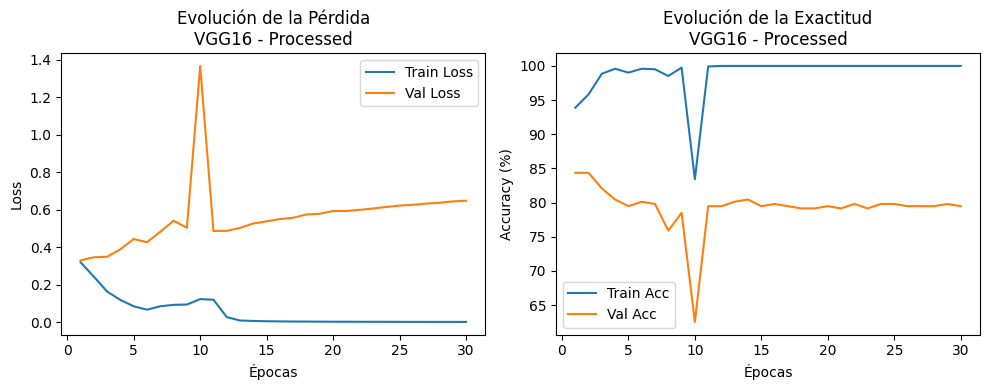


=== Final Training with Best Parameters - UNPROCESSED ===
Epoch 1/30, Train Loss: 0.3895, Train Acc: 0.8849, Val Loss: 0.3717, Val Acc: 0.8469
Epoch 2/30, Train Loss: 0.3304, Train Acc: 0.9143, Val Loss: 0.3813, Val Acc: 0.8339
Epoch 3/30, Train Loss: 0.2911, Train Acc: 0.9273, Val Loss: 0.3981, Val Acc: 0.8176
Epoch 4/30, Train Loss: 0.2413, Train Acc: 0.9592, Val Loss: 0.3964, Val Acc: 0.8176
Epoch 5/30, Train Loss: 0.2086, Train Acc: 0.9673, Val Loss: 0.4186, Val Acc: 0.8306
Epoch 6/30, Train Loss: 0.1825, Train Acc: 0.9698, Val Loss: 0.4497, Val Acc: 0.8143
Epoch 7/30, Train Loss: 0.1512, Train Acc: 0.9796, Val Loss: 0.4635, Val Acc: 0.7915
Epoch 8/30, Train Loss: 0.1277, Train Acc: 0.9535, Val Loss: 0.5608, Val Acc: 0.7720
Epoch 9/30, Train Loss: 0.1366, Train Acc: 0.8514, Val Loss: 0.8864, Val Acc: 0.6873
Epoch 10/30, Train Loss: 0.1416, Train Acc: 0.9649, Val Loss: 0.6225, Val Acc: 0.7980
Epoch 11/30, Train Loss: 0.1765, Train Acc: 0.8563, Val Loss: 0.9833, Val Acc: 0.6743
Epoc

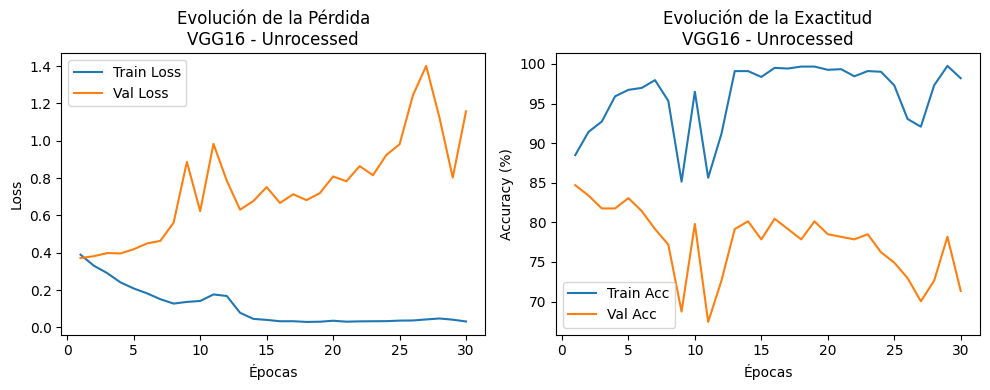


=== Evaluation: Processed Data ===

=== Resultados en Test [VGG16 - Processed] ===
Test Loss: 1.5015, Test Accuracy: 64.33%


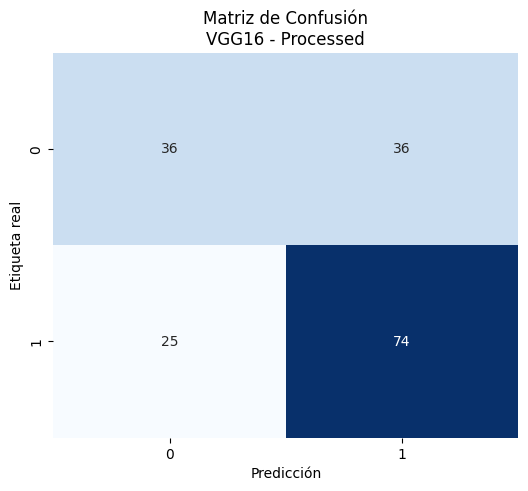


Reporte de Clasificación (VGG16 - Processed):
              precision    recall  f1-score   support

           0     0.5902    0.5000    0.5414        72
           1     0.6727    0.7475    0.7081        99

    accuracy                         0.6433       171
   macro avg     0.6314    0.6237    0.6247       171
weighted avg     0.6380    0.6433    0.6379       171



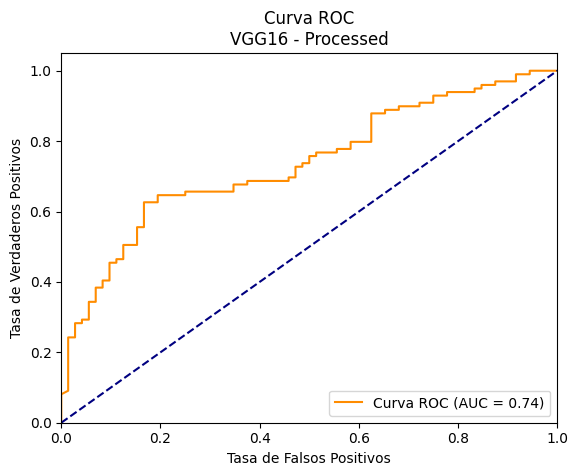


=== Evaluation: Unprocessed Data ===

=== Resultados en Test [VGG16 - Unprocessed] ===
Test Loss: 1.5744, Test Accuracy: 67.84%


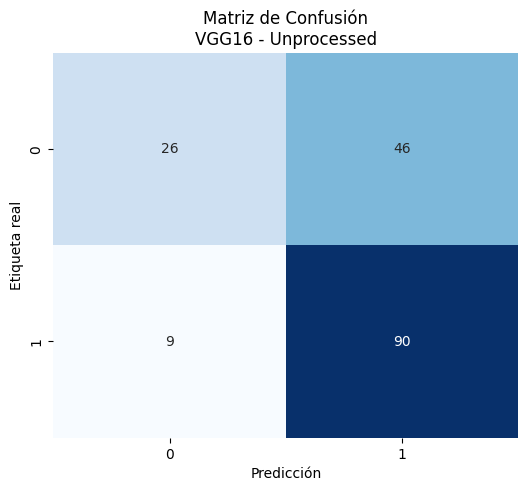


Reporte de Clasificación (VGG16 - Unprocessed):
              precision    recall  f1-score   support

           0     0.7429    0.3611    0.4860        72
           1     0.6618    0.9091    0.7660        99

    accuracy                         0.6784       171
   macro avg     0.7023    0.6351    0.6260       171
weighted avg     0.6959    0.6784    0.6481       171



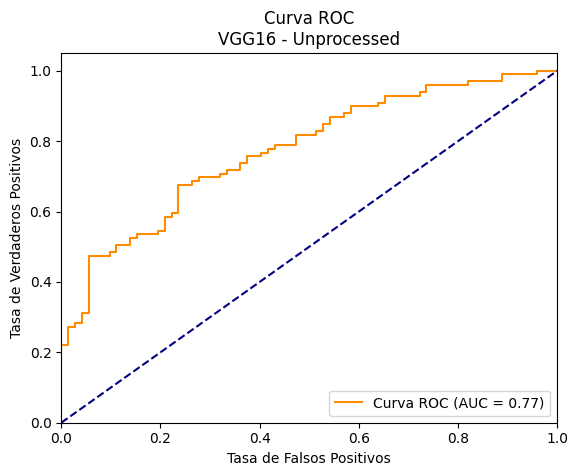

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
from sklearn.model_selection import ParameterGrid, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# 1. Modelo VGG16 Preentrenado (permitimos dropout como hiperparámetro)
# ==============================================================================
class FineTunedVGG16(nn.Module):
    def __init__(self, num_classes=2, dropout=0.5):
        """
        Carga VGG16 preentrenado y reemplaza su 'classifier' por uno que
        incluya dropout configurable, para ajustar al número de clases deseado.
        """
        super(FineTunedVGG16, self).__init__()

        # Cargamos VGG16
        self.vgg = models.vgg16(pretrained=True)

        # congelarmos las capas convolucionales (features) para fine-tuning
        for param in self.vgg.features.parameters():
            param.requires_grad = False

        # Reemplazamos el 'classifier' original por uno con dropout ajustable
        # VGG16 original: Linear(25088, 4096) -> ReLU -> Dropout(0.5) -> Linear(4096, 4096) -> ReLU -> Dropout(0.5) -> Linear(4096, 1000)
        # Lo adaptamos a 'num_classes' (2) y uso de 'dropout' como hiperparámetro
        self.vgg.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        return self.vgg(x)




# -------------------------------------------------------------------------------
# 9. ejecucion
# -------------------------------------------------------------------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    param_grid = {
        'lr': [1e-3, 1e-5],
        'dropout': [0.3, 0.5, 0.7],
        'weight_decay': [1e-3, 1e-5],
        'batch_size': [16, 32]
    }

    # -------------------------------
    # 9.1 Grid Search: Processed Data
    # -------------------------------
    print("=== Grid Search with Cross-Validation - PROCESSED DATA ===")
    best_config_vgg16, best_val_acc_vgg16, best_model_state_vgg16 = grid_search_cnn(
        train_processed_dataset , device, param_grid, n_splits=5, n_epochs=5
    )
    print(f"Best Config: {best_config_vgg16}")
    print(f"Best Validation Accuracy: {best_val_acc_vgg16:.4f}")

    # -------------------------------
    # 9.2 Grid Search: Unprocessed Data
    # -------------------------------
    print("=== Grid Search with Cross-Validation - UNPROCESSED DATA ===")
    best_config_un_vgg16, best_val_acc_un_vgg16, best_model_state_un_vgg16 = grid_search_cnn(
        train_unprocessed_dataset, device, param_grid, n_splits=5, n_epochs=5
    )
    print(f"Best Config: {best_config_un_vgg16}")
    print(f"Best Validation Accuracy: {best_val_acc_un_vgg16:.4f}")

    # inicializamos los mejores modelos
    best_model_vgg16 = FineTunedVGG16(num_classes=2, dropout=best_config_vgg16['dropout']).to(device)
    best_model_vgg16.load_state_dict(best_model_state_vgg16)

    best_model_un_vgg16 = FineTunedVGG16(num_classes=2, dropout=best_config_un_vgg16['dropout']).to(device)
    best_model_un_vgg16.load_state_dict(best_model_state_un_vgg16)


    # -----------------------------------------------------
    # 9.4 sets procesados y no procesados
    # -----------------------------------------------------

    test_loader = DataLoader(test_processed_dataset, batch_size=best_config_vgg16['batch_size'], shuffle=False)

    test_loader_un = DataLoader(test_unprocessed_dataset, batch_size=best_config_un_vgg16['batch_size'], shuffle=False)

    train_loader2 = DataLoader(train2_processed_dataset, batch_size=best_config_vgg16['batch_size'], shuffle=False)

    train_loader_un2 = DataLoader(train2_unprocessed_dataset, batch_size=best_config_un_vgg16['batch_size'], shuffle=False)

    val_loader = DataLoader(val_processed_dataset, batch_size=best_config_vgg16['batch_size'], shuffle=False)

    val_loader_un = DataLoader(val_unprocessed_dataset, batch_size=best_config_un_vgg16['batch_size'], shuffle=False)



    # -----------------------------------------------------
    # evaluacion antes de entrenar mas
    # -----------------------------------------------------
    criterion = nn.CrossEntropyLoss()

    test_loss, test_acc = validate_model(best_model_vgg16, test_loader, criterion, device)
    print(f"Processed Test - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

    test_loss_un, test_acc_un = validate_model(best_model_un_vgg16, test_loader_un, criterion, device)
    print(f"Unprocessed Test - Loss: {test_loss_un:.4f}, Accuracy: {test_acc_un:.4f}")


    print("\n=== Final Training with Best Parameters - PROCESSED ===")

    optimizer = optim.AdamW(best_model_vgg16.parameters(), lr=best_config_vgg16['lr'], weight_decay=best_config_vgg16['weight_decay'])

    train_losses, val_losses, train_accs, val_accs = train_cnn(
        model=best_model_vgg16,
        train_loader=train_loader2,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        epochs=30
    )

    plot_training_evolution(
        train_losses=train_losses,
        val_losses=val_losses,
        train_accs=train_accs,
        val_accs=val_accs,
        model_name="VGG16",
        data_type="Processed"
    )

    print("\n=== Final Training with Best Parameters - UNPROCESSED ===")

    optimizer = optim.AdamW(best_model_un_vgg16.parameters(), lr=best_config_un_vgg16['lr'], weight_decay=best_config_un_vgg16['weight_decay'])



    train_losses, val_losses, train_accs, val_accs = train_cnn(
        model=best_model_un_vgg16,
        train_loader=train_loader_un2,
        val_loader=val_loader_un,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        epochs=30
    )

    plot_training_evolution(
        train_losses=train_losses,
        val_losses=val_losses,
        train_accs=train_accs,
        val_accs=val_accs,
        model_name="VGG16",
        data_type="Unrocessed"
    )



    # -----------------------------------------------------
    # 9.8 evaluacion final
    # -----------------------------------------------------
    print("\n=== Evaluation: Processed Data ===")
    evaluate_cnn(best_model_vgg16, test_loader, nn.CrossEntropyLoss(), device, "VGG16", "Processed")

    print("\n=== Evaluation: Unprocessed Data ===")
    evaluate_cnn(best_model_un_vgg16, test_loader_un, nn.CrossEntropyLoss(), device, "VGG16", "Unprocessed")


# ResNet50 Grid Search

=== Grid Search with Cross-Validation - PROCESSED DATA ===
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]


Epoch 1/5, Train Loss: 0.6732, Val Loss: 0.6363, Val Acc: 0.6124
Epoch 2/5, Train Loss: 0.6396, Val Loss: 0.6198, Val Acc: 0.6710
Epoch 3/5, Train Loss: 0.6173, Val Loss: 0.6095, Val Acc: 0.6580
Epoch 4/5, Train Loss: 0.6096, Val Loss: 0.6131, Val Acc: 0.6580
Epoch 5/5, Train Loss: 0.6032, Val Loss: 0.5970, Val Acc: 0.6808
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6700, Val Loss: 0.6337, Val Acc: 0.6156
Epoch 2/5, Train Loss: 0.6353, Val Loss: 0.6220, Val Acc: 0.6156
Epoch 3/5, Train Loss: 0.6217, Val Loss: 0.5975, Val Acc: 0.6840
Epoch 4/5, Train Loss: 0.6053, Val Loss: 0.5885, Val Acc: 0.6971
Epoch 5/5, Train Loss: 0.6008, Val Loss: 0.5888, Val Acc: 0.6840
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6754, Val Loss: 0.6454, Val Acc: 0.5882
Epoch 2/5, Train Loss: 0.6506, Val Loss: 0.6088, Val Acc: 0.6634
Epoch 3/5, Train Loss: 0.6290, Val Loss: 0.5940, Val Acc: 0.6699
Epoch 4/5, Train Loss: 0.6203, Val Loss: 0.5841, Val Acc: 0.6699
Epoch 5/5, Train Loss: 0.6027, Val Loss: 0.5775, Val Acc: 0.7157
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6721, Val Loss: 0.6450, Val Acc: 0.6176
Epoch 2/5, Train Loss: 0.6406, Val Loss: 0.6262, Val Acc: 0.6078
Epoch 3/5, Train Loss: 0.6219, Val Loss: 0.6140, Val Acc: 0.6242
Epoch 4/5, Train Loss: 0.5967, Val Loss: 0.6054, Val Acc: 0.6275
Epoch 5/5, Train Loss: 0.6100, Val Loss: 0.6009, Val Acc: 0.6405
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6850, Val Loss: 0.6504, Val Acc: 0.6307
Epoch 2/5, Train Loss: 0.6509, Val Loss: 0.6159, Val Acc: 0.6765
Epoch 3/5, Train Loss: 0.6335, Val Loss: 0.6030, Val Acc: 0.6928
Epoch 4/5, Train Loss: 0.6035, Val Loss: 0.6015, Val Acc: 0.6634
Epoch 5/5, Train Loss: 0.6042, Val Loss: 0.5855, Val Acc: 0.6830
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 0.001}: 0.6808

Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6682, Val Loss: 0.6390, Val Acc: 0.5993
Epoch 2/5, Train Loss: 0.6395, Val Loss: 0.6208, Val Acc: 0.6482
Epoch 3/5, Train Loss: 0.6210, Val Loss: 0.6066, Val Acc: 0.6612
Epoch 4/5, Train Loss: 0.5983, Val Loss: 0.6025, Val Acc: 0.6612
Epoch 5/5, Train Loss: 0.5932, Val Loss: 0.5963, Val Acc: 0.6678
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6589, Val Loss: 0.6251, Val Acc: 0.6580
Epoch 2/5, Train Loss: 0.6304, Val Loss: 0.5997, Val Acc: 0.6580
Epoch 3/5, Train Loss: 0.6282, Val Loss: 0.6071, Val Acc: 0.6515
Epoch 4/5, Train Loss: 0.6016, Val Loss: 0.5857, Val Acc: 0.6743
Epoch 5/5, Train Loss: 0.6003, Val Loss: 0.5751, Val Acc: 0.7134
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6709, Val Loss: 0.6439, Val Acc: 0.6144
Epoch 2/5, Train Loss: 0.6349, Val Loss: 0.6140, Val Acc: 0.6634
Epoch 3/5, Train Loss: 0.6145, Val Loss: 0.6008, Val Acc: 0.6340
Epoch 4/5, Train Loss: 0.6149, Val Loss: 0.5926, Val Acc: 0.6634
Epoch 5/5, Train Loss: 0.6074, Val Loss: 0.5903, Val Acc: 0.6667
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6713, Val Loss: 0.6575, Val Acc: 0.6111
Epoch 2/5, Train Loss: 0.6446, Val Loss: 0.6397, Val Acc: 0.5850
Epoch 3/5, Train Loss: 0.6315, Val Loss: 0.6261, Val Acc: 0.6013
Epoch 4/5, Train Loss: 0.6085, Val Loss: 0.6178, Val Acc: 0.6078
Epoch 5/5, Train Loss: 0.6026, Val Loss: 0.6084, Val Acc: 0.6209
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6653, Val Loss: 0.6371, Val Acc: 0.6765
Epoch 2/5, Train Loss: 0.6330, Val Loss: 0.6228, Val Acc: 0.6242
Epoch 3/5, Train Loss: 0.6225, Val Loss: 0.6067, Val Acc: 0.6699
Epoch 4/5, Train Loss: 0.6093, Val Loss: 0.5967, Val Acc: 0.6830
Epoch 5/5, Train Loss: 0.5973, Val Loss: 0.5930, Val Acc: 0.6797
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 1e-05}: 0.6697

Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6940, Val Loss: 0.6822, Val Acc: 0.5537
Epoch 2/5, Train Loss: 0.6830, Val Loss: 0.6746, Val Acc: 0.5668
Epoch 3/5, Train Loss: 0.6862, Val Loss: 0.6687, Val Acc: 0.5570
Epoch 4/5, Train Loss: 0.6750, Val Loss: 0.6635, Val Acc: 0.5733
Epoch 5/5, Train Loss: 0.6693, Val Loss: 0.6569, Val Acc: 0.5798
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6782, Val Loss: 0.6523, Val Acc: 0.5928
Epoch 2/5, Train Loss: 0.6633, Val Loss: 0.6465, Val Acc: 0.6026
Epoch 3/5, Train Loss: 0.6641, Val Loss: 0.6426, Val Acc: 0.6059
Epoch 4/5, Train Loss: 0.6575, Val Loss: 0.6370, Val Acc: 0.6319
Epoch 5/5, Train Loss: 0.6565, Val Loss: 0.6366, Val Acc: 0.6156
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7062, Val Loss: 0.6680, Val Acc: 0.5948
Epoch 2/5, Train Loss: 0.6794, Val Loss: 0.6631, Val Acc: 0.5882
Epoch 3/5, Train Loss: 0.6714, Val Loss: 0.6555, Val Acc: 0.5948
Epoch 4/5, Train Loss: 0.6732, Val Loss: 0.6508, Val Acc: 0.5948
Epoch 5/5, Train Loss: 0.6613, Val Loss: 0.6457, Val Acc: 0.5915
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7087, Val Loss: 0.6862, Val Acc: 0.5654
Epoch 2/5, Train Loss: 0.6925, Val Loss: 0.6802, Val Acc: 0.5784
Epoch 3/5, Train Loss: 0.6830, Val Loss: 0.6760, Val Acc: 0.5719
Epoch 4/5, Train Loss: 0.6908, Val Loss: 0.6717, Val Acc: 0.5784
Epoch 5/5, Train Loss: 0.6720, Val Loss: 0.6654, Val Acc: 0.5850
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7374, Val Loss: 0.6892, Val Acc: 0.5784
Epoch 2/5, Train Loss: 0.6956, Val Loss: 0.6769, Val Acc: 0.5686
Epoch 3/5, Train Loss: 0.6885, Val Loss: 0.6721, Val Acc: 0.5621
Epoch 4/5, Train Loss: 0.6833, Val Loss: 0.6673, Val Acc: 0.5654
Epoch 5/5, Train Loss: 0.6831, Val Loss: 0.6624, Val Acc: 0.5654
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}: 0.5875

Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6819, Val Loss: 0.6741, Val Acc: 0.5863
Epoch 2/5, Train Loss: 0.6700, Val Loss: 0.6694, Val Acc: 0.5961
Epoch 3/5, Train Loss: 0.6640, Val Loss: 0.6647, Val Acc: 0.6091
Epoch 4/5, Train Loss: 0.6627, Val Loss: 0.6590, Val Acc: 0.6189
Epoch 5/5, Train Loss: 0.6693, Val Loss: 0.6547, Val Acc: 0.6254
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7268, Val Loss: 0.6821, Val Acc: 0.5603
Epoch 2/5, Train Loss: 0.6872, Val Loss: 0.6744, Val Acc: 0.5798
Epoch 3/5, Train Loss: 0.6768, Val Loss: 0.6660, Val Acc: 0.5798
Epoch 4/5, Train Loss: 0.6734, Val Loss: 0.6610, Val Acc: 0.6026
Epoch 5/5, Train Loss: 0.6635, Val Loss: 0.6553, Val Acc: 0.5896
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7122, Val Loss: 0.6945, Val Acc: 0.5556
Epoch 2/5, Train Loss: 0.7045, Val Loss: 0.6855, Val Acc: 0.5719
Epoch 3/5, Train Loss: 0.6936, Val Loss: 0.6786, Val Acc: 0.5719
Epoch 4/5, Train Loss: 0.6800, Val Loss: 0.6738, Val Acc: 0.5817
Epoch 5/5, Train Loss: 0.6732, Val Loss: 0.6655, Val Acc: 0.5948
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6783, Val Loss: 0.6731, Val Acc: 0.5752
Epoch 2/5, Train Loss: 0.6760, Val Loss: 0.6680, Val Acc: 0.5850
Epoch 3/5, Train Loss: 0.6684, Val Loss: 0.6632, Val Acc: 0.6046
Epoch 4/5, Train Loss: 0.6679, Val Loss: 0.6586, Val Acc: 0.6242
Epoch 5/5, Train Loss: 0.6534, Val Loss: 0.6560, Val Acc: 0.6111
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6842, Val Loss: 0.6696, Val Acc: 0.5817
Epoch 2/5, Train Loss: 0.6711, Val Loss: 0.6662, Val Acc: 0.5686
Epoch 3/5, Train Loss: 0.6702, Val Loss: 0.6579, Val Acc: 0.5980
Epoch 4/5, Train Loss: 0.6588, Val Loss: 0.6549, Val Acc: 0.5882
Epoch 5/5, Train Loss: 0.6654, Val Loss: 0.6518, Val Acc: 0.5948
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}: 0.6031

Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6832, Val Loss: 0.6566, Val Acc: 0.6254
Epoch 2/5, Train Loss: 0.6560, Val Loss: 0.6235, Val Acc: 0.6482
Epoch 3/5, Train Loss: 0.6361, Val Loss: 0.6080, Val Acc: 0.6319
Epoch 4/5, Train Loss: 0.6163, Val Loss: 0.6040, Val Acc: 0.6547
Epoch 5/5, Train Loss: 0.6088, Val Loss: 0.6052, Val Acc: 0.6580
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7010, Val Loss: 0.6702, Val Acc: 0.5798
Epoch 2/5, Train Loss: 0.6567, Val Loss: 0.6191, Val Acc: 0.6580
Epoch 3/5, Train Loss: 0.6398, Val Loss: 0.6064, Val Acc: 0.6580
Epoch 4/5, Train Loss: 0.6546, Val Loss: 0.6175, Val Acc: 0.6221
Epoch 5/5, Train Loss: 0.6169, Val Loss: 0.5908, Val Acc: 0.6971
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6794, Val Loss: 0.6373, Val Acc: 0.6275
Epoch 2/5, Train Loss: 0.6511, Val Loss: 0.6125, Val Acc: 0.6536
Epoch 3/5, Train Loss: 0.6332, Val Loss: 0.6028, Val Acc: 0.6830
Epoch 4/5, Train Loss: 0.6233, Val Loss: 0.5896, Val Acc: 0.6830
Epoch 5/5, Train Loss: 0.6145, Val Loss: 0.5832, Val Acc: 0.6830
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6831, Val Loss: 0.6523, Val Acc: 0.6111
Epoch 2/5, Train Loss: 0.6592, Val Loss: 0.6360, Val Acc: 0.6405
Epoch 3/5, Train Loss: 0.6235, Val Loss: 0.6195, Val Acc: 0.6307
Epoch 4/5, Train Loss: 0.6210, Val Loss: 0.6127, Val Acc: 0.6242
Epoch 5/5, Train Loss: 0.6179, Val Loss: 0.6168, Val Acc: 0.6438
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6852, Val Loss: 0.6442, Val Acc: 0.6013
Epoch 2/5, Train Loss: 0.6522, Val Loss: 0.6183, Val Acc: 0.6569
Epoch 3/5, Train Loss: 0.6350, Val Loss: 0.6064, Val Acc: 0.6634
Epoch 4/5, Train Loss: 0.6122, Val Loss: 0.6040, Val Acc: 0.6503
Epoch 5/5, Train Loss: 0.6091, Val Loss: 0.5893, Val Acc: 0.6732
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 0.001}: 0.6710

Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6912, Val Loss: 0.6501, Val Acc: 0.5961
Epoch 2/5, Train Loss: 0.6578, Val Loss: 0.6396, Val Acc: 0.6059
Epoch 3/5, Train Loss: 0.6330, Val Loss: 0.6205, Val Acc: 0.6352
Epoch 4/5, Train Loss: 0.6182, Val Loss: 0.6105, Val Acc: 0.6515
Epoch 5/5, Train Loss: 0.6044, Val Loss: 0.6034, Val Acc: 0.6482
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6986, Val Loss: 0.6491, Val Acc: 0.6091
Epoch 2/5, Train Loss: 0.6421, Val Loss: 0.6334, Val Acc: 0.6515
Epoch 3/5, Train Loss: 0.6450, Val Loss: 0.6113, Val Acc: 0.6580
Epoch 4/5, Train Loss: 0.6350, Val Loss: 0.6007, Val Acc: 0.6873
Epoch 5/5, Train Loss: 0.6158, Val Loss: 0.5932, Val Acc: 0.6808
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6968, Val Loss: 0.6392, Val Acc: 0.5882
Epoch 2/5, Train Loss: 0.6676, Val Loss: 0.6152, Val Acc: 0.6536
Epoch 3/5, Train Loss: 0.6382, Val Loss: 0.6040, Val Acc: 0.6732
Epoch 4/5, Train Loss: 0.6373, Val Loss: 0.5929, Val Acc: 0.6667
Epoch 5/5, Train Loss: 0.6191, Val Loss: 0.5874, Val Acc: 0.6765
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6936, Val Loss: 0.6484, Val Acc: 0.6013
Epoch 2/5, Train Loss: 0.6532, Val Loss: 0.6237, Val Acc: 0.6797
Epoch 3/5, Train Loss: 0.6406, Val Loss: 0.6107, Val Acc: 0.6601
Epoch 4/5, Train Loss: 0.6140, Val Loss: 0.6099, Val Acc: 0.6438
Epoch 5/5, Train Loss: 0.6146, Val Loss: 0.5982, Val Acc: 0.6667
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6898, Val Loss: 0.6505, Val Acc: 0.5980
Epoch 2/5, Train Loss: 0.6511, Val Loss: 0.6281, Val Acc: 0.6275
Epoch 3/5, Train Loss: 0.6279, Val Loss: 0.6174, Val Acc: 0.6536
Epoch 4/5, Train Loss: 0.6235, Val Loss: 0.6230, Val Acc: 0.6242
Epoch 5/5, Train Loss: 0.6230, Val Loss: 0.6078, Val Acc: 0.6503
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 1e-05}: 0.6645

Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6928, Val Loss: 0.6883, Val Acc: 0.5733
Epoch 2/5, Train Loss: 0.6986, Val Loss: 0.6823, Val Acc: 0.5700
Epoch 3/5, Train Loss: 0.6927, Val Loss: 0.6781, Val Acc: 0.5798
Epoch 4/5, Train Loss: 0.6826, Val Loss: 0.6751, Val Acc: 0.5700
Epoch 5/5, Train Loss: 0.6694, Val Loss: 0.6709, Val Acc: 0.5700
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6878, Val Loss: 0.6702, Val Acc: 0.6091
Epoch 2/5, Train Loss: 0.6783, Val Loss: 0.6641, Val Acc: 0.6091
Epoch 3/5, Train Loss: 0.6775, Val Loss: 0.6603, Val Acc: 0.6189
Epoch 4/5, Train Loss: 0.6643, Val Loss: 0.6548, Val Acc: 0.6189
Epoch 5/5, Train Loss: 0.6637, Val Loss: 0.6513, Val Acc: 0.6254
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7082, Val Loss: 0.6766, Val Acc: 0.5817
Epoch 2/5, Train Loss: 0.6972, Val Loss: 0.6687, Val Acc: 0.5882
Epoch 3/5, Train Loss: 0.6960, Val Loss: 0.6639, Val Acc: 0.5980
Epoch 4/5, Train Loss: 0.6933, Val Loss: 0.6609, Val Acc: 0.6078
Epoch 5/5, Train Loss: 0.6863, Val Loss: 0.6548, Val Acc: 0.6176
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7124, Val Loss: 0.6767, Val Acc: 0.5882
Epoch 2/5, Train Loss: 0.7066, Val Loss: 0.6733, Val Acc: 0.5850
Epoch 3/5, Train Loss: 0.6926, Val Loss: 0.6689, Val Acc: 0.6046
Epoch 4/5, Train Loss: 0.6876, Val Loss: 0.6634, Val Acc: 0.6111
Epoch 5/5, Train Loss: 0.6807, Val Loss: 0.6601, Val Acc: 0.6209
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7351, Val Loss: 0.6970, Val Acc: 0.5294
Epoch 2/5, Train Loss: 0.7005, Val Loss: 0.6918, Val Acc: 0.5850
Epoch 3/5, Train Loss: 0.7050, Val Loss: 0.6857, Val Acc: 0.5850
Epoch 4/5, Train Loss: 0.7014, Val Loss: 0.6795, Val Acc: 0.5784
Epoch 5/5, Train Loss: 0.6896, Val Loss: 0.6764, Val Acc: 0.5817
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}: 0.6031

Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6772, Val Loss: 0.6663, Val Acc: 0.5798
Epoch 2/5, Train Loss: 0.6759, Val Loss: 0.6608, Val Acc: 0.5961
Epoch 3/5, Train Loss: 0.6779, Val Loss: 0.6576, Val Acc: 0.5928
Epoch 4/5, Train Loss: 0.6726, Val Loss: 0.6544, Val Acc: 0.6059
Epoch 5/5, Train Loss: 0.6635, Val Loss: 0.6524, Val Acc: 0.6221
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7227, Val Loss: 0.6773, Val Acc: 0.5700
Epoch 2/5, Train Loss: 0.7188, Val Loss: 0.6708, Val Acc: 0.5863
Epoch 3/5, Train Loss: 0.7063, Val Loss: 0.6663, Val Acc: 0.5831
Epoch 4/5, Train Loss: 0.7006, Val Loss: 0.6599, Val Acc: 0.5961
Epoch 5/5, Train Loss: 0.6840, Val Loss: 0.6554, Val Acc: 0.6059
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7159, Val Loss: 0.6659, Val Acc: 0.5882
Epoch 2/5, Train Loss: 0.6913, Val Loss: 0.6605, Val Acc: 0.6046
Epoch 3/5, Train Loss: 0.6946, Val Loss: 0.6565, Val Acc: 0.6046
Epoch 4/5, Train Loss: 0.6890, Val Loss: 0.6521, Val Acc: 0.6013
Epoch 5/5, Train Loss: 0.6833, Val Loss: 0.6480, Val Acc: 0.6111
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7268, Val Loss: 0.6915, Val Acc: 0.5556
Epoch 2/5, Train Loss: 0.7288, Val Loss: 0.6872, Val Acc: 0.5850
Epoch 3/5, Train Loss: 0.7167, Val Loss: 0.6814, Val Acc: 0.5784
Epoch 4/5, Train Loss: 0.6979, Val Loss: 0.6763, Val Acc: 0.5948
Epoch 5/5, Train Loss: 0.6893, Val Loss: 0.6718, Val Acc: 0.5817
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7432, Val Loss: 0.6937, Val Acc: 0.5556
Epoch 2/5, Train Loss: 0.7121, Val Loss: 0.6869, Val Acc: 0.5784
Epoch 3/5, Train Loss: 0.7201, Val Loss: 0.6800, Val Acc: 0.5752
Epoch 4/5, Train Loss: 0.7096, Val Loss: 0.6751, Val Acc: 0.5850
Epoch 5/5, Train Loss: 0.7045, Val Loss: 0.6695, Val Acc: 0.5948
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}: 0.6031

Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7326, Val Loss: 0.6544, Val Acc: 0.5961
Epoch 2/5, Train Loss: 0.7192, Val Loss: 0.6330, Val Acc: 0.6124
Epoch 3/5, Train Loss: 0.6717, Val Loss: 0.6173, Val Acc: 0.6450
Epoch 4/5, Train Loss: 0.6673, Val Loss: 0.6143, Val Acc: 0.6384
Epoch 5/5, Train Loss: 0.6505, Val Loss: 0.6030, Val Acc: 0.6743
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7190, Val Loss: 0.6341, Val Acc: 0.6287
Epoch 2/5, Train Loss: 0.6877, Val Loss: 0.6149, Val Acc: 0.6417
Epoch 3/5, Train Loss: 0.6728, Val Loss: 0.6045, Val Acc: 0.6515
Epoch 4/5, Train Loss: 0.6662, Val Loss: 0.6015, Val Acc: 0.6678
Epoch 5/5, Train Loss: 0.6545, Val Loss: 0.6054, Val Acc: 0.6515
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7222, Val Loss: 0.6448, Val Acc: 0.5850
Epoch 2/5, Train Loss: 0.6965, Val Loss: 0.6210, Val Acc: 0.6536
Epoch 3/5, Train Loss: 0.6653, Val Loss: 0.6067, Val Acc: 0.6601
Epoch 4/5, Train Loss: 0.6509, Val Loss: 0.5975, Val Acc: 0.6503
Epoch 5/5, Train Loss: 0.6555, Val Loss: 0.5911, Val Acc: 0.6634
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7064, Val Loss: 0.6589, Val Acc: 0.5719
Epoch 2/5, Train Loss: 0.7113, Val Loss: 0.6365, Val Acc: 0.6176
Epoch 3/5, Train Loss: 0.6654, Val Loss: 0.6247, Val Acc: 0.6209
Epoch 4/5, Train Loss: 0.6476, Val Loss: 0.6200, Val Acc: 0.6275
Epoch 5/5, Train Loss: 0.6367, Val Loss: 0.6102, Val Acc: 0.6503
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7188, Val Loss: 0.6568, Val Acc: 0.6013
Epoch 2/5, Train Loss: 0.6786, Val Loss: 0.6374, Val Acc: 0.6373
Epoch 3/5, Train Loss: 0.6696, Val Loss: 0.6214, Val Acc: 0.6569
Epoch 4/5, Train Loss: 0.6688, Val Loss: 0.6153, Val Acc: 0.6340
Epoch 5/5, Train Loss: 0.6476, Val Loss: 0.6065, Val Acc: 0.6569
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 0.001}: 0.6593

Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7458, Val Loss: 0.6667, Val Acc: 0.5993
Epoch 2/5, Train Loss: 0.6980, Val Loss: 0.6420, Val Acc: 0.6515
Epoch 3/5, Train Loss: 0.6707, Val Loss: 0.6291, Val Acc: 0.6515
Epoch 4/5, Train Loss: 0.6574, Val Loss: 0.6210, Val Acc: 0.6515
Epoch 5/5, Train Loss: 0.6746, Val Loss: 0.6139, Val Acc: 0.6678
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7296, Val Loss: 0.6415, Val Acc: 0.5961
Epoch 2/5, Train Loss: 0.6890, Val Loss: 0.6188, Val Acc: 0.6645
Epoch 3/5, Train Loss: 0.6891, Val Loss: 0.6092, Val Acc: 0.6580
Epoch 4/5, Train Loss: 0.6373, Val Loss: 0.6004, Val Acc: 0.6743
Epoch 5/5, Train Loss: 0.6522, Val Loss: 0.5950, Val Acc: 0.6873
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7245, Val Loss: 0.6626, Val Acc: 0.5817
Epoch 2/5, Train Loss: 0.7038, Val Loss: 0.6251, Val Acc: 0.6471
Epoch 3/5, Train Loss: 0.6681, Val Loss: 0.6102, Val Acc: 0.6667
Epoch 4/5, Train Loss: 0.6682, Val Loss: 0.6003, Val Acc: 0.6667
Epoch 5/5, Train Loss: 0.6605, Val Loss: 0.5917, Val Acc: 0.6667
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7249, Val Loss: 0.6520, Val Acc: 0.6078
Epoch 2/5, Train Loss: 0.6884, Val Loss: 0.6395, Val Acc: 0.6242
Epoch 3/5, Train Loss: 0.6665, Val Loss: 0.6281, Val Acc: 0.6340
Epoch 4/5, Train Loss: 0.6794, Val Loss: 0.6155, Val Acc: 0.6307
Epoch 5/5, Train Loss: 0.6549, Val Loss: 0.6093, Val Acc: 0.6340
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7325, Val Loss: 0.6417, Val Acc: 0.6046
Epoch 2/5, Train Loss: 0.6790, Val Loss: 0.6198, Val Acc: 0.6405
Epoch 3/5, Train Loss: 0.6687, Val Loss: 0.6107, Val Acc: 0.6569
Epoch 4/5, Train Loss: 0.6507, Val Loss: 0.5961, Val Acc: 0.6601
Epoch 5/5, Train Loss: 0.6450, Val Loss: 0.5898, Val Acc: 0.6634
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 1e-05}: 0.6638

Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7415, Val Loss: 0.6749, Val Acc: 0.5570
Epoch 2/5, Train Loss: 0.7429, Val Loss: 0.6697, Val Acc: 0.5635
Epoch 3/5, Train Loss: 0.7318, Val Loss: 0.6653, Val Acc: 0.5700
Epoch 4/5, Train Loss: 0.7276, Val Loss: 0.6628, Val Acc: 0.5668
Epoch 5/5, Train Loss: 0.7309, Val Loss: 0.6592, Val Acc: 0.5896
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7593, Val Loss: 0.6847, Val Acc: 0.5570
Epoch 2/5, Train Loss: 0.7320, Val Loss: 0.6808, Val Acc: 0.5798
Epoch 3/5, Train Loss: 0.7188, Val Loss: 0.6744, Val Acc: 0.5798
Epoch 4/5, Train Loss: 0.7226, Val Loss: 0.6704, Val Acc: 0.5896
Epoch 5/5, Train Loss: 0.7298, Val Loss: 0.6679, Val Acc: 0.5928
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7423, Val Loss: 0.6917, Val Acc: 0.5327
Epoch 2/5, Train Loss: 0.7320, Val Loss: 0.6850, Val Acc: 0.5523
Epoch 3/5, Train Loss: 0.7201, Val Loss: 0.6802, Val Acc: 0.5784
Epoch 4/5, Train Loss: 0.7193, Val Loss: 0.6770, Val Acc: 0.5621
Epoch 5/5, Train Loss: 0.7066, Val Loss: 0.6740, Val Acc: 0.5817
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7767, Val Loss: 0.6982, Val Acc: 0.5163
Epoch 2/5, Train Loss: 0.7489, Val Loss: 0.6912, Val Acc: 0.5621
Epoch 3/5, Train Loss: 0.7491, Val Loss: 0.6857, Val Acc: 0.5719
Epoch 4/5, Train Loss: 0.7530, Val Loss: 0.6842, Val Acc: 0.6013
Epoch 5/5, Train Loss: 0.7376, Val Loss: 0.6781, Val Acc: 0.5948
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7452, Val Loss: 0.6932, Val Acc: 0.5490
Epoch 2/5, Train Loss: 0.7103, Val Loss: 0.6897, Val Acc: 0.5654
Epoch 3/5, Train Loss: 0.7258, Val Loss: 0.6854, Val Acc: 0.5719
Epoch 4/5, Train Loss: 0.7251, Val Loss: 0.6796, Val Acc: 0.5523
Epoch 5/5, Train Loss: 0.7104, Val Loss: 0.6758, Val Acc: 0.5621
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}: 0.5842

Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7392, Val Loss: 0.6768, Val Acc: 0.5798
Epoch 2/5, Train Loss: 0.7319, Val Loss: 0.6727, Val Acc: 0.5798
Epoch 3/5, Train Loss: 0.7226, Val Loss: 0.6694, Val Acc: 0.5863
Epoch 4/5, Train Loss: 0.7112, Val Loss: 0.6683, Val Acc: 0.5831
Epoch 5/5, Train Loss: 0.7139, Val Loss: 0.6642, Val Acc: 0.5831
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7709, Val Loss: 0.6831, Val Acc: 0.5570
Epoch 2/5, Train Loss: 0.7235, Val Loss: 0.6761, Val Acc: 0.5896
Epoch 3/5, Train Loss: 0.7265, Val Loss: 0.6724, Val Acc: 0.5896
Epoch 4/5, Train Loss: 0.7109, Val Loss: 0.6696, Val Acc: 0.5928
Epoch 5/5, Train Loss: 0.7322, Val Loss: 0.6648, Val Acc: 0.6091
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7403, Val Loss: 0.6783, Val Acc: 0.5556
Epoch 2/5, Train Loss: 0.7261, Val Loss: 0.6727, Val Acc: 0.5752
Epoch 3/5, Train Loss: 0.7265, Val Loss: 0.6698, Val Acc: 0.5817
Epoch 4/5, Train Loss: 0.7345, Val Loss: 0.6655, Val Acc: 0.5915
Epoch 5/5, Train Loss: 0.6978, Val Loss: 0.6620, Val Acc: 0.5948
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7831, Val Loss: 0.7007, Val Acc: 0.4935
Epoch 2/5, Train Loss: 0.7520, Val Loss: 0.6893, Val Acc: 0.5098
Epoch 3/5, Train Loss: 0.7446, Val Loss: 0.6840, Val Acc: 0.5556
Epoch 4/5, Train Loss: 0.7440, Val Loss: 0.6816, Val Acc: 0.5359
Epoch 5/5, Train Loss: 0.7276, Val Loss: 0.6772, Val Acc: 0.5588
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7435, Val Loss: 0.6905, Val Acc: 0.5784
Epoch 2/5, Train Loss: 0.7348, Val Loss: 0.6868, Val Acc: 0.5817
Epoch 3/5, Train Loss: 0.7196, Val Loss: 0.6812, Val Acc: 0.5915
Epoch 4/5, Train Loss: 0.7274, Val Loss: 0.6774, Val Acc: 0.5882
Epoch 5/5, Train Loss: 0.7241, Val Loss: 0.6739, Val Acc: 0.5882
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}: 0.5868

Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6791, Val Loss: 0.6542, Val Acc: 0.6450
Epoch 2/5, Train Loss: 0.6493, Val Loss: 0.6343, Val Acc: 0.6384
Epoch 3/5, Train Loss: 0.6255, Val Loss: 0.6206, Val Acc: 0.6450
Epoch 4/5, Train Loss: 0.6213, Val Loss: 0.6123, Val Acc: 0.6580
Epoch 5/5, Train Loss: 0.6030, Val Loss: 0.6063, Val Acc: 0.6515
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6907, Val Loss: 0.6526, Val Acc: 0.6026
Epoch 2/5, Train Loss: 0.6521, Val Loss: 0.6392, Val Acc: 0.5896
Epoch 3/5, Train Loss: 0.6332, Val Loss: 0.6162, Val Acc: 0.6547
Epoch 4/5, Train Loss: 0.6145, Val Loss: 0.6120, Val Acc: 0.6319
Epoch 5/5, Train Loss: 0.6189, Val Loss: 0.5993, Val Acc: 0.7068
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7012, Val Loss: 0.6687, Val Acc: 0.6340
Epoch 2/5, Train Loss: 0.6671, Val Loss: 0.6256, Val Acc: 0.6667
Epoch 3/5, Train Loss: 0.6336, Val Loss: 0.6127, Val Acc: 0.6797
Epoch 4/5, Train Loss: 0.6217, Val Loss: 0.6116, Val Acc: 0.6797
Epoch 5/5, Train Loss: 0.6237, Val Loss: 0.5954, Val Acc: 0.6569
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6729, Val Loss: 0.6619, Val Acc: 0.5850
Epoch 2/5, Train Loss: 0.6368, Val Loss: 0.6317, Val Acc: 0.6373
Epoch 3/5, Train Loss: 0.6232, Val Loss: 0.6204, Val Acc: 0.6340
Epoch 4/5, Train Loss: 0.6233, Val Loss: 0.6155, Val Acc: 0.6242
Epoch 5/5, Train Loss: 0.6083, Val Loss: 0.6115, Val Acc: 0.6503
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6839, Val Loss: 0.6445, Val Acc: 0.6176
Epoch 2/5, Train Loss: 0.6428, Val Loss: 0.6239, Val Acc: 0.6405
Epoch 3/5, Train Loss: 0.6356, Val Loss: 0.6103, Val Acc: 0.6536
Epoch 4/5, Train Loss: 0.6141, Val Loss: 0.5990, Val Acc: 0.6667
Epoch 5/5, Train Loss: 0.6157, Val Loss: 0.5964, Val Acc: 0.6536
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 0.001}: 0.6638

Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7015, Val Loss: 0.6658, Val Acc: 0.5765
Epoch 2/5, Train Loss: 0.6608, Val Loss: 0.6396, Val Acc: 0.6156
Epoch 3/5, Train Loss: 0.6321, Val Loss: 0.6245, Val Acc: 0.6254
Epoch 4/5, Train Loss: 0.6237, Val Loss: 0.6142, Val Acc: 0.6678
Epoch 5/5, Train Loss: 0.6159, Val Loss: 0.6089, Val Acc: 0.6775
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6866, Val Loss: 0.6450, Val Acc: 0.6384
Epoch 2/5, Train Loss: 0.6488, Val Loss: 0.6299, Val Acc: 0.6417
Epoch 3/5, Train Loss: 0.6332, Val Loss: 0.6129, Val Acc: 0.6710
Epoch 4/5, Train Loss: 0.6132, Val Loss: 0.6053, Val Acc: 0.6775
Epoch 5/5, Train Loss: 0.6059, Val Loss: 0.6028, Val Acc: 0.6743
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6847, Val Loss: 0.6383, Val Acc: 0.6078
Epoch 2/5, Train Loss: 0.6519, Val Loss: 0.6170, Val Acc: 0.6503
Epoch 3/5, Train Loss: 0.6301, Val Loss: 0.6127, Val Acc: 0.6601
Epoch 4/5, Train Loss: 0.6181, Val Loss: 0.5938, Val Acc: 0.6797
Epoch 5/5, Train Loss: 0.6073, Val Loss: 0.5872, Val Acc: 0.6928
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6784, Val Loss: 0.6634, Val Acc: 0.5752
Epoch 2/5, Train Loss: 0.6548, Val Loss: 0.6430, Val Acc: 0.6013
Epoch 3/5, Train Loss: 0.6339, Val Loss: 0.6406, Val Acc: 0.6209
Epoch 4/5, Train Loss: 0.6215, Val Loss: 0.6245, Val Acc: 0.6340
Epoch 5/5, Train Loss: 0.6045, Val Loss: 0.6110, Val Acc: 0.6373
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6740, Val Loss: 0.6458, Val Acc: 0.6242
Epoch 2/5, Train Loss: 0.6539, Val Loss: 0.6269, Val Acc: 0.6340
Epoch 3/5, Train Loss: 0.6299, Val Loss: 0.6145, Val Acc: 0.6471
Epoch 4/5, Train Loss: 0.6086, Val Loss: 0.6041, Val Acc: 0.6536
Epoch 5/5, Train Loss: 0.6104, Val Loss: 0.5981, Val Acc: 0.6667
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 1e-05}: 0.6697

Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6981, Val Loss: 0.6746, Val Acc: 0.5896
Epoch 2/5, Train Loss: 0.6910, Val Loss: 0.6717, Val Acc: 0.6059
Epoch 3/5, Train Loss: 0.6796, Val Loss: 0.6638, Val Acc: 0.6189
Epoch 4/5, Train Loss: 0.6721, Val Loss: 0.6597, Val Acc: 0.6384
Epoch 5/5, Train Loss: 0.6687, Val Loss: 0.6563, Val Acc: 0.6287
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6881, Val Loss: 0.6896, Val Acc: 0.5603
Epoch 2/5, Train Loss: 0.6904, Val Loss: 0.6842, Val Acc: 0.5603
Epoch 3/5, Train Loss: 0.6840, Val Loss: 0.6786, Val Acc: 0.5765
Epoch 4/5, Train Loss: 0.6815, Val Loss: 0.6737, Val Acc: 0.5733
Epoch 5/5, Train Loss: 0.6783, Val Loss: 0.6712, Val Acc: 0.5765
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7040, Val Loss: 0.6932, Val Acc: 0.5588
Epoch 2/5, Train Loss: 0.6886, Val Loss: 0.6880, Val Acc: 0.5654
Epoch 3/5, Train Loss: 0.6959, Val Loss: 0.6833, Val Acc: 0.5621
Epoch 4/5, Train Loss: 0.6913, Val Loss: 0.6789, Val Acc: 0.5686
Epoch 5/5, Train Loss: 0.6758, Val Loss: 0.6743, Val Acc: 0.5784
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.8206, Val Loss: 0.7358, Val Acc: 0.4216
Epoch 2/5, Train Loss: 0.7260, Val Loss: 0.6956, Val Acc: 0.4967
Epoch 3/5, Train Loss: 0.7094, Val Loss: 0.6856, Val Acc: 0.5556
Epoch 4/5, Train Loss: 0.7041, Val Loss: 0.6812, Val Acc: 0.5784
Epoch 5/5, Train Loss: 0.6907, Val Loss: 0.6793, Val Acc: 0.5882
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6972, Val Loss: 0.6813, Val Acc: 0.6046
Epoch 2/5, Train Loss: 0.6871, Val Loss: 0.6789, Val Acc: 0.5980
Epoch 3/5, Train Loss: 0.6908, Val Loss: 0.6746, Val Acc: 0.5980
Epoch 4/5, Train Loss: 0.6858, Val Loss: 0.6712, Val Acc: 0.5915
Epoch 5/5, Train Loss: 0.6746, Val Loss: 0.6675, Val Acc: 0.6013
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}: 0.5946

Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7117, Val Loss: 0.7003, Val Acc: 0.5603
Epoch 2/5, Train Loss: 0.7050, Val Loss: 0.6945, Val Acc: 0.5765
Epoch 3/5, Train Loss: 0.6995, Val Loss: 0.6888, Val Acc: 0.5896
Epoch 4/5, Train Loss: 0.6938, Val Loss: 0.6839, Val Acc: 0.5863
Epoch 5/5, Train Loss: 0.6859, Val Loss: 0.6797, Val Acc: 0.5733
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7456, Val Loss: 0.7113, Val Acc: 0.4691
Epoch 2/5, Train Loss: 0.7119, Val Loss: 0.6981, Val Acc: 0.5440
Epoch 3/5, Train Loss: 0.6985, Val Loss: 0.6943, Val Acc: 0.5407
Epoch 4/5, Train Loss: 0.6995, Val Loss: 0.6902, Val Acc: 0.5505
Epoch 5/5, Train Loss: 0.7009, Val Loss: 0.6842, Val Acc: 0.5570
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6900, Val Loss: 0.6830, Val Acc: 0.5719
Epoch 2/5, Train Loss: 0.6900, Val Loss: 0.6797, Val Acc: 0.5719
Epoch 3/5, Train Loss: 0.6826, Val Loss: 0.6749, Val Acc: 0.5850
Epoch 4/5, Train Loss: 0.6715, Val Loss: 0.6702, Val Acc: 0.5784
Epoch 5/5, Train Loss: 0.6671, Val Loss: 0.6675, Val Acc: 0.5817
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7152, Val Loss: 0.6929, Val Acc: 0.5752
Epoch 2/5, Train Loss: 0.7069, Val Loss: 0.6873, Val Acc: 0.5882
Epoch 3/5, Train Loss: 0.7000, Val Loss: 0.6832, Val Acc: 0.5882
Epoch 4/5, Train Loss: 0.7013, Val Loss: 0.6776, Val Acc: 0.5948
Epoch 5/5, Train Loss: 0.6904, Val Loss: 0.6729, Val Acc: 0.6046
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6941, Val Loss: 0.6863, Val Acc: 0.5556
Epoch 2/5, Train Loss: 0.6954, Val Loss: 0.6810, Val Acc: 0.5686
Epoch 3/5, Train Loss: 0.6709, Val Loss: 0.6766, Val Acc: 0.5686
Epoch 4/5, Train Loss: 0.6733, Val Loss: 0.6733, Val Acc: 0.5817
Epoch 5/5, Train Loss: 0.6753, Val Loss: 0.6685, Val Acc: 0.5948
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}: 0.5823

Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7010, Val Loss: 0.6600, Val Acc: 0.5993
Epoch 2/5, Train Loss: 0.6795, Val Loss: 0.6376, Val Acc: 0.6450
Epoch 3/5, Train Loss: 0.6377, Val Loss: 0.6241, Val Acc: 0.6515
Epoch 4/5, Train Loss: 0.6389, Val Loss: 0.6157, Val Acc: 0.6710
Epoch 5/5, Train Loss: 0.6219, Val Loss: 0.6092, Val Acc: 0.6938
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6762, Val Loss: 0.6439, Val Acc: 0.6059
Epoch 2/5, Train Loss: 0.6572, Val Loss: 0.6217, Val Acc: 0.6612
Epoch 3/5, Train Loss: 0.6412, Val Loss: 0.6105, Val Acc: 0.6873
Epoch 4/5, Train Loss: 0.6279, Val Loss: 0.6000, Val Acc: 0.6873
Epoch 5/5, Train Loss: 0.6173, Val Loss: 0.5944, Val Acc: 0.6971
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6948, Val Loss: 0.6352, Val Acc: 0.6275
Epoch 2/5, Train Loss: 0.6502, Val Loss: 0.6180, Val Acc: 0.6471
Epoch 3/5, Train Loss: 0.6548, Val Loss: 0.6030, Val Acc: 0.6667
Epoch 4/5, Train Loss: 0.6382, Val Loss: 0.5945, Val Acc: 0.6601
Epoch 5/5, Train Loss: 0.6160, Val Loss: 0.5890, Val Acc: 0.6601
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6991, Val Loss: 0.6486, Val Acc: 0.6176
Epoch 2/5, Train Loss: 0.6590, Val Loss: 0.6309, Val Acc: 0.6405
Epoch 3/5, Train Loss: 0.6276, Val Loss: 0.6146, Val Acc: 0.6536
Epoch 4/5, Train Loss: 0.6424, Val Loss: 0.6059, Val Acc: 0.6503
Epoch 5/5, Train Loss: 0.6178, Val Loss: 0.6066, Val Acc: 0.6569
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6949, Val Loss: 0.6673, Val Acc: 0.5850
Epoch 2/5, Train Loss: 0.6695, Val Loss: 0.6415, Val Acc: 0.6373
Epoch 3/5, Train Loss: 0.6548, Val Loss: 0.6331, Val Acc: 0.6144
Epoch 4/5, Train Loss: 0.6357, Val Loss: 0.6211, Val Acc: 0.6373
Epoch 5/5, Train Loss: 0.6290, Val Loss: 0.6143, Val Acc: 0.6438
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 0.001}: 0.6703

Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7019, Val Loss: 0.6497, Val Acc: 0.6254
Epoch 2/5, Train Loss: 0.6519, Val Loss: 0.6251, Val Acc: 0.6417
Epoch 3/5, Train Loss: 0.6346, Val Loss: 0.6137, Val Acc: 0.6580
Epoch 4/5, Train Loss: 0.6199, Val Loss: 0.6040, Val Acc: 0.6710
Epoch 5/5, Train Loss: 0.6269, Val Loss: 0.5998, Val Acc: 0.6775
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6902, Val Loss: 0.6523, Val Acc: 0.5928
Epoch 2/5, Train Loss: 0.6658, Val Loss: 0.6377, Val Acc: 0.6450
Epoch 3/5, Train Loss: 0.6558, Val Loss: 0.6223, Val Acc: 0.6547
Epoch 4/5, Train Loss: 0.6343, Val Loss: 0.6101, Val Acc: 0.6547
Epoch 5/5, Train Loss: 0.6238, Val Loss: 0.6031, Val Acc: 0.6645
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6913, Val Loss: 0.6579, Val Acc: 0.5948
Epoch 2/5, Train Loss: 0.6619, Val Loss: 0.6393, Val Acc: 0.6601
Epoch 3/5, Train Loss: 0.6442, Val Loss: 0.6285, Val Acc: 0.6373
Epoch 4/5, Train Loss: 0.6381, Val Loss: 0.6135, Val Acc: 0.6863
Epoch 5/5, Train Loss: 0.6107, Val Loss: 0.6014, Val Acc: 0.6863
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7032, Val Loss: 0.6585, Val Acc: 0.5948
Epoch 2/5, Train Loss: 0.6660, Val Loss: 0.6425, Val Acc: 0.6078
Epoch 3/5, Train Loss: 0.6529, Val Loss: 0.6354, Val Acc: 0.6176
Epoch 4/5, Train Loss: 0.6398, Val Loss: 0.6155, Val Acc: 0.6536
Epoch 5/5, Train Loss: 0.6156, Val Loss: 0.6083, Val Acc: 0.6503
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6939, Val Loss: 0.6530, Val Acc: 0.5817
Epoch 2/5, Train Loss: 0.6570, Val Loss: 0.6277, Val Acc: 0.6601
Epoch 3/5, Train Loss: 0.6446, Val Loss: 0.6149, Val Acc: 0.6471
Epoch 4/5, Train Loss: 0.6365, Val Loss: 0.6054, Val Acc: 0.6569
Epoch 5/5, Train Loss: 0.6160, Val Loss: 0.5982, Val Acc: 0.6569
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 1e-05}: 0.6671

Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7120, Val Loss: 0.6736, Val Acc: 0.5635
Epoch 2/5, Train Loss: 0.6961, Val Loss: 0.6680, Val Acc: 0.5863
Epoch 3/5, Train Loss: 0.6946, Val Loss: 0.6648, Val Acc: 0.5961
Epoch 4/5, Train Loss: 0.6803, Val Loss: 0.6593, Val Acc: 0.5993
Epoch 5/5, Train Loss: 0.6913, Val Loss: 0.6557, Val Acc: 0.6091
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7042, Val Loss: 0.6712, Val Acc: 0.5765
Epoch 2/5, Train Loss: 0.6973, Val Loss: 0.6680, Val Acc: 0.5831
Epoch 3/5, Train Loss: 0.6877, Val Loss: 0.6642, Val Acc: 0.5863
Epoch 4/5, Train Loss: 0.6971, Val Loss: 0.6614, Val Acc: 0.5961
Epoch 5/5, Train Loss: 0.6938, Val Loss: 0.6578, Val Acc: 0.5961
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7550, Val Loss: 0.6739, Val Acc: 0.5784
Epoch 2/5, Train Loss: 0.6963, Val Loss: 0.6437, Val Acc: 0.6438
Epoch 3/5, Train Loss: 0.6995, Val Loss: 0.6377, Val Acc: 0.6503
Epoch 4/5, Train Loss: 0.6842, Val Loss: 0.6345, Val Acc: 0.6503
Epoch 5/5, Train Loss: 0.6856, Val Loss: 0.6335, Val Acc: 0.6536
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7056, Val Loss: 0.6815, Val Acc: 0.5719
Epoch 2/5, Train Loss: 0.7150, Val Loss: 0.6782, Val Acc: 0.5784
Epoch 3/5, Train Loss: 0.7045, Val Loss: 0.6745, Val Acc: 0.5752
Epoch 4/5, Train Loss: 0.6982, Val Loss: 0.6709, Val Acc: 0.5850
Epoch 5/5, Train Loss: 0.6942, Val Loss: 0.6668, Val Acc: 0.5850
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7259, Val Loss: 0.7063, Val Acc: 0.5556
Epoch 2/5, Train Loss: 0.7162, Val Loss: 0.7006, Val Acc: 0.5621
Epoch 3/5, Train Loss: 0.7102, Val Loss: 0.6956, Val Acc: 0.5621
Epoch 4/5, Train Loss: 0.7056, Val Loss: 0.6911, Val Acc: 0.5654
Epoch 5/5, Train Loss: 0.7122, Val Loss: 0.6870, Val Acc: 0.5654
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}: 0.6018

Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7196, Val Loss: 0.7049, Val Acc: 0.5537
Epoch 2/5, Train Loss: 0.7176, Val Loss: 0.6996, Val Acc: 0.5668
Epoch 3/5, Train Loss: 0.7055, Val Loss: 0.6950, Val Acc: 0.5700
Epoch 4/5, Train Loss: 0.7173, Val Loss: 0.6910, Val Acc: 0.5700
Epoch 5/5, Train Loss: 0.7015, Val Loss: 0.6861, Val Acc: 0.5798
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7445, Val Loss: 0.6937, Val Acc: 0.5277
Epoch 2/5, Train Loss: 0.7097, Val Loss: 0.6778, Val Acc: 0.5668
Epoch 3/5, Train Loss: 0.6963, Val Loss: 0.6729, Val Acc: 0.5896
Epoch 4/5, Train Loss: 0.6991, Val Loss: 0.6688, Val Acc: 0.5863
Epoch 5/5, Train Loss: 0.6961, Val Loss: 0.6670, Val Acc: 0.5896
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7035, Val Loss: 0.6652, Val Acc: 0.5915
Epoch 2/5, Train Loss: 0.7087, Val Loss: 0.6617, Val Acc: 0.5817
Epoch 3/5, Train Loss: 0.7090, Val Loss: 0.6572, Val Acc: 0.5948
Epoch 4/5, Train Loss: 0.6857, Val Loss: 0.6536, Val Acc: 0.5882
Epoch 5/5, Train Loss: 0.6733, Val Loss: 0.6521, Val Acc: 0.5948
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6978, Val Loss: 0.6711, Val Acc: 0.5980
Epoch 2/5, Train Loss: 0.7041, Val Loss: 0.6661, Val Acc: 0.5980
Epoch 3/5, Train Loss: 0.6956, Val Loss: 0.6640, Val Acc: 0.5915
Epoch 4/5, Train Loss: 0.6879, Val Loss: 0.6609, Val Acc: 0.5915
Epoch 5/5, Train Loss: 0.6886, Val Loss: 0.6592, Val Acc: 0.5882
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7326, Val Loss: 0.6760, Val Acc: 0.5784
Epoch 2/5, Train Loss: 0.7036, Val Loss: 0.6674, Val Acc: 0.6013
Epoch 3/5, Train Loss: 0.7055, Val Loss: 0.6627, Val Acc: 0.5817
Epoch 4/5, Train Loss: 0.6871, Val Loss: 0.6611, Val Acc: 0.5686
Epoch 5/5, Train Loss: 0.6920, Val Loss: 0.6575, Val Acc: 0.5817
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}: 0.5868

Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7528, Val Loss: 0.6810, Val Acc: 0.5896
Epoch 2/5, Train Loss: 0.7225, Val Loss: 0.6595, Val Acc: 0.6319
Epoch 3/5, Train Loss: 0.6842, Val Loss: 0.6477, Val Acc: 0.6384
Epoch 4/5, Train Loss: 0.6658, Val Loss: 0.6368, Val Acc: 0.6417
Epoch 5/5, Train Loss: 0.6661, Val Loss: 0.6317, Val Acc: 0.6450
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7440, Val Loss: 0.6575, Val Acc: 0.6417
Epoch 2/5, Train Loss: 0.7006, Val Loss: 0.6516, Val Acc: 0.5993
Epoch 3/5, Train Loss: 0.6874, Val Loss: 0.6266, Val Acc: 0.6612
Epoch 4/5, Train Loss: 0.6597, Val Loss: 0.6176, Val Acc: 0.6743
Epoch 5/5, Train Loss: 0.6818, Val Loss: 0.6093, Val Acc: 0.6678
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7460, Val Loss: 0.6592, Val Acc: 0.6046
Epoch 2/5, Train Loss: 0.7239, Val Loss: 0.6407, Val Acc: 0.6176
Epoch 3/5, Train Loss: 0.7106, Val Loss: 0.6272, Val Acc: 0.6176
Epoch 4/5, Train Loss: 0.6949, Val Loss: 0.6162, Val Acc: 0.6307
Epoch 5/5, Train Loss: 0.6589, Val Loss: 0.6092, Val Acc: 0.6405
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7268, Val Loss: 0.6595, Val Acc: 0.5882
Epoch 2/5, Train Loss: 0.6889, Val Loss: 0.6428, Val Acc: 0.6111
Epoch 3/5, Train Loss: 0.6587, Val Loss: 0.6300, Val Acc: 0.6275
Epoch 4/5, Train Loss: 0.6501, Val Loss: 0.6216, Val Acc: 0.6438
Epoch 5/5, Train Loss: 0.6578, Val Loss: 0.6147, Val Acc: 0.6438
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7460, Val Loss: 0.6687, Val Acc: 0.5784
Epoch 2/5, Train Loss: 0.7231, Val Loss: 0.6549, Val Acc: 0.6307
Epoch 3/5, Train Loss: 0.6913, Val Loss: 0.6334, Val Acc: 0.6307
Epoch 4/5, Train Loss: 0.6850, Val Loss: 0.6236, Val Acc: 0.6471
Epoch 5/5, Train Loss: 0.6740, Val Loss: 0.6141, Val Acc: 0.6405
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 0.001}: 0.6475

Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7696, Val Loss: 0.6716, Val Acc: 0.5831
Epoch 2/5, Train Loss: 0.7223, Val Loss: 0.6499, Val Acc: 0.6059
Epoch 3/5, Train Loss: 0.6834, Val Loss: 0.6365, Val Acc: 0.6254
Epoch 4/5, Train Loss: 0.6825, Val Loss: 0.6264, Val Acc: 0.6287
Epoch 5/5, Train Loss: 0.6507, Val Loss: 0.6193, Val Acc: 0.6384
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7140, Val Loss: 0.6457, Val Acc: 0.6189
Epoch 2/5, Train Loss: 0.6895, Val Loss: 0.6288, Val Acc: 0.6515
Epoch 3/5, Train Loss: 0.6795, Val Loss: 0.6159, Val Acc: 0.6678
Epoch 4/5, Train Loss: 0.6757, Val Loss: 0.6078, Val Acc: 0.6840
Epoch 5/5, Train Loss: 0.6487, Val Loss: 0.6095, Val Acc: 0.6450
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7379, Val Loss: 0.6555, Val Acc: 0.5850
Epoch 2/5, Train Loss: 0.7194, Val Loss: 0.6335, Val Acc: 0.6176
Epoch 3/5, Train Loss: 0.6749, Val Loss: 0.6222, Val Acc: 0.6209
Epoch 4/5, Train Loss: 0.6641, Val Loss: 0.6117, Val Acc: 0.6503
Epoch 5/5, Train Loss: 0.6494, Val Loss: 0.6048, Val Acc: 0.6471
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7476, Val Loss: 0.6683, Val Acc: 0.5850
Epoch 2/5, Train Loss: 0.7094, Val Loss: 0.6463, Val Acc: 0.5915
Epoch 3/5, Train Loss: 0.7012, Val Loss: 0.6340, Val Acc: 0.6340
Epoch 4/5, Train Loss: 0.6965, Val Loss: 0.6241, Val Acc: 0.6438
Epoch 5/5, Train Loss: 0.6460, Val Loss: 0.6157, Val Acc: 0.6340
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7236, Val Loss: 0.6653, Val Acc: 0.5882
Epoch 2/5, Train Loss: 0.6934, Val Loss: 0.6459, Val Acc: 0.5915
Epoch 3/5, Train Loss: 0.6839, Val Loss: 0.6317, Val Acc: 0.6307
Epoch 4/5, Train Loss: 0.6663, Val Loss: 0.6222, Val Acc: 0.6471
Epoch 5/5, Train Loss: 0.6791, Val Loss: 0.6179, Val Acc: 0.6242
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 1e-05}: 0.6377

Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7356, Val Loss: 0.6903, Val Acc: 0.5309
Epoch 2/5, Train Loss: 0.7253, Val Loss: 0.6869, Val Acc: 0.5440
Epoch 3/5, Train Loss: 0.7102, Val Loss: 0.6842, Val Acc: 0.5733
Epoch 4/5, Train Loss: 0.7415, Val Loss: 0.6807, Val Acc: 0.5798
Epoch 5/5, Train Loss: 0.7305, Val Loss: 0.6790, Val Acc: 0.5700
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7412, Val Loss: 0.6907, Val Acc: 0.5733
Epoch 2/5, Train Loss: 0.7393, Val Loss: 0.6848, Val Acc: 0.5831
Epoch 3/5, Train Loss: 0.7328, Val Loss: 0.6822, Val Acc: 0.5798
Epoch 4/5, Train Loss: 0.7344, Val Loss: 0.6808, Val Acc: 0.5831
Epoch 5/5, Train Loss: 0.7341, Val Loss: 0.6775, Val Acc: 0.5798
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7682, Val Loss: 0.6989, Val Acc: 0.4641
Epoch 2/5, Train Loss: 0.7428, Val Loss: 0.6830, Val Acc: 0.5523
Epoch 3/5, Train Loss: 0.7382, Val Loss: 0.6779, Val Acc: 0.5784
Epoch 4/5, Train Loss: 0.7453, Val Loss: 0.6747, Val Acc: 0.5948
Epoch 5/5, Train Loss: 0.7146, Val Loss: 0.6718, Val Acc: 0.5948
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7574, Val Loss: 0.6710, Val Acc: 0.5948
Epoch 2/5, Train Loss: 0.7154, Val Loss: 0.6586, Val Acc: 0.6242
Epoch 3/5, Train Loss: 0.7191, Val Loss: 0.6555, Val Acc: 0.6144
Epoch 4/5, Train Loss: 0.7121, Val Loss: 0.6536, Val Acc: 0.6111
Epoch 5/5, Train Loss: 0.7121, Val Loss: 0.6525, Val Acc: 0.6275
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7531, Val Loss: 0.7145, Val Acc: 0.4869
Epoch 2/5, Train Loss: 0.7536, Val Loss: 0.7075, Val Acc: 0.5294
Epoch 3/5, Train Loss: 0.7467, Val Loss: 0.7056, Val Acc: 0.5392
Epoch 4/5, Train Loss: 0.7342, Val Loss: 0.7020, Val Acc: 0.5392
Epoch 5/5, Train Loss: 0.7343, Val Loss: 0.6979, Val Acc: 0.5359
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}: 0.5816

Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7904, Val Loss: 0.6957, Val Acc: 0.5147
Epoch 2/5, Train Loss: 0.7582, Val Loss: 0.6839, Val Acc: 0.5407
Epoch 3/5, Train Loss: 0.7715, Val Loss: 0.6808, Val Acc: 0.5472
Epoch 4/5, Train Loss: 0.7434, Val Loss: 0.6788, Val Acc: 0.5472
Epoch 5/5, Train Loss: 0.7368, Val Loss: 0.6756, Val Acc: 0.5537
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7310, Val Loss: 0.6882, Val Acc: 0.5505
Epoch 2/5, Train Loss: 0.7274, Val Loss: 0.6845, Val Acc: 0.5668
Epoch 3/5, Train Loss: 0.7457, Val Loss: 0.6816, Val Acc: 0.5603
Epoch 4/5, Train Loss: 0.7269, Val Loss: 0.6788, Val Acc: 0.5831
Epoch 5/5, Train Loss: 0.7360, Val Loss: 0.6770, Val Acc: 0.5733
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7382, Val Loss: 0.6782, Val Acc: 0.5425
Epoch 2/5, Train Loss: 0.7302, Val Loss: 0.6742, Val Acc: 0.5686
Epoch 3/5, Train Loss: 0.7229, Val Loss: 0.6716, Val Acc: 0.5654
Epoch 4/5, Train Loss: 0.7270, Val Loss: 0.6691, Val Acc: 0.5752
Epoch 5/5, Train Loss: 0.7046, Val Loss: 0.6662, Val Acc: 0.5752
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7666, Val Loss: 0.6801, Val Acc: 0.5752
Epoch 2/5, Train Loss: 0.7289, Val Loss: 0.6653, Val Acc: 0.5752
Epoch 3/5, Train Loss: 0.7151, Val Loss: 0.6613, Val Acc: 0.5882
Epoch 4/5, Train Loss: 0.7082, Val Loss: 0.6603, Val Acc: 0.5882
Epoch 5/5, Train Loss: 0.6948, Val Loss: 0.6583, Val Acc: 0.5784
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7727, Val Loss: 0.6969, Val Acc: 0.5065
Epoch 2/5, Train Loss: 0.7233, Val Loss: 0.6891, Val Acc: 0.5588
Epoch 3/5, Train Loss: 0.7331, Val Loss: 0.6867, Val Acc: 0.5719
Epoch 4/5, Train Loss: 0.7287, Val Loss: 0.6845, Val Acc: 0.5882
Epoch 5/5, Train Loss: 0.7316, Val Loss: 0.6810, Val Acc: 0.5850
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}: 0.5731

Best Config: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 0.001}
Best Validation Accuracy: 0.6808
=== Grid Search with Cross-Validation - UNPROCESSED DATA ===
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6733, Val Loss: 0.6401, Val Acc: 0.6287
Epoch 2/5, Train Loss: 0.6384, Val Loss: 0.6285, Val Acc: 0.6482
Epoch 3/5, Train Loss: 0.6131, Val Loss: 0.6115, Val Acc: 0.6775
Epoch 4/5, Train Loss: 0.6012, Val Loss: 0.6103, Val Acc: 0.6678
Epoch 5/5, Train Loss: 0.5894, Val Loss: 0.6034, Val Acc: 0.6743
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6859, Val Loss: 0.6142, Val Acc: 0.6254
Epoch 2/5, Train Loss: 0.6445, Val Loss: 0.5986, Val Acc: 0.6971
Epoch 3/5, Train Loss: 0.6241, Val Loss: 0.5792, Val Acc: 0.6971
Epoch 4/5, Train Loss: 0.6150, Val Loss: 0.5743, Val Acc: 0.7134
Epoch 5/5, Train Loss: 0.6107, Val Loss: 0.5594, Val Acc: 0.7199
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6813, Val Loss: 0.6372, Val Acc: 0.6797
Epoch 2/5, Train Loss: 0.6399, Val Loss: 0.6106, Val Acc: 0.6307
Epoch 3/5, Train Loss: 0.6246, Val Loss: 0.5950, Val Acc: 0.7190
Epoch 4/5, Train Loss: 0.6230, Val Loss: 0.5885, Val Acc: 0.6961
Epoch 5/5, Train Loss: 0.6047, Val Loss: 0.5782, Val Acc: 0.7059
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6672, Val Loss: 0.6371, Val Acc: 0.6046
Epoch 2/5, Train Loss: 0.6416, Val Loss: 0.6190, Val Acc: 0.6307
Epoch 3/5, Train Loss: 0.6173, Val Loss: 0.6020, Val Acc: 0.6405
Epoch 4/5, Train Loss: 0.5986, Val Loss: 0.6003, Val Acc: 0.6993
Epoch 5/5, Train Loss: 0.6044, Val Loss: 0.5877, Val Acc: 0.6503
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6729, Val Loss: 0.6395, Val Acc: 0.6013
Epoch 2/5, Train Loss: 0.6367, Val Loss: 0.6186, Val Acc: 0.6405
Epoch 3/5, Train Loss: 0.6218, Val Loss: 0.6082, Val Acc: 0.6536
Epoch 4/5, Train Loss: 0.6116, Val Loss: 0.6093, Val Acc: 0.6503
Epoch 5/5, Train Loss: 0.5981, Val Loss: 0.5952, Val Acc: 0.6797
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 0.001}: 0.6860

Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6853, Val Loss: 0.6439, Val Acc: 0.6059
Epoch 2/5, Train Loss: 0.6465, Val Loss: 0.6368, Val Acc: 0.6612
Epoch 3/5, Train Loss: 0.6177, Val Loss: 0.6146, Val Acc: 0.6938
Epoch 4/5, Train Loss: 0.6061, Val Loss: 0.6102, Val Acc: 0.6938
Epoch 5/5, Train Loss: 0.5958, Val Loss: 0.6070, Val Acc: 0.6873
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6939, Val Loss: 0.6393, Val Acc: 0.5928
Epoch 2/5, Train Loss: 0.6533, Val Loss: 0.6227, Val Acc: 0.6221
Epoch 3/5, Train Loss: 0.6339, Val Loss: 0.6001, Val Acc: 0.6710
Epoch 4/5, Train Loss: 0.6083, Val Loss: 0.5899, Val Acc: 0.6743
Epoch 5/5, Train Loss: 0.5968, Val Loss: 0.5819, Val Acc: 0.6906
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6679, Val Loss: 0.6341, Val Acc: 0.6373
Epoch 2/5, Train Loss: 0.6491, Val Loss: 0.6112, Val Acc: 0.6634
Epoch 3/5, Train Loss: 0.6303, Val Loss: 0.5966, Val Acc: 0.6797
Epoch 4/5, Train Loss: 0.6043, Val Loss: 0.5890, Val Acc: 0.6895
Epoch 5/5, Train Loss: 0.6066, Val Loss: 0.5961, Val Acc: 0.6699
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6678, Val Loss: 0.6345, Val Acc: 0.6405
Epoch 2/5, Train Loss: 0.6349, Val Loss: 0.6129, Val Acc: 0.6373
Epoch 3/5, Train Loss: 0.6219, Val Loss: 0.6052, Val Acc: 0.6797
Epoch 4/5, Train Loss: 0.6058, Val Loss: 0.6035, Val Acc: 0.6830
Epoch 5/5, Train Loss: 0.6020, Val Loss: 0.5893, Val Acc: 0.6797
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6757, Val Loss: 0.6432, Val Acc: 0.5882
Epoch 2/5, Train Loss: 0.6508, Val Loss: 0.6339, Val Acc: 0.6307
Epoch 3/5, Train Loss: 0.6159, Val Loss: 0.6145, Val Acc: 0.6569
Epoch 4/5, Train Loss: 0.6096, Val Loss: 0.6096, Val Acc: 0.6699
Epoch 5/5, Train Loss: 0.6100, Val Loss: 0.5980, Val Acc: 0.7092
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 1e-05}: 0.6873

Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7221, Val Loss: 0.6897, Val Acc: 0.5244
Epoch 2/5, Train Loss: 0.6804, Val Loss: 0.6789, Val Acc: 0.5505
Epoch 3/5, Train Loss: 0.6753, Val Loss: 0.6771, Val Acc: 0.5733
Epoch 4/5, Train Loss: 0.6684, Val Loss: 0.6718, Val Acc: 0.5668
Epoch 5/5, Train Loss: 0.6688, Val Loss: 0.6687, Val Acc: 0.5700
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6830, Val Loss: 0.6547, Val Acc: 0.5928
Epoch 2/5, Train Loss: 0.6798, Val Loss: 0.6496, Val Acc: 0.6059
Epoch 3/5, Train Loss: 0.6764, Val Loss: 0.6458, Val Acc: 0.6189
Epoch 4/5, Train Loss: 0.6743, Val Loss: 0.6414, Val Acc: 0.6221
Epoch 5/5, Train Loss: 0.6667, Val Loss: 0.6378, Val Acc: 0.6287
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6865, Val Loss: 0.6573, Val Acc: 0.6078
Epoch 2/5, Train Loss: 0.6795, Val Loss: 0.6513, Val Acc: 0.6144
Epoch 3/5, Train Loss: 0.6687, Val Loss: 0.6476, Val Acc: 0.6209
Epoch 4/5, Train Loss: 0.6673, Val Loss: 0.6444, Val Acc: 0.6144
Epoch 5/5, Train Loss: 0.6569, Val Loss: 0.6402, Val Acc: 0.6242
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6999, Val Loss: 0.6808, Val Acc: 0.6013
Epoch 2/5, Train Loss: 0.6958, Val Loss: 0.6699, Val Acc: 0.6013
Epoch 3/5, Train Loss: 0.6852, Val Loss: 0.6654, Val Acc: 0.6111
Epoch 4/5, Train Loss: 0.6841, Val Loss: 0.6603, Val Acc: 0.6078
Epoch 5/5, Train Loss: 0.6787, Val Loss: 0.6527, Val Acc: 0.6111
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7130, Val Loss: 0.6886, Val Acc: 0.5621
Epoch 2/5, Train Loss: 0.6941, Val Loss: 0.6846, Val Acc: 0.5654
Epoch 3/5, Train Loss: 0.6780, Val Loss: 0.6791, Val Acc: 0.5784
Epoch 4/5, Train Loss: 0.6745, Val Loss: 0.6743, Val Acc: 0.5588
Epoch 5/5, Train Loss: 0.6644, Val Loss: 0.6707, Val Acc: 0.5654
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}: 0.5999

Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6894, Val Loss: 0.6741, Val Acc: 0.6026
Epoch 2/5, Train Loss: 0.6802, Val Loss: 0.6684, Val Acc: 0.5961
Epoch 3/5, Train Loss: 0.6661, Val Loss: 0.6646, Val Acc: 0.5993
Epoch 4/5, Train Loss: 0.6695, Val Loss: 0.6624, Val Acc: 0.6026
Epoch 5/5, Train Loss: 0.6635, Val Loss: 0.6570, Val Acc: 0.5961
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7009, Val Loss: 0.6851, Val Acc: 0.5505
Epoch 2/5, Train Loss: 0.6866, Val Loss: 0.6743, Val Acc: 0.5635
Epoch 3/5, Train Loss: 0.6928, Val Loss: 0.6680, Val Acc: 0.5635
Epoch 4/5, Train Loss: 0.6779, Val Loss: 0.6625, Val Acc: 0.5733
Epoch 5/5, Train Loss: 0.6751, Val Loss: 0.6552, Val Acc: 0.5700
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7111, Val Loss: 0.6924, Val Acc: 0.5556
Epoch 2/5, Train Loss: 0.6999, Val Loss: 0.6850, Val Acc: 0.5654
Epoch 3/5, Train Loss: 0.6900, Val Loss: 0.6776, Val Acc: 0.5784
Epoch 4/5, Train Loss: 0.6782, Val Loss: 0.6684, Val Acc: 0.5784
Epoch 5/5, Train Loss: 0.6809, Val Loss: 0.6591, Val Acc: 0.5882
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6871, Val Loss: 0.6658, Val Acc: 0.5850
Epoch 2/5, Train Loss: 0.6663, Val Loss: 0.6609, Val Acc: 0.5850
Epoch 3/5, Train Loss: 0.6640, Val Loss: 0.6554, Val Acc: 0.5948
Epoch 4/5, Train Loss: 0.6637, Val Loss: 0.6532, Val Acc: 0.5850
Epoch 5/5, Train Loss: 0.6507, Val Loss: 0.6446, Val Acc: 0.5850
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6877, Val Loss: 0.6713, Val Acc: 0.5915
Epoch 2/5, Train Loss: 0.6834, Val Loss: 0.6637, Val Acc: 0.5882
Epoch 3/5, Train Loss: 0.6685, Val Loss: 0.6611, Val Acc: 0.5850
Epoch 4/5, Train Loss: 0.6576, Val Loss: 0.6572, Val Acc: 0.5784
Epoch 5/5, Train Loss: 0.6543, Val Loss: 0.6506, Val Acc: 0.5980
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}: 0.5875

Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6798, Val Loss: 0.6444, Val Acc: 0.6221
Epoch 2/5, Train Loss: 0.6480, Val Loss: 0.6291, Val Acc: 0.6612
Epoch 3/5, Train Loss: 0.6242, Val Loss: 0.6236, Val Acc: 0.6775
Epoch 4/5, Train Loss: 0.6244, Val Loss: 0.6259, Val Acc: 0.6547
Epoch 5/5, Train Loss: 0.6124, Val Loss: 0.6099, Val Acc: 0.6808
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6848, Val Loss: 0.6293, Val Acc: 0.6059
Epoch 2/5, Train Loss: 0.6492, Val Loss: 0.6169, Val Acc: 0.6808
Epoch 3/5, Train Loss: 0.6502, Val Loss: 0.5958, Val Acc: 0.6580
Epoch 4/5, Train Loss: 0.6369, Val Loss: 0.5865, Val Acc: 0.6743
Epoch 5/5, Train Loss: 0.6195, Val Loss: 0.5845, Val Acc: 0.6840
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6815, Val Loss: 0.6398, Val Acc: 0.5817
Epoch 2/5, Train Loss: 0.6573, Val Loss: 0.6199, Val Acc: 0.6046
Epoch 3/5, Train Loss: 0.6418, Val Loss: 0.6096, Val Acc: 0.6176
Epoch 4/5, Train Loss: 0.6287, Val Loss: 0.5894, Val Acc: 0.6765
Epoch 5/5, Train Loss: 0.6254, Val Loss: 0.5860, Val Acc: 0.6993
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6941, Val Loss: 0.6422, Val Acc: 0.6307
Epoch 2/5, Train Loss: 0.6636, Val Loss: 0.6218, Val Acc: 0.6830
Epoch 3/5, Train Loss: 0.6449, Val Loss: 0.6032, Val Acc: 0.6340
Epoch 4/5, Train Loss: 0.6208, Val Loss: 0.5928, Val Acc: 0.6569
Epoch 5/5, Train Loss: 0.6258, Val Loss: 0.5855, Val Acc: 0.6863
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6845, Val Loss: 0.6357, Val Acc: 0.5915
Epoch 2/5, Train Loss: 0.6424, Val Loss: 0.6259, Val Acc: 0.6340
Epoch 3/5, Train Loss: 0.6443, Val Loss: 0.6120, Val Acc: 0.6732
Epoch 4/5, Train Loss: 0.6137, Val Loss: 0.6055, Val Acc: 0.6765
Epoch 5/5, Train Loss: 0.6117, Val Loss: 0.6094, Val Acc: 0.6634
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 0.001}: 0.6828

Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6956, Val Loss: 0.6632, Val Acc: 0.5928
Epoch 2/5, Train Loss: 0.6607, Val Loss: 0.6462, Val Acc: 0.6091
Epoch 3/5, Train Loss: 0.6468, Val Loss: 0.6370, Val Acc: 0.6710
Epoch 4/5, Train Loss: 0.6362, Val Loss: 0.6322, Val Acc: 0.6482
Epoch 5/5, Train Loss: 0.6079, Val Loss: 0.6199, Val Acc: 0.6873
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6914, Val Loss: 0.6415, Val Acc: 0.5798
Epoch 2/5, Train Loss: 0.6604, Val Loss: 0.6284, Val Acc: 0.6059
Epoch 3/5, Train Loss: 0.6557, Val Loss: 0.6022, Val Acc: 0.6612
Epoch 4/5, Train Loss: 0.6318, Val Loss: 0.5923, Val Acc: 0.6873
Epoch 5/5, Train Loss: 0.6256, Val Loss: 0.5875, Val Acc: 0.6710
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6857, Val Loss: 0.6306, Val Acc: 0.6863
Epoch 2/5, Train Loss: 0.6625, Val Loss: 0.6247, Val Acc: 0.5980
Epoch 3/5, Train Loss: 0.6460, Val Loss: 0.5963, Val Acc: 0.6438
Epoch 4/5, Train Loss: 0.6159, Val Loss: 0.5894, Val Acc: 0.6928
Epoch 5/5, Train Loss: 0.6151, Val Loss: 0.5804, Val Acc: 0.7092
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6933, Val Loss: 0.6383, Val Acc: 0.6373
Epoch 2/5, Train Loss: 0.6476, Val Loss: 0.6092, Val Acc: 0.6373
Epoch 3/5, Train Loss: 0.6426, Val Loss: 0.5959, Val Acc: 0.6634
Epoch 4/5, Train Loss: 0.6269, Val Loss: 0.5933, Val Acc: 0.6830
Epoch 5/5, Train Loss: 0.6225, Val Loss: 0.5871, Val Acc: 0.6569
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6883, Val Loss: 0.6512, Val Acc: 0.6078
Epoch 2/5, Train Loss: 0.6489, Val Loss: 0.6315, Val Acc: 0.6438
Epoch 3/5, Train Loss: 0.6348, Val Loss: 0.6188, Val Acc: 0.6536
Epoch 4/5, Train Loss: 0.6192, Val Loss: 0.6141, Val Acc: 0.6471
Epoch 5/5, Train Loss: 0.6195, Val Loss: 0.6054, Val Acc: 0.6569
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 1e-05}: 0.6762

Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7084, Val Loss: 0.6807, Val Acc: 0.5798
Epoch 2/5, Train Loss: 0.6927, Val Loss: 0.6762, Val Acc: 0.5993
Epoch 3/5, Train Loss: 0.6940, Val Loss: 0.6741, Val Acc: 0.5928
Epoch 4/5, Train Loss: 0.6775, Val Loss: 0.6676, Val Acc: 0.5961
Epoch 5/5, Train Loss: 0.6733, Val Loss: 0.6660, Val Acc: 0.5863
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7048, Val Loss: 0.6740, Val Acc: 0.5798
Epoch 2/5, Train Loss: 0.7020, Val Loss: 0.6687, Val Acc: 0.5733
Epoch 3/5, Train Loss: 0.6986, Val Loss: 0.6620, Val Acc: 0.5928
Epoch 4/5, Train Loss: 0.6933, Val Loss: 0.6593, Val Acc: 0.5896
Epoch 5/5, Train Loss: 0.7013, Val Loss: 0.6545, Val Acc: 0.6254
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7185, Val Loss: 0.6742, Val Acc: 0.5784
Epoch 2/5, Train Loss: 0.6991, Val Loss: 0.6684, Val Acc: 0.5752
Epoch 3/5, Train Loss: 0.7049, Val Loss: 0.6598, Val Acc: 0.5817
Epoch 4/5, Train Loss: 0.6917, Val Loss: 0.6573, Val Acc: 0.5817
Epoch 5/5, Train Loss: 0.6899, Val Loss: 0.6548, Val Acc: 0.6013
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7314, Val Loss: 0.6958, Val Acc: 0.5392
Epoch 2/5, Train Loss: 0.7128, Val Loss: 0.6893, Val Acc: 0.5523
Epoch 3/5, Train Loss: 0.7193, Val Loss: 0.6846, Val Acc: 0.5490
Epoch 4/5, Train Loss: 0.7151, Val Loss: 0.6748, Val Acc: 0.5752
Epoch 5/5, Train Loss: 0.7091, Val Loss: 0.6705, Val Acc: 0.5654
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7310, Val Loss: 0.6833, Val Acc: 0.5654
Epoch 2/5, Train Loss: 0.7011, Val Loss: 0.6791, Val Acc: 0.5817
Epoch 3/5, Train Loss: 0.7019, Val Loss: 0.6746, Val Acc: 0.5686
Epoch 4/5, Train Loss: 0.6879, Val Loss: 0.6706, Val Acc: 0.5752
Epoch 5/5, Train Loss: 0.6731, Val Loss: 0.6664, Val Acc: 0.5752
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}: 0.5907

Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7168, Val Loss: 0.6877, Val Acc: 0.5733
Epoch 2/5, Train Loss: 0.6985, Val Loss: 0.6797, Val Acc: 0.5733
Epoch 3/5, Train Loss: 0.7021, Val Loss: 0.6762, Val Acc: 0.5896
Epoch 4/5, Train Loss: 0.6930, Val Loss: 0.6737, Val Acc: 0.5993
Epoch 5/5, Train Loss: 0.6941, Val Loss: 0.6691, Val Acc: 0.5961
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7003, Val Loss: 0.6774, Val Acc: 0.5765
Epoch 2/5, Train Loss: 0.6905, Val Loss: 0.6691, Val Acc: 0.5993
Epoch 3/5, Train Loss: 0.7029, Val Loss: 0.6643, Val Acc: 0.5896
Epoch 4/5, Train Loss: 0.6704, Val Loss: 0.6601, Val Acc: 0.6091
Epoch 5/5, Train Loss: 0.6798, Val Loss: 0.6571, Val Acc: 0.6156
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7223, Val Loss: 0.6879, Val Acc: 0.5784
Epoch 2/5, Train Loss: 0.6990, Val Loss: 0.6790, Val Acc: 0.5752
Epoch 3/5, Train Loss: 0.6918, Val Loss: 0.6716, Val Acc: 0.5752
Epoch 4/5, Train Loss: 0.6798, Val Loss: 0.6648, Val Acc: 0.5621
Epoch 5/5, Train Loss: 0.6731, Val Loss: 0.6618, Val Acc: 0.5850
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7019, Val Loss: 0.6801, Val Acc: 0.5621
Epoch 2/5, Train Loss: 0.7098, Val Loss: 0.6704, Val Acc: 0.5654
Epoch 3/5, Train Loss: 0.6984, Val Loss: 0.6675, Val Acc: 0.5654
Epoch 4/5, Train Loss: 0.6972, Val Loss: 0.6622, Val Acc: 0.5850
Epoch 5/5, Train Loss: 0.6779, Val Loss: 0.6590, Val Acc: 0.5784
Parameter Set: {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6940, Val Loss: 0.6805, Val Acc: 0.5621
Epoch 2/5, Train Loss: 0.6840, Val Loss: 0.6765, Val Acc: 0.5719
Epoch 3/5, Train Loss: 0.6838, Val Loss: 0.6749, Val Acc: 0.5686
Epoch 4/5, Train Loss: 0.6789, Val Loss: 0.6676, Val Acc: 0.5686
Epoch 5/5, Train Loss: 0.6797, Val Loss: 0.6666, Val Acc: 0.5686
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}: 0.5888

Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7240, Val Loss: 0.6716, Val Acc: 0.5928
Epoch 2/5, Train Loss: 0.7040, Val Loss: 0.6553, Val Acc: 0.5928
Epoch 3/5, Train Loss: 0.6925, Val Loss: 0.6434, Val Acc: 0.6254
Epoch 4/5, Train Loss: 0.6748, Val Loss: 0.6337, Val Acc: 0.6482
Epoch 5/5, Train Loss: 0.6535, Val Loss: 0.6355, Val Acc: 0.6417
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7034, Val Loss: 0.6348, Val Acc: 0.6059
Epoch 2/5, Train Loss: 0.7036, Val Loss: 0.6191, Val Acc: 0.6743
Epoch 3/5, Train Loss: 0.6796, Val Loss: 0.6049, Val Acc: 0.6352
Epoch 4/5, Train Loss: 0.6595, Val Loss: 0.5922, Val Acc: 0.7003
Epoch 5/5, Train Loss: 0.6443, Val Loss: 0.6024, Val Acc: 0.6189
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7255, Val Loss: 0.6628, Val Acc: 0.5850
Epoch 2/5, Train Loss: 0.6974, Val Loss: 0.6396, Val Acc: 0.6438
Epoch 3/5, Train Loss: 0.6867, Val Loss: 0.6251, Val Acc: 0.6209
Epoch 4/5, Train Loss: 0.6806, Val Loss: 0.6064, Val Acc: 0.6699
Epoch 5/5, Train Loss: 0.6514, Val Loss: 0.5967, Val Acc: 0.6863
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7448, Val Loss: 0.6561, Val Acc: 0.5686
Epoch 2/5, Train Loss: 0.6837, Val Loss: 0.6344, Val Acc: 0.5980
Epoch 3/5, Train Loss: 0.6900, Val Loss: 0.6246, Val Acc: 0.6634
Epoch 4/5, Train Loss: 0.6653, Val Loss: 0.6099, Val Acc: 0.6340
Epoch 5/5, Train Loss: 0.6441, Val Loss: 0.6057, Val Acc: 0.6307
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7222, Val Loss: 0.6523, Val Acc: 0.6078
Epoch 2/5, Train Loss: 0.7021, Val Loss: 0.6352, Val Acc: 0.6634
Epoch 3/5, Train Loss: 0.6510, Val Loss: 0.6418, Val Acc: 0.6078
Epoch 4/5, Train Loss: 0.6644, Val Loss: 0.6164, Val Acc: 0.6863
Epoch 5/5, Train Loss: 0.6701, Val Loss: 0.6129, Val Acc: 0.6634
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 0.001}: 0.6482

Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7214, Val Loss: 0.6747, Val Acc: 0.5831
Epoch 2/5, Train Loss: 0.7042, Val Loss: 0.6518, Val Acc: 0.6384
Epoch 3/5, Train Loss: 0.6736, Val Loss: 0.6494, Val Acc: 0.6384
Epoch 4/5, Train Loss: 0.6688, Val Loss: 0.6300, Val Acc: 0.6319
Epoch 5/5, Train Loss: 0.6526, Val Loss: 0.6229, Val Acc: 0.6710
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7332, Val Loss: 0.6423, Val Acc: 0.6026
Epoch 2/5, Train Loss: 0.6813, Val Loss: 0.6186, Val Acc: 0.6124
Epoch 3/5, Train Loss: 0.6731, Val Loss: 0.6078, Val Acc: 0.6287
Epoch 4/5, Train Loss: 0.6585, Val Loss: 0.5975, Val Acc: 0.6938
Epoch 5/5, Train Loss: 0.6576, Val Loss: 0.5901, Val Acc: 0.6938
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7315, Val Loss: 0.6666, Val Acc: 0.5915
Epoch 2/5, Train Loss: 0.6938, Val Loss: 0.6558, Val Acc: 0.5882
Epoch 3/5, Train Loss: 0.6907, Val Loss: 0.6322, Val Acc: 0.6471
Epoch 4/5, Train Loss: 0.6695, Val Loss: 0.6177, Val Acc: 0.6732
Epoch 5/5, Train Loss: 0.6568, Val Loss: 0.6095, Val Acc: 0.6667
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7388, Val Loss: 0.6631, Val Acc: 0.5850
Epoch 2/5, Train Loss: 0.6949, Val Loss: 0.6398, Val Acc: 0.5915
Epoch 3/5, Train Loss: 0.6914, Val Loss: 0.6236, Val Acc: 0.6307
Epoch 4/5, Train Loss: 0.6525, Val Loss: 0.6084, Val Acc: 0.6863
Epoch 5/5, Train Loss: 0.6758, Val Loss: 0.6066, Val Acc: 0.6634
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7419, Val Loss: 0.6737, Val Acc: 0.5556
Epoch 2/5, Train Loss: 0.7217, Val Loss: 0.6547, Val Acc: 0.6242
Epoch 3/5, Train Loss: 0.6869, Val Loss: 0.6362, Val Acc: 0.6373
Epoch 4/5, Train Loss: 0.6538, Val Loss: 0.6263, Val Acc: 0.6536
Epoch 5/5, Train Loss: 0.6397, Val Loss: 0.6230, Val Acc: 0.6503
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 1e-05}: 0.6690

Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7728, Val Loss: 0.7003, Val Acc: 0.4951
Epoch 2/5, Train Loss: 0.7533, Val Loss: 0.6934, Val Acc: 0.5472
Epoch 3/5, Train Loss: 0.7485, Val Loss: 0.6869, Val Acc: 0.5831
Epoch 4/5, Train Loss: 0.7584, Val Loss: 0.6851, Val Acc: 0.5765
Epoch 5/5, Train Loss: 0.7509, Val Loss: 0.6809, Val Acc: 0.5798
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7423, Val Loss: 0.6766, Val Acc: 0.5537
Epoch 2/5, Train Loss: 0.7356, Val Loss: 0.6723, Val Acc: 0.5831
Epoch 3/5, Train Loss: 0.6990, Val Loss: 0.6688, Val Acc: 0.5798
Epoch 4/5, Train Loss: 0.7128, Val Loss: 0.6659, Val Acc: 0.5798
Epoch 5/5, Train Loss: 0.7167, Val Loss: 0.6605, Val Acc: 0.5798
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7814, Val Loss: 0.7060, Val Acc: 0.4869
Epoch 2/5, Train Loss: 0.7528, Val Loss: 0.6903, Val Acc: 0.5784
Epoch 3/5, Train Loss: 0.7354, Val Loss: 0.6865, Val Acc: 0.5817
Epoch 4/5, Train Loss: 0.7410, Val Loss: 0.6840, Val Acc: 0.5686
Epoch 5/5, Train Loss: 0.7376, Val Loss: 0.6773, Val Acc: 0.5752
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7570, Val Loss: 0.6972, Val Acc: 0.5392
Epoch 2/5, Train Loss: 0.7505, Val Loss: 0.6910, Val Acc: 0.5784
Epoch 3/5, Train Loss: 0.7457, Val Loss: 0.6853, Val Acc: 0.5915
Epoch 4/5, Train Loss: 0.7351, Val Loss: 0.6793, Val Acc: 0.5915
Epoch 5/5, Train Loss: 0.7135, Val Loss: 0.6780, Val Acc: 0.5850
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7158, Val Loss: 0.6702, Val Acc: 0.5752
Epoch 2/5, Train Loss: 0.7219, Val Loss: 0.6643, Val Acc: 0.5850
Epoch 3/5, Train Loss: 0.7103, Val Loss: 0.6612, Val Acc: 0.5752
Epoch 4/5, Train Loss: 0.7084, Val Loss: 0.6563, Val Acc: 0.5915
Epoch 5/5, Train Loss: 0.7143, Val Loss: 0.6563, Val Acc: 0.5850
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}: 0.5809

Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7904, Val Loss: 0.7145, Val Acc: 0.5635
Epoch 2/5, Train Loss: 0.7470, Val Loss: 0.7091, Val Acc: 0.5440
Epoch 3/5, Train Loss: 0.7489, Val Loss: 0.7006, Val Acc: 0.5537
Epoch 4/5, Train Loss: 0.7374, Val Loss: 0.6978, Val Acc: 0.5472
Epoch 5/5, Train Loss: 0.7448, Val Loss: 0.6943, Val Acc: 0.5603
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7630, Val Loss: 0.6989, Val Acc: 0.5212
Epoch 2/5, Train Loss: 0.7559, Val Loss: 0.6902, Val Acc: 0.5765
Epoch 3/5, Train Loss: 0.7293, Val Loss: 0.6818, Val Acc: 0.5831
Epoch 4/5, Train Loss: 0.7390, Val Loss: 0.6779, Val Acc: 0.5798
Epoch 5/5, Train Loss: 0.7337, Val Loss: 0.6733, Val Acc: 0.5961
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7495, Val Loss: 0.6907, Val Acc: 0.5523
Epoch 2/5, Train Loss: 0.7316, Val Loss: 0.6835, Val Acc: 0.5752
Epoch 3/5, Train Loss: 0.7436, Val Loss: 0.6762, Val Acc: 0.5817
Epoch 4/5, Train Loss: 0.7273, Val Loss: 0.6780, Val Acc: 0.5817
Epoch 5/5, Train Loss: 0.7353, Val Loss: 0.6723, Val Acc: 0.5784
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7380, Val Loss: 0.6798, Val Acc: 0.5850
Epoch 2/5, Train Loss: 0.7291, Val Loss: 0.6762, Val Acc: 0.5915
Epoch 3/5, Train Loss: 0.7277, Val Loss: 0.6764, Val Acc: 0.5752
Epoch 4/5, Train Loss: 0.7203, Val Loss: 0.6738, Val Acc: 0.5850
Epoch 5/5, Train Loss: 0.7327, Val Loss: 0.6692, Val Acc: 0.5817
Parameter Set: {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7450, Val Loss: 0.6851, Val Acc: 0.5784
Epoch 2/5, Train Loss: 0.7301, Val Loss: 0.6815, Val Acc: 0.5719
Epoch 3/5, Train Loss: 0.7413, Val Loss: 0.6786, Val Acc: 0.5817
Epoch 4/5, Train Loss: 0.7250, Val Loss: 0.6729, Val Acc: 0.5784
Epoch 5/5, Train Loss: 0.7176, Val Loss: 0.6685, Val Acc: 0.5948
Average Validation Accuracy for Params {'batch_size': 16, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}: 0.5823

Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6874, Val Loss: 0.6549, Val Acc: 0.5961
Epoch 2/5, Train Loss: 0.6543, Val Loss: 0.6468, Val Acc: 0.6612
Epoch 3/5, Train Loss: 0.6432, Val Loss: 0.6273, Val Acc: 0.6580
Epoch 4/5, Train Loss: 0.6196, Val Loss: 0.6232, Val Acc: 0.6482
Epoch 5/5, Train Loss: 0.6055, Val Loss: 0.6118, Val Acc: 0.6743
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7015, Val Loss: 0.6580, Val Acc: 0.5896
Epoch 2/5, Train Loss: 0.6566, Val Loss: 0.6302, Val Acc: 0.6417
Epoch 3/5, Train Loss: 0.6343, Val Loss: 0.6144, Val Acc: 0.6645
Epoch 4/5, Train Loss: 0.6209, Val Loss: 0.5976, Val Acc: 0.6938
Epoch 5/5, Train Loss: 0.6144, Val Loss: 0.5931, Val Acc: 0.6840
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6893, Val Loss: 0.6595, Val Acc: 0.5686
Epoch 2/5, Train Loss: 0.6609, Val Loss: 0.6431, Val Acc: 0.5850
Epoch 3/5, Train Loss: 0.6373, Val Loss: 0.6177, Val Acc: 0.6732
Epoch 4/5, Train Loss: 0.6150, Val Loss: 0.6054, Val Acc: 0.6928
Epoch 5/5, Train Loss: 0.6178, Val Loss: 0.5965, Val Acc: 0.7124
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6974, Val Loss: 0.6636, Val Acc: 0.5948
Epoch 2/5, Train Loss: 0.6618, Val Loss: 0.6428, Val Acc: 0.6111
Epoch 3/5, Train Loss: 0.6485, Val Loss: 0.6359, Val Acc: 0.6176
Epoch 4/5, Train Loss: 0.6189, Val Loss: 0.6232, Val Acc: 0.6536
Epoch 5/5, Train Loss: 0.6166, Val Loss: 0.6106, Val Acc: 0.6732
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6634, Val Loss: 0.6569, Val Acc: 0.5948
Epoch 2/5, Train Loss: 0.6325, Val Loss: 0.6387, Val Acc: 0.6307
Epoch 3/5, Train Loss: 0.6185, Val Loss: 0.6426, Val Acc: 0.6405
Epoch 4/5, Train Loss: 0.6117, Val Loss: 0.6178, Val Acc: 0.6503
Epoch 5/5, Train Loss: 0.5973, Val Loss: 0.6113, Val Acc: 0.6634
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 0.001}: 0.6815

Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6629, Val Loss: 0.6546, Val Acc: 0.6059
Epoch 2/5, Train Loss: 0.6313, Val Loss: 0.6408, Val Acc: 0.6287
Epoch 3/5, Train Loss: 0.6041, Val Loss: 0.6315, Val Acc: 0.6384
Epoch 4/5, Train Loss: 0.6149, Val Loss: 0.6286, Val Acc: 0.6450
Epoch 5/5, Train Loss: 0.6064, Val Loss: 0.6192, Val Acc: 0.6612
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7264, Val Loss: 0.7054, Val Acc: 0.4658
Epoch 2/5, Train Loss: 0.6853, Val Loss: 0.6495, Val Acc: 0.6319
Epoch 3/5, Train Loss: 0.6579, Val Loss: 0.6258, Val Acc: 0.6287
Epoch 4/5, Train Loss: 0.6448, Val Loss: 0.6158, Val Acc: 0.6971
Epoch 5/5, Train Loss: 0.6249, Val Loss: 0.6026, Val Acc: 0.6743
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6593, Val Loss: 0.6221, Val Acc: 0.6569
Epoch 2/5, Train Loss: 0.6380, Val Loss: 0.6081, Val Acc: 0.6797
Epoch 3/5, Train Loss: 0.6175, Val Loss: 0.5950, Val Acc: 0.7026
Epoch 4/5, Train Loss: 0.6116, Val Loss: 0.5855, Val Acc: 0.7092
Epoch 5/5, Train Loss: 0.6070, Val Loss: 0.5794, Val Acc: 0.7026
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6572, Val Loss: 0.6196, Val Acc: 0.6307
Epoch 2/5, Train Loss: 0.6363, Val Loss: 0.6046, Val Acc: 0.7026
Epoch 3/5, Train Loss: 0.6239, Val Loss: 0.5909, Val Acc: 0.6993
Epoch 4/5, Train Loss: 0.6064, Val Loss: 0.5850, Val Acc: 0.6993
Epoch 5/5, Train Loss: 0.6026, Val Loss: 0.5825, Val Acc: 0.7222
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6695, Val Loss: 0.6544, Val Acc: 0.6373
Epoch 2/5, Train Loss: 0.6477, Val Loss: 0.6366, Val Acc: 0.6471
Epoch 3/5, Train Loss: 0.6237, Val Loss: 0.6257, Val Acc: 0.6699
Epoch 4/5, Train Loss: 0.6103, Val Loss: 0.6162, Val Acc: 0.6667
Epoch 5/5, Train Loss: 0.6003, Val Loss: 0.6065, Val Acc: 0.6863
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 1e-05}: 0.6893

Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6952, Val Loss: 0.6826, Val Acc: 0.5798
Epoch 2/5, Train Loss: 0.6899, Val Loss: 0.6819, Val Acc: 0.5831
Epoch 3/5, Train Loss: 0.6794, Val Loss: 0.6766, Val Acc: 0.5798
Epoch 4/5, Train Loss: 0.6787, Val Loss: 0.6732, Val Acc: 0.5798
Epoch 5/5, Train Loss: 0.6746, Val Loss: 0.6703, Val Acc: 0.5733
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6948, Val Loss: 0.6819, Val Acc: 0.5798
Epoch 2/5, Train Loss: 0.6802, Val Loss: 0.6738, Val Acc: 0.5961
Epoch 3/5, Train Loss: 0.6795, Val Loss: 0.6709, Val Acc: 0.5961
Epoch 4/5, Train Loss: 0.6745, Val Loss: 0.6675, Val Acc: 0.5961
Epoch 5/5, Train Loss: 0.6780, Val Loss: 0.6639, Val Acc: 0.6026
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6979, Val Loss: 0.6793, Val Acc: 0.5719
Epoch 2/5, Train Loss: 0.6955, Val Loss: 0.6744, Val Acc: 0.5719
Epoch 3/5, Train Loss: 0.6895, Val Loss: 0.6693, Val Acc: 0.5980
Epoch 4/5, Train Loss: 0.6836, Val Loss: 0.6643, Val Acc: 0.6111
Epoch 5/5, Train Loss: 0.6839, Val Loss: 0.6596, Val Acc: 0.6078
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6836, Val Loss: 0.6729, Val Acc: 0.5817
Epoch 2/5, Train Loss: 0.6756, Val Loss: 0.6670, Val Acc: 0.5850
Epoch 3/5, Train Loss: 0.6786, Val Loss: 0.6639, Val Acc: 0.5850
Epoch 4/5, Train Loss: 0.6721, Val Loss: 0.6629, Val Acc: 0.5817
Epoch 5/5, Train Loss: 0.6710, Val Loss: 0.6581, Val Acc: 0.5948
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6711, Val Loss: 0.6767, Val Acc: 0.5882
Epoch 2/5, Train Loss: 0.6739, Val Loss: 0.6754, Val Acc: 0.5850
Epoch 3/5, Train Loss: 0.6726, Val Loss: 0.6718, Val Acc: 0.5850
Epoch 4/5, Train Loss: 0.6561, Val Loss: 0.6682, Val Acc: 0.5915
Epoch 5/5, Train Loss: 0.6506, Val Loss: 0.6648, Val Acc: 0.5915
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 0.001}: 0.5940

Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7175, Val Loss: 0.6890, Val Acc: 0.5472
Epoch 2/5, Train Loss: 0.6991, Val Loss: 0.6803, Val Acc: 0.5831
Epoch 3/5, Train Loss: 0.6915, Val Loss: 0.6773, Val Acc: 0.5700
Epoch 4/5, Train Loss: 0.6854, Val Loss: 0.6738, Val Acc: 0.5831
Epoch 5/5, Train Loss: 0.6838, Val Loss: 0.6720, Val Acc: 0.5928
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6911, Val Loss: 0.6767, Val Acc: 0.5537
Epoch 2/5, Train Loss: 0.6978, Val Loss: 0.6688, Val Acc: 0.5668
Epoch 3/5, Train Loss: 0.6880, Val Loss: 0.6634, Val Acc: 0.5700
Epoch 4/5, Train Loss: 0.6836, Val Loss: 0.6599, Val Acc: 0.5765
Epoch 5/5, Train Loss: 0.6835, Val Loss: 0.6568, Val Acc: 0.5700
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7035, Val Loss: 0.6906, Val Acc: 0.5654
Epoch 2/5, Train Loss: 0.6901, Val Loss: 0.6832, Val Acc: 0.5752
Epoch 3/5, Train Loss: 0.6853, Val Loss: 0.6775, Val Acc: 0.5719
Epoch 4/5, Train Loss: 0.6761, Val Loss: 0.6729, Val Acc: 0.5850
Epoch 5/5, Train Loss: 0.6745, Val Loss: 0.6673, Val Acc: 0.5915
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7180, Val Loss: 0.6841, Val Acc: 0.5784
Epoch 2/5, Train Loss: 0.6991, Val Loss: 0.6781, Val Acc: 0.5948
Epoch 3/5, Train Loss: 0.7033, Val Loss: 0.6734, Val Acc: 0.5948
Epoch 4/5, Train Loss: 0.6862, Val Loss: 0.6700, Val Acc: 0.5915
Epoch 5/5, Train Loss: 0.6715, Val Loss: 0.6643, Val Acc: 0.5980
Parameter Set: {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6675, Val Loss: 0.6625, Val Acc: 0.6144
Epoch 2/5, Train Loss: 0.6568, Val Loss: 0.6571, Val Acc: 0.6275
Epoch 3/5, Train Loss: 0.6622, Val Loss: 0.6567, Val Acc: 0.6209
Epoch 4/5, Train Loss: 0.6613, Val Loss: 0.6522, Val Acc: 0.6307
Epoch 5/5, Train Loss: 0.6581, Val Loss: 0.6518, Val Acc: 0.6111
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.3, 'lr': 1e-05, 'weight_decay': 1e-05}: 0.5927

Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7139, Val Loss: 0.6741, Val Acc: 0.5765
Epoch 2/5, Train Loss: 0.6661, Val Loss: 0.6552, Val Acc: 0.6417
Epoch 3/5, Train Loss: 0.6463, Val Loss: 0.6406, Val Acc: 0.6417
Epoch 4/5, Train Loss: 0.6355, Val Loss: 0.6298, Val Acc: 0.6612
Epoch 5/5, Train Loss: 0.6324, Val Loss: 0.6259, Val Acc: 0.6743
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6923, Val Loss: 0.6384, Val Acc: 0.6319
Epoch 2/5, Train Loss: 0.6641, Val Loss: 0.6179, Val Acc: 0.6482
Epoch 3/5, Train Loss: 0.6412, Val Loss: 0.6124, Val Acc: 0.6547
Epoch 4/5, Train Loss: 0.6374, Val Loss: 0.5938, Val Acc: 0.6743
Epoch 5/5, Train Loss: 0.6288, Val Loss: 0.5907, Val Acc: 0.6971
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7144, Val Loss: 0.6590, Val Acc: 0.6209
Epoch 2/5, Train Loss: 0.6771, Val Loss: 0.6365, Val Acc: 0.6536
Epoch 3/5, Train Loss: 0.6533, Val Loss: 0.6204, Val Acc: 0.6765
Epoch 4/5, Train Loss: 0.6342, Val Loss: 0.6089, Val Acc: 0.6928
Epoch 5/5, Train Loss: 0.6316, Val Loss: 0.6006, Val Acc: 0.6895
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6979, Val Loss: 0.6491, Val Acc: 0.5752
Epoch 2/5, Train Loss: 0.6594, Val Loss: 0.6307, Val Acc: 0.5817
Epoch 3/5, Train Loss: 0.6543, Val Loss: 0.6225, Val Acc: 0.6699
Epoch 4/5, Train Loss: 0.6487, Val Loss: 0.6217, Val Acc: 0.6667
Epoch 5/5, Train Loss: 0.6235, Val Loss: 0.6002, Val Acc: 0.6895
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7042, Val Loss: 0.6670, Val Acc: 0.6013
Epoch 2/5, Train Loss: 0.6639, Val Loss: 0.6496, Val Acc: 0.5817
Epoch 3/5, Train Loss: 0.6561, Val Loss: 0.6407, Val Acc: 0.6046
Epoch 4/5, Train Loss: 0.6434, Val Loss: 0.6354, Val Acc: 0.6111
Epoch 5/5, Train Loss: 0.6310, Val Loss: 0.6271, Val Acc: 0.6176
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 0.001}: 0.6736

Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6941, Val Loss: 0.6656, Val Acc: 0.6124
Epoch 2/5, Train Loss: 0.6806, Val Loss: 0.6498, Val Acc: 0.6124
Epoch 3/5, Train Loss: 0.6437, Val Loss: 0.6446, Val Acc: 0.5961
Epoch 4/5, Train Loss: 0.6276, Val Loss: 0.6273, Val Acc: 0.6547
Epoch 5/5, Train Loss: 0.6207, Val Loss: 0.6247, Val Acc: 0.6450
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7268, Val Loss: 0.6650, Val Acc: 0.5700
Epoch 2/5, Train Loss: 0.6790, Val Loss: 0.6354, Val Acc: 0.6221
Epoch 3/5, Train Loss: 0.6579, Val Loss: 0.6200, Val Acc: 0.6384
Epoch 4/5, Train Loss: 0.6374, Val Loss: 0.6055, Val Acc: 0.6417
Epoch 5/5, Train Loss: 0.6174, Val Loss: 0.5955, Val Acc: 0.6678
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7057, Val Loss: 0.6659, Val Acc: 0.5882
Epoch 2/5, Train Loss: 0.6632, Val Loss: 0.6366, Val Acc: 0.6078
Epoch 3/5, Train Loss: 0.6449, Val Loss: 0.6185, Val Acc: 0.6601
Epoch 4/5, Train Loss: 0.6371, Val Loss: 0.6075, Val Acc: 0.6797
Epoch 5/5, Train Loss: 0.6277, Val Loss: 0.5999, Val Acc: 0.6765
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6858, Val Loss: 0.6533, Val Acc: 0.6111
Epoch 2/5, Train Loss: 0.6580, Val Loss: 0.6286, Val Acc: 0.6176
Epoch 3/5, Train Loss: 0.6424, Val Loss: 0.6151, Val Acc: 0.6732
Epoch 4/5, Train Loss: 0.6207, Val Loss: 0.6044, Val Acc: 0.6961
Epoch 5/5, Train Loss: 0.6301, Val Loss: 0.5980, Val Acc: 0.6536
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6978, Val Loss: 0.6681, Val Acc: 0.5719
Epoch 2/5, Train Loss: 0.6679, Val Loss: 0.6536, Val Acc: 0.5752
Epoch 3/5, Train Loss: 0.6441, Val Loss: 0.6359, Val Acc: 0.6340
Epoch 4/5, Train Loss: 0.6314, Val Loss: 0.6331, Val Acc: 0.6046
Epoch 5/5, Train Loss: 0.6387, Val Loss: 0.6195, Val Acc: 0.6275
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.5, 'lr': 0.0001, 'weight_decay': 1e-05}: 0.6540

Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6976, Val Loss: 0.6765, Val Acc: 0.5798
Epoch 2/5, Train Loss: 0.7038, Val Loss: 0.6734, Val Acc: 0.5863
Epoch 3/5, Train Loss: 0.6866, Val Loss: 0.6693, Val Acc: 0.5700
Epoch 4/5, Train Loss: 0.6916, Val Loss: 0.6672, Val Acc: 0.5993
Epoch 5/5, Train Loss: 0.6807, Val Loss: 0.6642, Val Acc: 0.5961
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7334, Val Loss: 0.6847, Val Acc: 0.5635
Epoch 2/5, Train Loss: 0.6896, Val Loss: 0.6694, Val Acc: 0.5733
Epoch 3/5, Train Loss: 0.6858, Val Loss: 0.6654, Val Acc: 0.5765
Epoch 4/5, Train Loss: 0.6843, Val Loss: 0.6605, Val Acc: 0.5896
Epoch 5/5, Train Loss: 0.6916, Val Loss: 0.6602, Val Acc: 0.5798
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7071, Val Loss: 0.6900, Val Acc: 0.5556
Epoch 2/5, Train Loss: 0.7117, Val Loss: 0.6859, Val Acc: 0.5490
Epoch 3/5, Train Loss: 0.7084, Val Loss: 0.6833, Val Acc: 0.5523
Epoch 4/5, Train Loss: 0.6964, Val Loss: 0.6786, Val Acc: 0.5621
Epoch 5/5, Train Loss: 0.6916, Val Loss: 0.6750, Val Acc: 0.5556
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.6983, Val Loss: 0.6796, Val Acc: 0.5719
Epoch 2/5, Train Loss: 0.7001, Val Loss: 0.6737, Val Acc: 0.5556
Epoch 3/5, Train Loss: 0.6989, Val Loss: 0.6702, Val Acc: 0.5686
Epoch 4/5, Train Loss: 0.6988, Val Loss: 0.6635, Val Acc: 0.5850
Epoch 5/5, Train Loss: 0.6935, Val Loss: 0.6612, Val Acc: 0.5784
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7156, Val Loss: 0.6849, Val Acc: 0.5588
Epoch 2/5, Train Loss: 0.6879, Val Loss: 0.6794, Val Acc: 0.5784
Epoch 3/5, Train Loss: 0.6829, Val Loss: 0.6764, Val Acc: 0.5882
Epoch 4/5, Train Loss: 0.6678, Val Loss: 0.6710, Val Acc: 0.5784
Epoch 5/5, Train Loss: 0.6861, Val Loss: 0.6706, Val Acc: 0.5948
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 0.001}: 0.5809

Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7099, Val Loss: 0.6821, Val Acc: 0.5570
Epoch 2/5, Train Loss: 0.6962, Val Loss: 0.6778, Val Acc: 0.5570
Epoch 3/5, Train Loss: 0.6858, Val Loss: 0.6755, Val Acc: 0.5635
Epoch 4/5, Train Loss: 0.6883, Val Loss: 0.6736, Val Acc: 0.5700
Epoch 5/5, Train Loss: 0.6906, Val Loss: 0.6704, Val Acc: 0.5733
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7613, Val Loss: 0.7032, Val Acc: 0.5179
Epoch 2/5, Train Loss: 0.7200, Val Loss: 0.6837, Val Acc: 0.5375
Epoch 3/5, Train Loss: 0.7038, Val Loss: 0.6765, Val Acc: 0.5700
Epoch 4/5, Train Loss: 0.7064, Val Loss: 0.6718, Val Acc: 0.5798
Epoch 5/5, Train Loss: 0.6960, Val Loss: 0.6714, Val Acc: 0.5831
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7180, Val Loss: 0.6938, Val Acc: 0.5490
Epoch 2/5, Train Loss: 0.7273, Val Loss: 0.6888, Val Acc: 0.5588
Epoch 3/5, Train Loss: 0.7166, Val Loss: 0.6829, Val Acc: 0.5686
Epoch 4/5, Train Loss: 0.7130, Val Loss: 0.6804, Val Acc: 0.5686
Epoch 5/5, Train Loss: 0.7096, Val Loss: 0.6742, Val Acc: 0.5882
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7054, Val Loss: 0.6617, Val Acc: 0.6013
Epoch 2/5, Train Loss: 0.6971, Val Loss: 0.6593, Val Acc: 0.6046
Epoch 3/5, Train Loss: 0.6979, Val Loss: 0.6563, Val Acc: 0.6144
Epoch 4/5, Train Loss: 0.6924, Val Loss: 0.6536, Val Acc: 0.6111
Epoch 5/5, Train Loss: 0.6941, Val Loss: 0.6482, Val Acc: 0.6242
Parameter Set: {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7014, Val Loss: 0.6657, Val Acc: 0.6013
Epoch 2/5, Train Loss: 0.6826, Val Loss: 0.6637, Val Acc: 0.6111
Epoch 3/5, Train Loss: 0.6770, Val Loss: 0.6609, Val Acc: 0.6144
Epoch 4/5, Train Loss: 0.6740, Val Loss: 0.6577, Val Acc: 0.6176
Epoch 5/5, Train Loss: 0.6759, Val Loss: 0.6562, Val Acc: 0.6046
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.5, 'lr': 1e-05, 'weight_decay': 1e-05}: 0.5947

Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7287, Val Loss: 0.6713, Val Acc: 0.5765
Epoch 2/5, Train Loss: 0.7096, Val Loss: 0.6494, Val Acc: 0.5668
Epoch 3/5, Train Loss: 0.6643, Val Loss: 0.6422, Val Acc: 0.5928
Epoch 4/5, Train Loss: 0.6619, Val Loss: 0.6339, Val Acc: 0.6254
Epoch 5/5, Train Loss: 0.6600, Val Loss: 0.6251, Val Acc: 0.6547
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7417, Val Loss: 0.6606, Val Acc: 0.5896
Epoch 2/5, Train Loss: 0.7242, Val Loss: 0.6378, Val Acc: 0.6221
Epoch 3/5, Train Loss: 0.6889, Val Loss: 0.6237, Val Acc: 0.6026
Epoch 4/5, Train Loss: 0.6860, Val Loss: 0.6088, Val Acc: 0.6612
Epoch 5/5, Train Loss: 0.6653, Val Loss: 0.6043, Val Acc: 0.6678
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7209, Val Loss: 0.6534, Val Acc: 0.6013
Epoch 2/5, Train Loss: 0.7145, Val Loss: 0.6375, Val Acc: 0.6242
Epoch 3/5, Train Loss: 0.6871, Val Loss: 0.6279, Val Acc: 0.6209
Epoch 4/5, Train Loss: 0.6719, Val Loss: 0.6202, Val Acc: 0.6405
Epoch 5/5, Train Loss: 0.6518, Val Loss: 0.6104, Val Acc: 0.6667
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7349, Val Loss: 0.6438, Val Acc: 0.5817
Epoch 2/5, Train Loss: 0.6994, Val Loss: 0.6238, Val Acc: 0.6797
Epoch 3/5, Train Loss: 0.6679, Val Loss: 0.6104, Val Acc: 0.6732
Epoch 4/5, Train Loss: 0.6492, Val Loss: 0.6048, Val Acc: 0.6863
Epoch 5/5, Train Loss: 0.6414, Val Loss: 0.5959, Val Acc: 0.7026
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7221, Val Loss: 0.6588, Val Acc: 0.6307
Epoch 2/5, Train Loss: 0.7247, Val Loss: 0.6433, Val Acc: 0.6275
Epoch 3/5, Train Loss: 0.6748, Val Loss: 0.6363, Val Acc: 0.6242
Epoch 4/5, Train Loss: 0.6576, Val Loss: 0.6444, Val Acc: 0.6242
Epoch 5/5, Train Loss: 0.6602, Val Loss: 0.6234, Val Acc: 0.6405
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 0.001}: 0.6665

Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7536, Val Loss: 0.6577, Val Acc: 0.5863
Epoch 2/5, Train Loss: 0.7115, Val Loss: 0.6475, Val Acc: 0.6645
Epoch 3/5, Train Loss: 0.6944, Val Loss: 0.6353, Val Acc: 0.6547
Epoch 4/5, Train Loss: 0.6588, Val Loss: 0.6272, Val Acc: 0.6775
Epoch 5/5, Train Loss: 0.6679, Val Loss: 0.6233, Val Acc: 0.6612
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7173, Val Loss: 0.6637, Val Acc: 0.5635
Epoch 2/5, Train Loss: 0.7076, Val Loss: 0.6445, Val Acc: 0.5733
Epoch 3/5, Train Loss: 0.6767, Val Loss: 0.6302, Val Acc: 0.6091
Epoch 4/5, Train Loss: 0.6792, Val Loss: 0.6179, Val Acc: 0.6287
Epoch 5/5, Train Loss: 0.6771, Val Loss: 0.6117, Val Acc: 0.6580
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7264, Val Loss: 0.6486, Val Acc: 0.5980
Epoch 2/5, Train Loss: 0.6905, Val Loss: 0.6350, Val Acc: 0.6144
Epoch 3/5, Train Loss: 0.6990, Val Loss: 0.6204, Val Acc: 0.6438
Epoch 4/5, Train Loss: 0.6821, Val Loss: 0.6104, Val Acc: 0.6471
Epoch 5/5, Train Loss: 0.6666, Val Loss: 0.6005, Val Acc: 0.6634
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7323, Val Loss: 0.6518, Val Acc: 0.5850
Epoch 2/5, Train Loss: 0.7019, Val Loss: 0.6348, Val Acc: 0.6209
Epoch 3/5, Train Loss: 0.7046, Val Loss: 0.6229, Val Acc: 0.6405
Epoch 4/5, Train Loss: 0.6658, Val Loss: 0.6109, Val Acc: 0.6373
Epoch 5/5, Train Loss: 0.6605, Val Loss: 0.6143, Val Acc: 0.6863
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7064, Val Loss: 0.6538, Val Acc: 0.6078
Epoch 2/5, Train Loss: 0.6992, Val Loss: 0.6432, Val Acc: 0.5882
Epoch 3/5, Train Loss: 0.6709, Val Loss: 0.6376, Val Acc: 0.6078
Epoch 4/5, Train Loss: 0.6680, Val Loss: 0.6248, Val Acc: 0.6634
Epoch 5/5, Train Loss: 0.6445, Val Loss: 0.6192, Val Acc: 0.6732
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.7, 'lr': 0.0001, 'weight_decay': 1e-05}: 0.6684

Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7622, Val Loss: 0.6829, Val Acc: 0.5570
Epoch 2/5, Train Loss: 0.7126, Val Loss: 0.6749, Val Acc: 0.5570
Epoch 3/5, Train Loss: 0.7161, Val Loss: 0.6728, Val Acc: 0.5537
Epoch 4/5, Train Loss: 0.7260, Val Loss: 0.6710, Val Acc: 0.5570
Epoch 5/5, Train Loss: 0.7273, Val Loss: 0.6679, Val Acc: 0.5635
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7558, Val Loss: 0.6854, Val Acc: 0.5635
Epoch 2/5, Train Loss: 0.7240, Val Loss: 0.6790, Val Acc: 0.5635
Epoch 3/5, Train Loss: 0.7465, Val Loss: 0.6760, Val Acc: 0.5635
Epoch 4/5, Train Loss: 0.7240, Val Loss: 0.6746, Val Acc: 0.5733
Epoch 5/5, Train Loss: 0.7395, Val Loss: 0.6699, Val Acc: 0.5765
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7263, Val Loss: 0.6705, Val Acc: 0.5784
Epoch 2/5, Train Loss: 0.7297, Val Loss: 0.6653, Val Acc: 0.5915
Epoch 3/5, Train Loss: 0.7336, Val Loss: 0.6642, Val Acc: 0.5915
Epoch 4/5, Train Loss: 0.7142, Val Loss: 0.6623, Val Acc: 0.5784
Epoch 5/5, Train Loss: 0.7197, Val Loss: 0.6603, Val Acc: 0.5817
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7465, Val Loss: 0.6879, Val Acc: 0.5327
Epoch 2/5, Train Loss: 0.7438, Val Loss: 0.6868, Val Acc: 0.5490
Epoch 3/5, Train Loss: 0.7347, Val Loss: 0.6835, Val Acc: 0.5523
Epoch 4/5, Train Loss: 0.7333, Val Loss: 0.6784, Val Acc: 0.5588
Epoch 5/5, Train Loss: 0.7229, Val Loss: 0.6773, Val Acc: 0.5556
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7354, Val Loss: 0.6777, Val Acc: 0.5882
Epoch 2/5, Train Loss: 0.7318, Val Loss: 0.6736, Val Acc: 0.5915
Epoch 3/5, Train Loss: 0.7326, Val Loss: 0.6724, Val Acc: 0.6013
Epoch 4/5, Train Loss: 0.6952, Val Loss: 0.6663, Val Acc: 0.5882
Epoch 5/5, Train Loss: 0.7353, Val Loss: 0.6643, Val Acc: 0.6013
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 0.001}: 0.5757

Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7080, Val Loss: 0.6625, Val Acc: 0.5472
Epoch 2/5, Train Loss: 0.6899, Val Loss: 0.6617, Val Acc: 0.5505
Epoch 3/5, Train Loss: 0.7014, Val Loss: 0.6621, Val Acc: 0.5668
Epoch 4/5, Train Loss: 0.6973, Val Loss: 0.6606, Val Acc: 0.5603
Epoch 5/5, Train Loss: 0.6884, Val Loss: 0.6573, Val Acc: 0.5537
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7862, Val Loss: 0.6963, Val Acc: 0.5440
Epoch 2/5, Train Loss: 0.7693, Val Loss: 0.6841, Val Acc: 0.5342
Epoch 3/5, Train Loss: 0.7566, Val Loss: 0.6798, Val Acc: 0.5537
Epoch 4/5, Train Loss: 0.7431, Val Loss: 0.6782, Val Acc: 0.5896
Epoch 5/5, Train Loss: 0.7432, Val Loss: 0.6740, Val Acc: 0.5798
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7215, Val Loss: 0.6599, Val Acc: 0.5915
Epoch 2/5, Train Loss: 0.7192, Val Loss: 0.6556, Val Acc: 0.6111
Epoch 3/5, Train Loss: 0.7198, Val Loss: 0.6528, Val Acc: 0.5980
Epoch 4/5, Train Loss: 0.7199, Val Loss: 0.6511, Val Acc: 0.6013
Epoch 5/5, Train Loss: 0.7167, Val Loss: 0.6497, Val Acc: 0.5915
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7264, Val Loss: 0.6642, Val Acc: 0.5850
Epoch 2/5, Train Loss: 0.7270, Val Loss: 0.6579, Val Acc: 0.5948
Epoch 3/5, Train Loss: 0.7302, Val Loss: 0.6548, Val Acc: 0.6046
Epoch 4/5, Train Loss: 0.7174, Val Loss: 0.6526, Val Acc: 0.6046
Epoch 5/5, Train Loss: 0.7110, Val Loss: 0.6495, Val Acc: 0.6046
Parameter Set: {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}, Fold: 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Train Loss: 0.7403, Val Loss: 0.6929, Val Acc: 0.5719
Epoch 2/5, Train Loss: 0.7251, Val Loss: 0.6901, Val Acc: 0.5686
Epoch 3/5, Train Loss: 0.7338, Val Loss: 0.6875, Val Acc: 0.5752
Epoch 4/5, Train Loss: 0.7097, Val Loss: 0.6855, Val Acc: 0.5784
Epoch 5/5, Train Loss: 0.7324, Val Loss: 0.6826, Val Acc: 0.5784
Average Validation Accuracy for Params {'batch_size': 32, 'dropout': 0.7, 'lr': 1e-05, 'weight_decay': 1e-05}: 0.5816

Best Config: {'batch_size': 32, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 1e-05}
Best Validation Accuracy: 0.6893


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Processed Test - Loss: 0.5754, Accuracy: 0.7193
Unprocessed Test - Loss: 0.5911, Accuracy: 0.6608

=== Final Training with Best Parameters - PROCESSED ===
Epoch 1/30, Train Loss: 0.5915, Train Acc: 0.7167, Val Loss: 0.5914, Val Acc: 0.6678
Epoch 2/30, Train Loss: 0.5929, Train Acc: 0.7200, Val Loss: 0.5881, Val Acc: 0.6743
Epoch 3/30, Train Loss: 0.5837, Train Acc: 0.7241, Val Loss: 0.5853, Val Acc: 0.6808
Epoch 4/30, Train Loss: 0.5811, Train Acc: 0.7282, Val Loss: 0.5832, Val Acc: 0.6938
Epoch 5/30, Train Loss: 0.5729, Train Acc: 0.7249, Val Loss: 0.5807, Val Acc: 0.6808
Epoch 6/30, Train Loss: 0.5780, Train Acc: 0.7265, Val Loss: 0.5788, Val Acc: 0.6971
Epoch 7/30, Train Loss: 0.5692, Train Acc: 0.7257, Val Loss: 0.5767, Val Acc: 0.6906
Epoch 8/30, Train Loss: 0.5723, Train Acc: 0.7282, Val Loss: 0.5746, Val Acc: 0.6971
Epoch 9/30, Train Loss: 0.5646, Train Acc: 0.7355, Val Loss: 0.5734, Val Acc: 0.6938
Epoch 10/30, Train Loss: 0.5693, Train Acc: 0.7282, Val Loss: 0.5709, Val Acc: 0

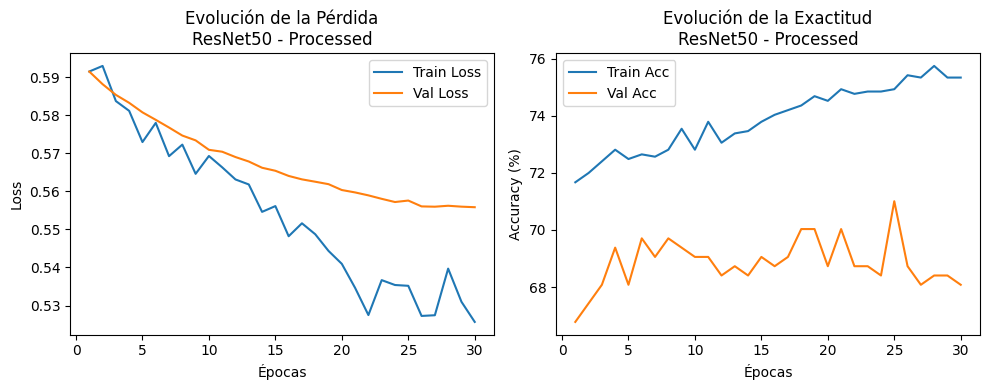


=== Final Training with Best Parameters - UNPROCESSED ===
Epoch 1/30, Train Loss: 0.6053, Train Acc: 0.7110, Val Loss: 0.5986, Val Acc: 0.6938
Epoch 2/30, Train Loss: 0.5896, Train Acc: 0.7135, Val Loss: 0.5974, Val Acc: 0.7036
Epoch 3/30, Train Loss: 0.5795, Train Acc: 0.7176, Val Loss: 0.5955, Val Acc: 0.7003
Epoch 4/30, Train Loss: 0.5796, Train Acc: 0.7233, Val Loss: 0.5946, Val Acc: 0.7036
Epoch 5/30, Train Loss: 0.5732, Train Acc: 0.7257, Val Loss: 0.5937, Val Acc: 0.7068
Epoch 6/30, Train Loss: 0.5785, Train Acc: 0.7355, Val Loss: 0.5925, Val Acc: 0.7101
Epoch 7/30, Train Loss: 0.5633, Train Acc: 0.7347, Val Loss: 0.5912, Val Acc: 0.6840
Epoch 8/30, Train Loss: 0.5575, Train Acc: 0.7339, Val Loss: 0.5902, Val Acc: 0.6808
Epoch 9/30, Train Loss: 0.5591, Train Acc: 0.7388, Val Loss: 0.5900, Val Acc: 0.6808
Epoch 10/30, Train Loss: 0.5603, Train Acc: 0.7388, Val Loss: 0.5890, Val Acc: 0.6808
Epoch 11/30, Train Loss: 0.5580, Train Acc: 0.7437, Val Loss: 0.5879, Val Acc: 0.6775
Epoc

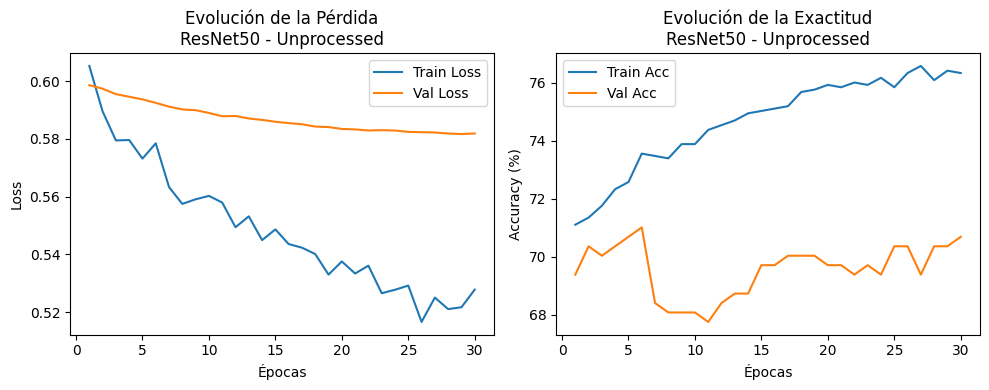


=== Evaluation: Processed Data ===

=== Resultados en Test [ResNet50 - Processed] ===
Test Loss: 0.5502, Test Accuracy: 76.02%


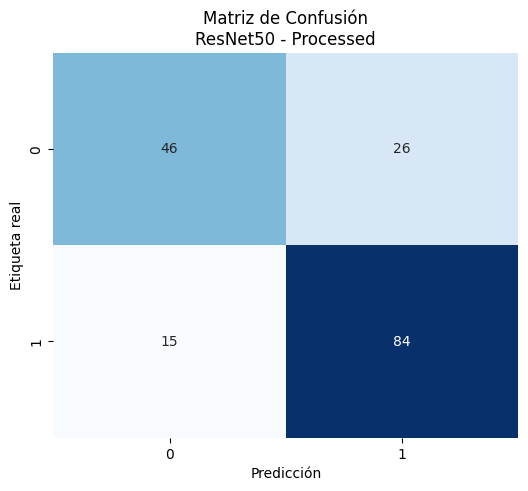


Reporte de Clasificación (ResNet50 - Processed):
              precision    recall  f1-score   support

           0     0.7541    0.6389    0.6917        72
           1     0.7636    0.8485    0.8038        99

    accuracy                         0.7602       171
   macro avg     0.7589    0.7437    0.7478       171
weighted avg     0.7596    0.7602    0.7566       171



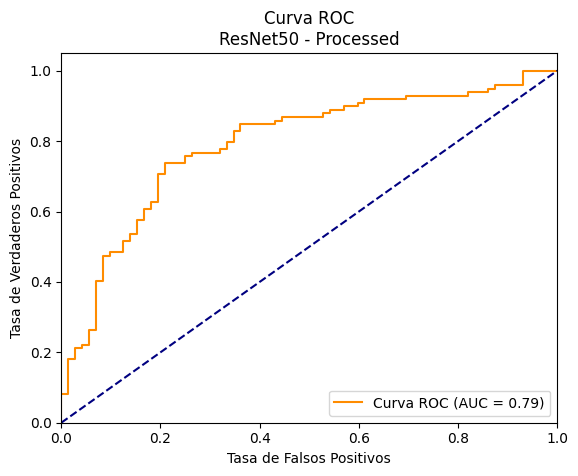


=== Evaluation: Unprocessed Data ===

=== Resultados en Test [ResNet50 - Unprocessed] ===
Test Loss: 0.5769, Test Accuracy: 66.67%


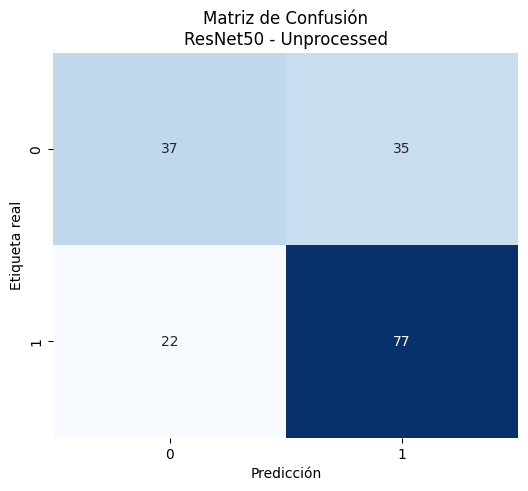


Reporte de Clasificación (ResNet50 - Unprocessed):
              precision    recall  f1-score   support

           0     0.6271    0.5139    0.5649        72
           1     0.6875    0.7778    0.7299        99

    accuracy                         0.6667       171
   macro avg     0.6573    0.6458    0.6474       171
weighted avg     0.6621    0.6667    0.6604       171



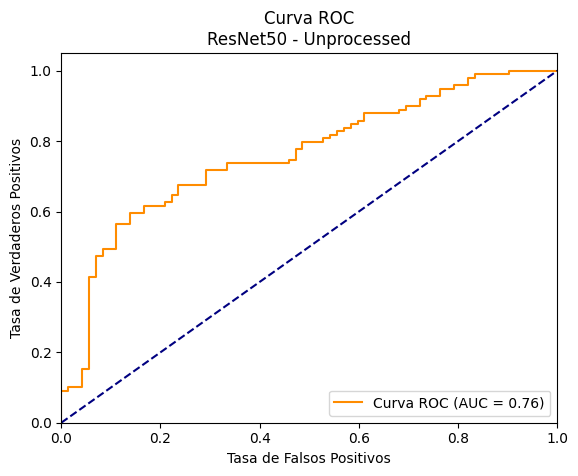

In [ ]:

# ==============================================================================
# 1. Modelo ResNet-50 Preentrenado (permitimos dropout como hiperparámetro)
# ==============================================================================
class FineTunedResNet50(nn.Module):
    def __init__(self, num_classes=2, dropout=0.5):
        """
        Carga ResNet-50 preentrenado y adapta la capa fully-connected final.
        Incluimos una capa adicional con dropout configurable para
        ajustar al número de clases deseado.
        """
        super(FineTunedResNet50, self).__init__()

        # Cargamos ResNet-50 base (pretrained=True)
        self.resnet = models.resnet50(pretrained=True)

        # Opcional: congelar capas
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Extraemos el número de características de la penúltima capa
        in_features = self.resnet.fc.in_features

        # Reemplazamos la FC original por una secuencia con dropout
        # La original es: nn.Linear(in_features, 1000)
        # La adaptamos a 'num_classes' + dropout
        self.resnet.fc = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)


# -------------------------------------------------------------------------------
# 8. Grid Search with Cross-Validation
# -------------------------------------------------------------------------------
def grid_search_cnn(dataset, device, param_grid, n_splits=5, n_epochs=5):
    criterion = nn.CrossEntropyLoss()
    param_combinations = list(ParameterGrid(param_grid))
    best_val_acc = 0.0
    best_config = None
    best_model_state = None

    # Extract labels for StratifiedKFold
    labels = np.array([label for _, label in dataset])

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2001)

    for params in param_combinations:
        val_accuracies = []
        for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
            print(f"Parameter Set: {params}, Fold: {fold+1}")

            # Create subsets and dataloaders
            train_subset = Subset(dataset, train_idx)
            val_subset = Subset(dataset, val_idx)
            train_loader = DataLoader(train_subset, batch_size=params['batch_size'], shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=params['batch_size'], shuffle=False)

            # Initialize model and optimizer
            model = FineTunedResNet50(num_classes=2, dropout=params['dropout']).to(device)
            optimizer = optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

            # Training loop
            for epoch in range(n_epochs):
                train_loss = train_model(model, train_loader, criterion, optimizer, device)
                val_loss, val_acc = validate_model(model, val_loader, criterion, device)
                print(f"Epoch {epoch+1}/{n_epochs}, "
                      f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

            val_accuracies.append(val_acc)

        avg_val_acc = np.mean(val_accuracies)
        print(f"Average Validation Accuracy for Params {params}: {avg_val_acc:.4f}\n")

        if avg_val_acc > best_val_acc:
            best_val_acc = avg_val_acc
            best_config = params
            best_model_state = model.state_dict()

    return best_config, best_val_acc, best_model_state


# -------------------------------------------------------------------------------
# 9. ejecucion
# -------------------------------------------------------------------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    param_grid = {
        'lr': [1e-4, 1e-5],
        'dropout': [0.3, 0.5, 0.7],
        'weight_decay': [1e-3, 1e-5],
        'batch_size': [16, 32]
    }

    # -------------------------------
    # 9.1 Grid Search: Processed Data
    # -------------------------------
    print("=== Grid Search with Cross-Validation - PROCESSED DATA ===")
    best_config_FineTunedResNet50, best_val_acc_FineTunedResNet50, best_model_state_FineTunedResNet50 = grid_search_cnn(
        train_processed_dataset, device, param_grid, n_splits=5, n_epochs=5
    )
    print(f"Best Config: {best_config_FineTunedResNet50}")
    print(f"Best Validation Accuracy: {best_val_acc_FineTunedResNet50:.4f}")

    # -------------------------------
    # 9.2 Grid Search: Unprocessed Data
    # -------------------------------
    print("=== Grid Search with Cross-Validation - UNPROCESSED DATA ===")
    best_config_un_FineTunedResNet50, best_val_acc_un_FineTunedResNet50, best_model_state_un_FineTunedResNet50 = grid_search_cnn(
        train_unprocessed_dataset, device, param_grid, n_splits=5, n_epochs=5
    )
    print(f"Best Config: {best_config_un_FineTunedResNet50}")
    print(f"Best Validation Accuracy: {best_val_acc_un_FineTunedResNet50:.4f}")


    best_model_FineTunedResNet50 = FineTunedResNet50(num_classes=2, dropout=best_config_FineTunedResNet50['dropout']).to(device)
    best_model_FineTunedResNet50.load_state_dict(best_model_state_FineTunedResNet50)

    best_model_un_FineTunedResNet50 = FineTunedResNet50(num_classes=2, dropout=best_config_un_FineTunedResNet50['dropout']).to(device)
    best_model_un_FineTunedResNet50.load_state_dict(best_model_state_un_FineTunedResNet50)


    # -----------------------------------------------------
    # 9.4 sets procesado y no procesado
    # -----------------------------------------------------

    test_loader = DataLoader(test_processed_dataset, batch_size=best_config_FineTunedResNet50['batch_size'], shuffle=False)


    test_loader_un = DataLoader(test_unprocessed_dataset, batch_size=best_config_un_FineTunedResNet50['batch_size'], shuffle=False)

    train_loader2 = DataLoader(train2_processed_dataset, batch_size=best_config_FineTunedResNet50['batch_size'], shuffle=False)

    train_loader_un2 = DataLoader(train2_unprocessed_dataset, batch_size=best_config_un_FineTunedResNet50['batch_size'], shuffle=False)

    val_loader = DataLoader(val_processed_dataset, batch_size=best_config_FineTunedResNet50['batch_size'], shuffle=False)

    val_loader_un = DataLoader(val_unprocessed_dataset, batch_size=best_config_un_FineTunedResNet50['batch_size'], shuffle=False)



    # -----------------------------------------------------
    # 9.5 evualuamos y entrenamos con mas epochs
    # -----------------------------------------------------
    criterion = nn.CrossEntropyLoss()

    test_loss, test_acc = validate_model(best_model_FineTunedResNet50, test_loader, criterion, device)
    print(f"Processed Test - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

    test_loss_un, test_acc_un = validate_model(best_model_un_FineTunedResNet50, test_loader_un, criterion, device)
    print(f"Unprocessed Test - Loss: {test_loss_un:.4f}, Accuracy: {test_acc_un:.4f}")


    print("\n=== Final Training with Best Parameters - PROCESSED ===")

    optimizer = optim.AdamW(best_model_FineTunedResNet50.parameters(), lr=best_config_FineTunedResNet50['lr'], weight_decay=best_config_FineTunedResNet50['weight_decay'])


    train_losses, val_losses, train_accs, val_accs = train_cnn(
        model=best_model_FineTunedResNet50,
        train_loader=train_loader2,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        epochs=30
    )

    plot_training_evolution(
        train_losses=train_losses,
        val_losses=val_losses,
        train_accs=train_accs,
        val_accs=val_accs,
        model_name="ResNet50",
        data_type="Processed"
    )



    print("\n=== Final Training with Best Parameters - UNPROCESSED ===")

    optimizer = optim.AdamW(best_model_un_FineTunedResNet50.parameters(), lr=best_config_un_FineTunedResNet50['lr'], weight_decay=best_config_un_FineTunedResNet50['weight_decay'])



    train_losses, val_losses, train_accs, val_accs = train_cnn(
        model=best_model_un_FineTunedResNet50,
        train_loader=train_loader_un2,
        val_loader=val_loader_un,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        epochs=30
    )

    plot_training_evolution(
        train_losses=train_losses,
        val_losses=val_losses,
        train_accs=train_accs,
        val_accs=val_accs,
        model_name="ResNet50",
        data_type="Unprocessed"
    )



    # -----------------------------------------------------
    # 9.8 Final Evaluation
    # -----------------------------------------------------
    print("\n=== Evaluation: Processed Data ===")
    evaluate_cnn(best_model_FineTunedResNet50, test_loader, nn.CrossEntropyLoss(), device, "ResNet50", "Processed")

    print("\n=== Evaluation: Unprocessed Data ===")
    evaluate_cnn(best_model_un_FineTunedResNet50, test_loader_un, nn.CrossEntropyLoss(), device, "ResNet50", "Unprocessed")




# ViT Grid Search

=== Grid Search with Cross-Validation - PROCESSED DATA ===
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 1


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 212MB/s]


Epoch 1/5, Train Loss: 0.7012, Val Loss: 0.6294, Val Acc: 0.6189
Epoch 2/5, Train Loss: 0.6717, Val Loss: 0.6629, Val Acc: 0.6612
Epoch 3/5, Train Loss: 0.6073, Val Loss: 0.6094, Val Acc: 0.6678
Epoch 4/5, Train Loss: 0.5521, Val Loss: 0.6096, Val Acc: 0.6612
Epoch 5/5, Train Loss: 0.4496, Val Loss: 0.8986, Val Acc: 0.5700
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 2
Epoch 1/5, Train Loss: 0.6960, Val Loss: 0.6238, Val Acc: 0.6775
Epoch 2/5, Train Loss: 0.6002, Val Loss: 0.6456, Val Acc: 0.6059
Epoch 3/5, Train Loss: 0.5891, Val Loss: 0.5238, Val Acc: 0.7329
Epoch 4/5, Train Loss: 0.5220, Val Loss: 0.5853, Val Acc: 0.7003
Epoch 5/5, Train Loss: 0.4083, Val Loss: 0.6174, Val Acc: 0.6873
Parameter Set: {'batch_size': 16, 'dropout': 0.3, 'lr': 0.0001, 'weight_decay': 0.001}, Fold: 3
Epoch 1/5, Train Loss: 0.6883, Val Loss: 0.6124, Val Acc: 0.6438
Epoch 2/5, Train Loss: 0.6203, Val Loss: 0.5979, Val Acc: 0.6536
Epoch 3/5, Train Loss: 0.559

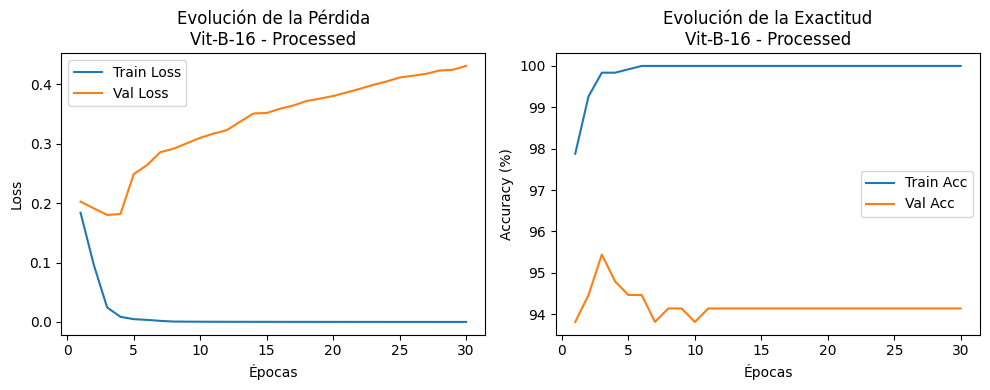


=== Final Training with Best Parameters - UNPROCESSED ===
Epoch 1/30, Train Loss: 0.2060, Train Acc: 0.9608, Val Loss: 0.2815, Val Acc: 0.9055
Epoch 2/30, Train Loss: 0.1541, Train Acc: 0.9771, Val Loss: 0.3243, Val Acc: 0.8860
Epoch 3/30, Train Loss: 0.1580, Train Acc: 0.9535, Val Loss: 0.4817, Val Acc: 0.8339
Epoch 4/30, Train Loss: 0.0682, Train Acc: 0.9967, Val Loss: 0.3693, Val Acc: 0.8893
Epoch 5/30, Train Loss: 0.0388, Train Acc: 0.9918, Val Loss: 0.4239, Val Acc: 0.8730
Epoch 6/30, Train Loss: 0.0267, Train Acc: 0.9984, Val Loss: 0.4081, Val Acc: 0.8893
Epoch 7/30, Train Loss: 0.0097, Train Acc: 0.9992, Val Loss: 0.4748, Val Acc: 0.8730
Epoch 8/30, Train Loss: 0.0323, Train Acc: 0.9935, Val Loss: 0.5721, Val Acc: 0.8371
Epoch 9/30, Train Loss: 0.0231, Train Acc: 0.9886, Val Loss: 0.6055, Val Acc: 0.8469
Epoch 10/30, Train Loss: 0.0239, Train Acc: 0.9804, Val Loss: 0.7345, Val Acc: 0.8241
Epoch 11/30, Train Loss: 0.0360, Train Acc: 0.9951, Val Loss: 0.5791, Val Acc: 0.8502
Epoc

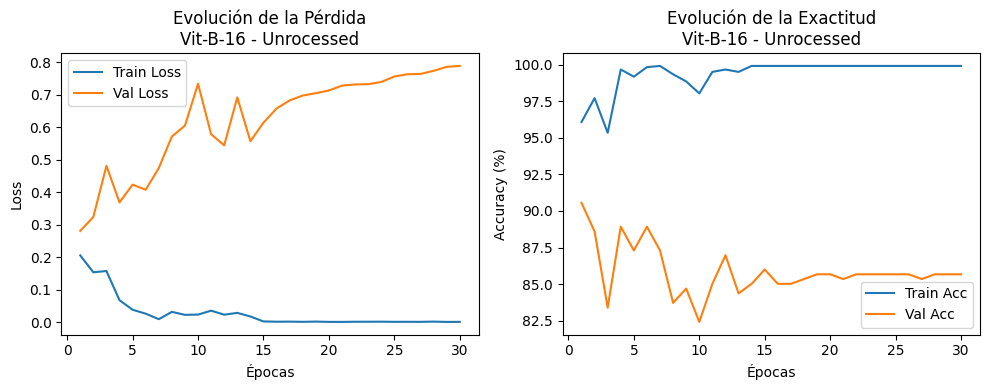


=== Evaluation: Processed Data ===

=== Resultados en Test [ViT-B-16 - Processed] ===
Test Loss: 1.7225, Test Accuracy: 77.19%


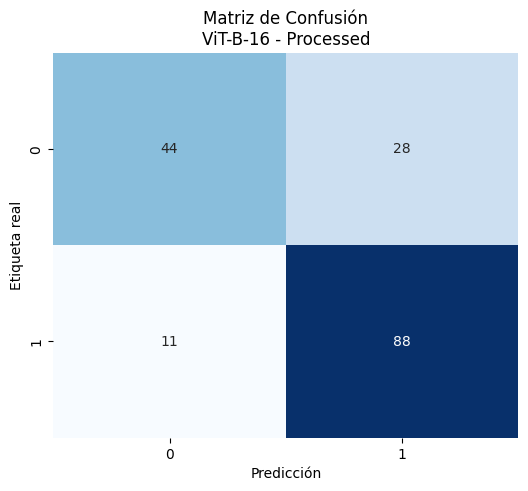


Reporte de Clasificación (ViT-B-16 - Processed):
              precision    recall  f1-score   support

           0     0.8000    0.6111    0.6929        72
           1     0.7586    0.8889    0.8186        99

    accuracy                         0.7719       171
   macro avg     0.7793    0.7500    0.7558       171
weighted avg     0.7760    0.7719    0.7657       171



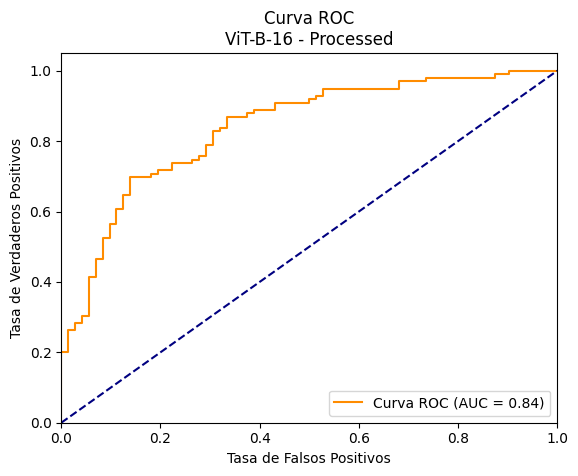


=== Evaluation: Unprocessed Data ===

=== Resultados en Test [ViT-B-16 - Unprocessed] ===
Test Loss: 1.4336, Test Accuracy: 77.19%


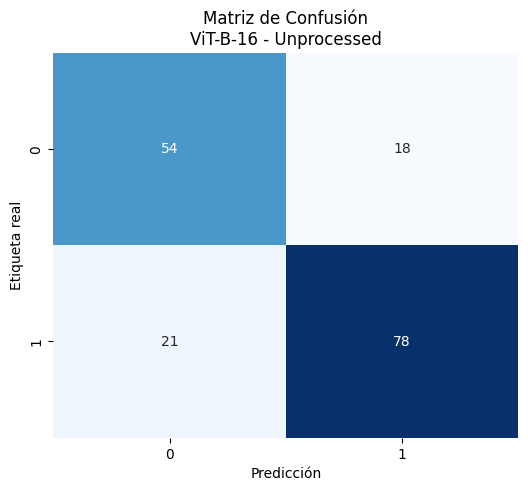


Reporte de Clasificación (ViT-B-16 - Unprocessed):
              precision    recall  f1-score   support

           0     0.7200    0.7500    0.7347        72
           1     0.8125    0.7879    0.8000        99

    accuracy                         0.7719       171
   macro avg     0.7662    0.7689    0.7673       171
weighted avg     0.7736    0.7719    0.7725       171



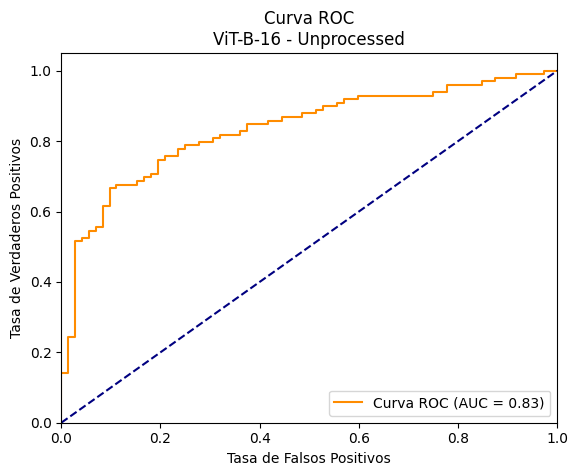

In [ ]:
# ==============================================================================
# 1. ViT-B/16 Pretrained (permite dropout como hiperparámetro)
# ==============================================================================
import torch
import torch.nn as nn
from torchvision import models

class FineTunedViT(nn.Module):
    def __init__(self, num_classes=2, dropout=0.5):
        super(FineTunedViT, self).__init__()

        self.vit = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)

        # congelamos capas excepto el classifier
        for param in self.vit.parameters():
            param.requires_grad = True

        in_features = self.vit.heads[0].in_features

        # 4) Sequential: Dropout + Linear
        self.vit.heads[0] = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.vit(x)




# -------------------------------------------------------------------------------
# 8. Grid Search with Cross-Validation
# -------------------------------------------------------------------------------
def grid_search_cnn(dataset, device, param_grid, n_splits=5, n_epochs=5):
    criterion = nn.CrossEntropyLoss()
    param_combinations = list(ParameterGrid(param_grid))
    best_val_acc = 0.0
    best_config = None
    best_model_state = None

    labels = np.array([label for _, label in dataset])

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2001)

    for params in param_combinations:
        val_accuracies = []
        for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
            print(f"Parameter Set: {params}, Fold: {fold+1}")


            train_subset = Subset(dataset, train_idx)
            val_subset = Subset(dataset, val_idx)
            train_loader = DataLoader(train_subset, batch_size=params['batch_size'], shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=params['batch_size'], shuffle=False)

            model = FineTunedViT(num_classes=2, dropout=params['dropout']).to(device)
            optimizer = optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

            for epoch in range(n_epochs):
                train_loss = train_model(model, train_loader, criterion, optimizer, device)
                val_loss, val_acc = validate_model(model, val_loader, criterion, device)
                print(f"Epoch {epoch+1}/{n_epochs}, "
                      f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

            val_accuracies.append(val_acc)

        avg_val_acc = np.mean(val_accuracies)
        print(f"Average Validation Accuracy for Params {params}: {avg_val_acc:.4f}\n")

        if avg_val_acc > best_val_acc:
            best_val_acc = avg_val_acc
            best_config = params
            best_model_state = model.state_dict()

    return best_config, best_val_acc, best_model_state


# -------------------------------------------------------------------------------
# 9. ejecucion principal
# -------------------------------------------------------------------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    param_grid = {
        'lr': [1e-4, 1e-5],
        'dropout': [0.3, 0.5, 0.7],
        'weight_decay': [1e-3, 1e-5],
        'batch_size': [16, 32]
    }

    # -------------------------------
    # 9.1 Grid Search: Processed Data
    # -------------------------------
    print("=== Grid Search with Cross-Validation - PROCESSED DATA ===")
    best_config_FineTunedViT, best_val_acc_FineTunedViT, best_model_state_FineTunedViT = grid_search_cnn(
        train_processed_dataset, device, param_grid, n_splits=5, n_epochs=5
    )
    print(f"Best Config: {best_config_FineTunedViT}")
    print(f"Best Validation Accuracy: {best_val_acc_FineTunedViT:.4f}")

    # -------------------------------
    # 9.2 Grid Search: Unprocessed Data
    # -------------------------------
    print("=== Grid Search with Cross-Validation - UNPROCESSED DATA ===")
    best_config_un_FineTunedViT, best_val_acc_un_FineTunedViT, best_model_state_un_FineTunedViT = grid_search_cnn(
        train_unprocessed_dataset, device, param_grid, n_splits=5, n_epochs=5
    )
    print(f"Best Config: {best_config_un_FineTunedViT}")
    print(f"Best Validation Accuracy: {best_val_acc_un_FineTunedViT:.4f}")


    best_model_FineTunedViT = FineTunedViT(num_classes=2, dropout=best_config_FineTunedViT['dropout']).to(device)
    best_model_FineTunedViT.load_state_dict(best_model_state_FineTunedViT)

    best_model_un_FineTunedViT = FineTunedViT(num_classes=2, dropout=best_config_un_FineTunedViT['dropout']).to(device)
    best_model_un_FineTunedViT.load_state_dict(best_model_state_un_FineTunedViT)



      # -----------------------------------------------------
    # 9.4 sets procesados y no procesados
    # -----------------------------------------------------

    test_loader = DataLoader(test_processed_dataset, batch_size=best_config_FineTunedViT['batch_size'], shuffle=False)

    test_loader_un = DataLoader(test_unprocessed_dataset, batch_size=best_config_un_FineTunedViT['batch_size'], shuffle=False)

    train_loader2 = DataLoader(train2_processed_dataset, batch_size=best_config_FineTunedViT['batch_size'], shuffle=False)

    train_loader_un2 = DataLoader(train2_unprocessed_dataset, batch_size=best_config_un_FineTunedViT['batch_size'], shuffle=False)

    val_loader = DataLoader(val_processed_dataset, batch_size=best_config_FineTunedViT['batch_size'], shuffle=False)

    val_loader_un = DataLoader(val_unprocessed_dataset, batch_size=best_config_un_FineTunedViT['batch_size'], shuffle=False)



    # -----------------------------------------------------
    # 9.5 evaluamos y reentrenamos con mas epochs
    # -----------------------------------------------------
    criterion = nn.CrossEntropyLoss()

    test_loss, test_acc = validate_model(best_model_FineTunedViT, test_loader, criterion, device)
    print(f"Processed Test - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

    test_loss_un, test_acc_un = validate_model(best_model_un_FineTunedViT, test_loader_un, criterion, device)
    print(f"Unprocessed Test - Loss: {test_loss_un:.4f}, Accuracy: {test_acc_un:.4f}")


    print("\n=== Final Training with Best Parameters - PROCESSED ===")

    optimizer = optim.AdamW(best_model_FineTunedViT.parameters(), lr=best_config_FineTunedViT['lr'], weight_decay=best_config_FineTunedViT['weight_decay'])

    train_losses, val_losses, train_accs, val_accs = train_cnn(
        model=best_model_FineTunedViT,
        train_loader=train_loader2,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        epochs=30
    )

    plot_training_evolution(
         train_losses=train_losses,
         val_losses=val_losses,
         train_accs=train_accs,
         val_accs=val_accs,
         model_name="Vit-B-16",
         data_type="Processed"
    )


    print("\n=== Final Training with Best Parameters - UNPROCESSED ===")

    optimizer = optim.AdamW(best_model_un_FineTunedViT.parameters(), lr=best_config_un_FineTunedViT['lr'], weight_decay=best_config_un_FineTunedViT['weight_decay'])



    train_losses, val_losses, train_accs, val_accs = train_cnn(
        model=best_model_un_FineTunedViT,
        train_loader=train_loader_un2,
        val_loader=val_loader_un,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        epochs=30
    )

    plot_training_evolution(
        train_losses=train_losses,
        val_losses=val_losses,
        train_accs=train_accs,
        val_accs=val_accs,
        model_name="Vit-B-16",
        data_type="Unrocessed"
    )



    # -----------------------------------------------------
    # 9.8 Final Evaluation
    # -----------------------------------------------------
    print("\n=== Evaluation: Processed Data ===")
    evaluate_cnn(best_model_FineTunedViT, test_loader, nn.CrossEntropyLoss(), device, "ViT-B-16", "Processed")

    print("\n=== Evaluation: Unprocessed Data ===")
    evaluate_cnn(best_model_un_FineTunedViT, test_loader_un, nn.CrossEntropyLoss(), device, "ViT-B-16", "Unprocessed")

